get_train_batch_all_signsHello Fellow Kagglers,

This notebook demonstrates the data processing and training process in Tensorflow.

I am excited about this competition, because my Master Thesis was on sign language recognition.

**Data Processing**

Only lips, hands and arm pose coordinates are used.

A custom Tensorflow layer handles the data processing. In short, it filters all frames without coordinates for the hands and downsamples the input to 32 frames if it is too long.

**Model**

A transformer based model is used. The embedding layer makes an ambedding per landmark(lips/left hand/right hand/arm pose) and merges these embedding with fully connected layers. The transformer consists of just 2 blocks with a simple mean pooling and fully connected layers for classification.


**V2**

* Learnable attention weights for each landmark
* Removed layer normalisation in embedding to prevent double layer normalisation at the end of embedding and start of transformer
* Removed additional fully connected layer in head before classification layer

**V3**

* Using all data for training
* Increased final embedding size 384 -> 512
* Added 10% dropout in classification layer
* Increased number of epoch 50 -> 100
* Number of transformer heads 8 -> 4

**V5**

* Corrected `USE_VAL` comments thanks to comment from [Jackson You](https://www.kaggle.com/jacksonyou)
* Corrected bug in preprocessing layer thanks to comment from [bilzard](https://www.kaggle.com/tatamikenn)
* Increased `INPUT_SIZE` 32 -> 64 and added label smoothing based on this [notebook](https://www.kaggle.com/code/hengck23/lb-0-73-single-fold-transformer-architecture) by [hengck23](https://www.kaggle.com/hengck23)
* Removed layer normalisation in transformer blocks. Model is very shallow. Conventional transformers have 10s of blocks, GPT-3 for example 96 and ViT-Huge 32, in contrast to this tiny transformer of just 2 blocks. The layer normalisation does not seem to be needed in such shallow networks.
* Biggest difference, normalisation to a single hand. When normalised to left handed, less than 1 percent of the right handed frames was filled. The model consists of only the lips, left hand and left arm pose.

V5 will most likely be the last update to keep this competition competitive.

Good luck to all of you in the last month of this exciting competition!

If you have any feedback or questions, please feel free to leave a comment.

Expect updates in the coming weeks!

In [1]:
!pip install git+https://github.com/modAL-python/modAL.git

  Cloning https://github.com/modAL-python/modAL.git to /tmp/pip-req-build-37_rs5l0


  Running command git clone --filter=blob:none --quiet https://github.com/modAL-python/modAL.git /tmp/pip-req-build-37_rs5l0


  Resolved https://github.com/modAL-python/modAL.git to commit bba6f6fd00dbb862b1e09259b78caf6cffa2e755


  Preparing metadata (setup.py) ... -

 done


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import tensorflow_probability as tfp

import logging
import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
from modAL.utils.selection import multi_argmax
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.decomposition import PCA
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Lambda
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit

print(f'Tensorflow V{tf.__version__}')
print(f'Keras V{tf.keras.__version__}')
print(f'Python V{sys.version}')

2024-10-26 21:20:03.411717: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


/home/f26273/.conda/envs/gislr/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/f26273/.conda/envs/gislr/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an i

Tensorflow V2.9.3
Keras V2.9.0
Python V3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]


In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:15:46_PDT_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


# Plot Config

In [4]:
# MatplotLib Global Settings
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 24

# Config

In [5]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = True
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = False

N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 64
NUM_CLASSES = 250
# IS_INTERACTIVE = os.environ['KAGGLE_KERNEL_RUN_TYPE'] == 'Interactive'
IS_INTERACTIVE = 'Interactive'
VERBOSE = 1 if IS_INTERACTIVE else 2

INPUT_SIZE = 64
BATCH_ALL_SIGNS_N = 4
# BATCH_SIZE = 256
BATCH_SIZE = 32
N_EPOCHS = 60
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 0
WD_RATIO = 0.05
MASK_VAL = 4237
ITERATION = 20
N_SAMPLES = 5000
ACTIVE_LEARNING_SELECT_SIZE = 128
SSL_SUBSET_RATIO = 0.1

# Utils

In [6]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')

# Train

In [7]:
# Read Training Data
if IS_INTERACTIVE or not PREPROCESS_DATA:
#     train = pd.read_csv('/kaggle/input/asl-signs/train.csv').sample(int(5e3), random_state=SEED)
    train = pd.read_csv('/home/f26273/data_enalisn1/GISLR/MSASL/filtered_training1.csv').sample(N_SAMPLES, random_state=SEED)
else:
    train = pd.read_csv('/home/f26273/data_enalisn1/GISLR/MSASL/filtered_training1.csv')


# Add File Path

In [8]:
# Get complete file path to file
def get_file_path(path):
    return f'/home/f26273/data_enalisn1/GISLR/WLASL/data/training/{path}'

train['file_path'] = train['path'].apply(get_file_path)

# Ordinally Encode Sign

In [9]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [10]:
display(train.head(30))
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
3137,16069/114684292.parquet,16069,114684292,carrot,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,37
12406,16069/3951779652.parquet,16069,3951779652,dog,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,58
16048,2044/923353459.parquet,2044,923353459,taste,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,213
854,2222/73912_dance.parquet,2222,73912,dance,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,56
11700,18796/3785670527.parquet,18796,3785670527,make,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,139
1263,2222/69652_aunt.parquet,2222,69652,aunt,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,10
3544,18796/1247244027.parquet,18796,1247244027,bed,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,17
213,2222/73361_for.parquet,2222,73361,for,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,88
2737,2044/1054127925.parquet,2044,1054127925,goose,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,98
19275,3333/24685088322510929_ROOM.parquet,3333,24685088322510929,room,/home/f26273/data_enalisn1/GISLR/WLASL/data/tr...,188


<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 3137 to 16819
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            5000 non-null   object
 1   participant_id  5000 non-null   int64 
 2   sequence_id     5000 non-null   int64 
 3   sign            5000 non-null   object
 4   file_path       5000 non-null   object
 5   sign_ord        5000 non-null   int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 244.1+ KB


None

# Video Statistics

In [11]:
N = int(1e3) if (IS_INTERACTIVE or not PREPROCESS_DATA) else int(10e3)
N_UNIQUE_FRAMES = np.zeros(N, dtype=np.uint16)
N_MISSING_FRAMES = np.zeros(N, dtype=np.uint16)
MAX_FRAME = np.zeros(N, dtype=np.uint16)

PERCENTILES = [0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 0.999]

for idx, file_path in enumerate(tqdm(train['file_path'].sample(N, random_state=SEED))):
    df = pd.read_parquet(file_path)
    N_UNIQUE_FRAMES[idx] = df['frame'].nunique()
    N_MISSING_FRAMES[idx] = (df['frame'].max() - df['frame'].min()) - df['frame'].nunique() + 1
    MAX_FRAME[idx] = df['frame'].max()

  0%|          | 0/1000 [00:00<?, ?it/s]

,N_UNIQUE_FRAMES
count,1000.000000
mean,39.762000
std,40.879022
min,2.000000
1%,4.000000
5%,6.000000
25%,14.000000
50%,25.000000
75%,51.000000
95%,125.050000


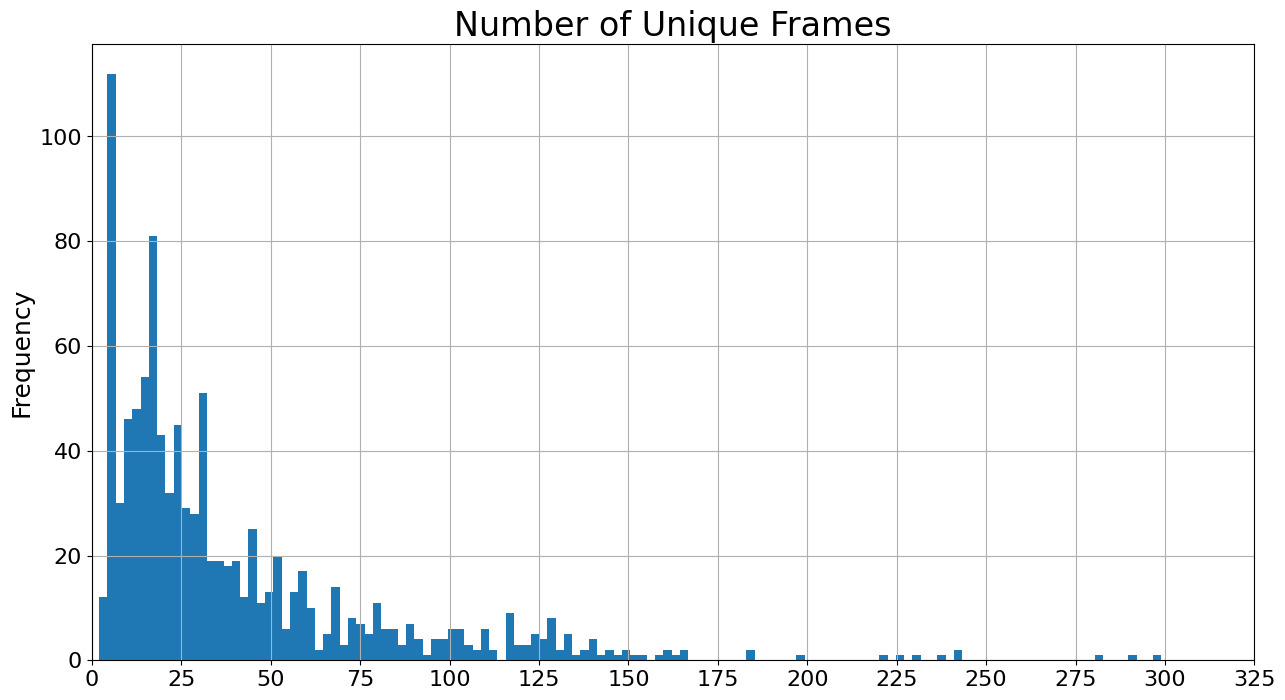

In [12]:
# Number of unique frames in each video
display(pd.Series(N_UNIQUE_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_UNIQUE_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Unique Frames', size=24)
pd.Series(N_UNIQUE_FRAMES).plot(kind='hist', bins=128)
plt.grid()
xlim = math.ceil(plt.xlim()[1])
plt.xlim(0, xlim)
plt.xticks(np.arange(0, xlim+25, 25))
plt.show()

,N_MISSING_FRAMES
count,1000.000000
mean,1.168000
std,6.252909
min,0.000000
1%,0.000000
5%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
95%,5.000000


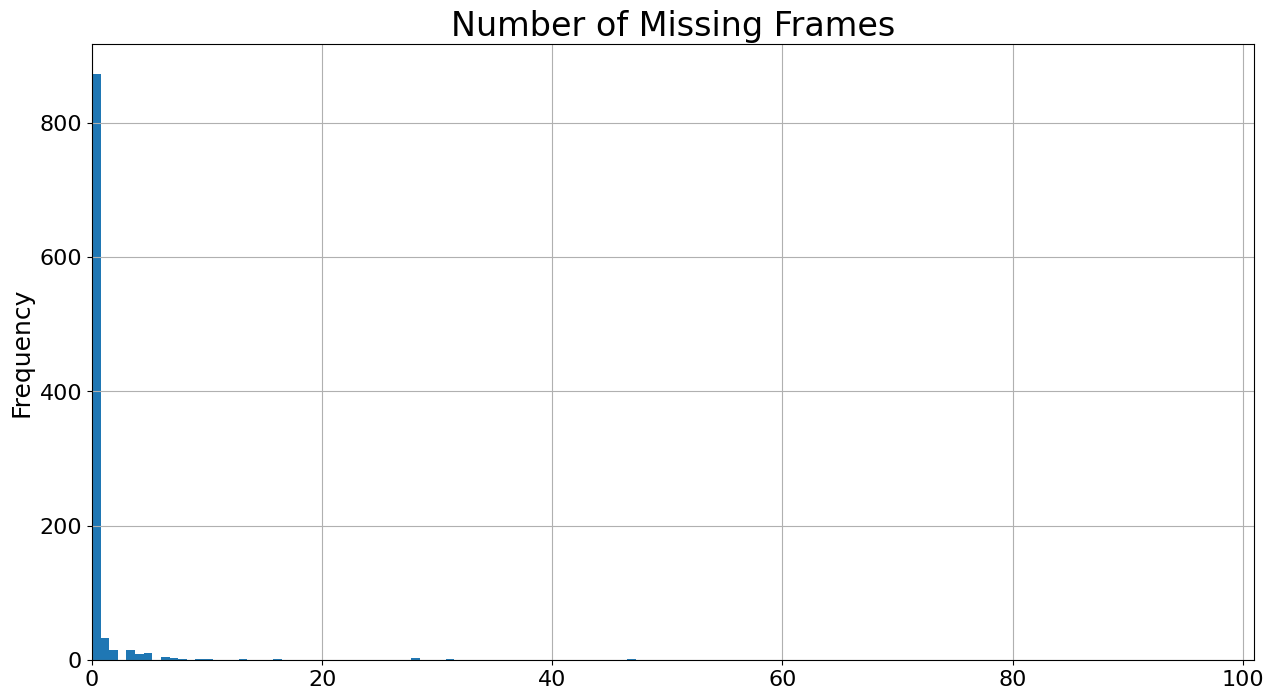

In [13]:
# Number of missing frames, consecutive frames with missing intermediate frame, i.e. 1,2,4,5 -> 3 is missing
display(pd.Series(N_MISSING_FRAMES).describe(percentiles=PERCENTILES).to_frame('N_MISSING_FRAMES'))

plt.figure(figsize=(15,8))
plt.title('Number of Missing Frames', size=24)
pd.Series(N_MISSING_FRAMES).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

,MAX_FRAME
count,1000.000000
mean,65.788000
std,54.685314
min,1.000000
1%,5.980000
5%,16.000000
25%,32.000000
50%,43.000000
75%,79.000000
95%,181.050000


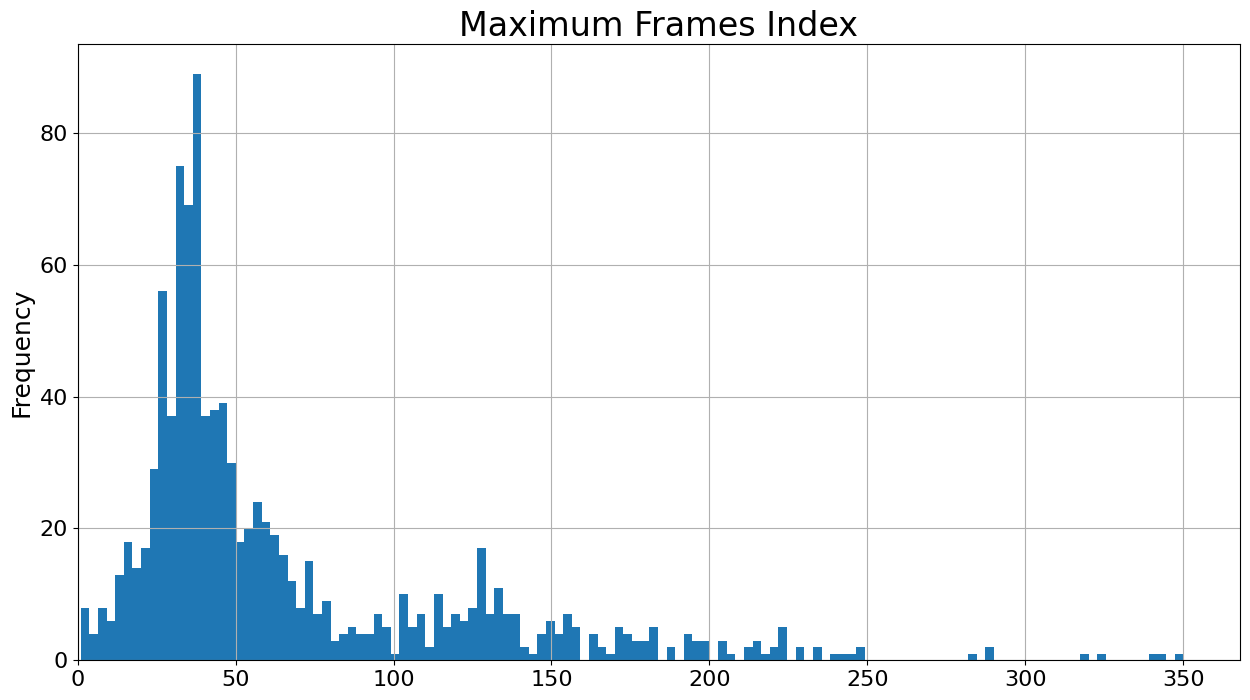

In [14]:
# Maximum frame number
display(pd.Series(MAX_FRAME).describe(percentiles=PERCENTILES).to_frame('MAX_FRAME'))

plt.figure(figsize=(15,8))
plt.title('Maximum Frames Index', size=24)
pd.Series(MAX_FRAME).plot(kind='hist', bins=128)
plt.grid()
plt.xlim(0, math.ceil(plt.xlim()[1]))
plt.show()

# Landmark Indices

In [15]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
LEFT_POSE_IDXS0 = np.array([502, 504, 506, 508, 510])
RIGHT_POSE_IDXS0 = np.array([503, 505, 507, 509, 511])
LANDMARK_IDXS_LEFT_DOMINANT0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, LEFT_POSE_IDXS0))
LANDMARK_IDXS_RIGHT_DOMINANT0 = np.concatenate((LIPS_IDXS0, RIGHT_HAND_IDXS0, RIGHT_POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS_LEFT_DOMINANT0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS_LEFT_DOMINANT0, LEFT_POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

# HAND_IDXS: 21, N_COLS: 66


In [16]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


# Process Data Tensorflow

In [17]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [18]:
"""
    Tensorflow layer to process data in TFLite
    Data needs to be processed in the model itself, so we can not use Python
""" 
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()
        normalisation_correction = tf.constant([
                    # Add 0.50 to left hand (original right hand) and substract 0.50 of right hand (original left hand)
                    [0] * len(LIPS_IDXS) + [0.50] * len(LEFT_HAND_IDXS) + [0.50] * len(POSE_IDXS),
                    # Y coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                    # Z coordinates stay intact
                    [0] * len(LANDMARK_IDXS_LEFT_DOMINANT0),
                ],
                dtype=tf.float32,
            )
        self.normalisation_correction = tf.transpose(normalisation_correction, [1,0])
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None,N_ROWS,N_DIMS], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Find dominant hand by comparing summed absolute coordinates
        left_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1))
        right_hand_sum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1))
        left_dominant = left_hand_sum >= right_hand_sum
        
        # Count non NaN Hand values in each frame for the dominant hand
        if left_dominant:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, LEFT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        else:
            frames_hands_non_nan_sum = tf.math.reduce_sum(
                    tf.where(tf.math.is_nan(tf.gather(data0, RIGHT_HAND_IDXS0, axis=1)), 0, 1),
                    axis=[1, 2],
                )
        
        # Find frames indices with coordinates of dominant hand
        non_empty_frames_idxs = tf.where(frames_hands_non_nan_sum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        # Filter frames
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32)
        # Normalize to start with 0
        non_empty_frames_idxs -= tf.reduce_min(non_empty_frames_idxs)
        
        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        if left_dominant:
            data = tf.gather(data, LANDMARK_IDXS_LEFT_DOMINANT0, axis=1)
        else:
            data = tf.gather(data, LANDMARK_IDXS_RIGHT_DOMINANT0, axis=1)
            data = (
                    self.normalisation_correction + (
                        (data - self.normalisation_correction) * tf.where(self.normalisation_correction != 0, -1.0, 1.0))
                )
        
        # Video fits in INPUT_SIZE
        if N_FRAMES < INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < INPUT_SIZE**2:
                repeats = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), INPUT_SIZE)
            if tf.math.mod(len(data), INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [INPUT_SIZE, -1, N_COLS, N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs
    
preprocess_layer = PreprocessLayer()

2024-10-26 21:20:18.333545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-26 21:20:18.869633: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38394 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


# Implement the Active Learner

In [19]:
# class KerasClassifierWrapper:
#     def __init__(self, model):
#         self.model = model

#     def fit(self, X, y):
#         self.model.fit(X, y, verbose=0, batch_size=10, epochs=10)

#     def predict_proba(self, X):
#         return self.model.predict(X)
    
#     def predict(self, X, **kwargs):
#         return np.argmax(self.predict_proba(X), axis=1)

#     def score(self, X, y, **kwargs):
#         # Evaluates using the first element of the tuple for frames and the second for indexes
#         return self.model.evaluate([X[0], X[1]], y, **kwargs)[1] 

# Interpolate NaN Values

In [20]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

# Create Dataset

In [21]:
def select_high_quality_frames(data, frame_idxs, num_frames=3):
    """
    Select the highest quality frames based on the number of detected landmarks.
    Args:
        data: The landmark data for all frames in the video.
        frame_idxs: The indices of the frames to evaluate.
        num_frames: Number of high-quality frames to select (default is 3).
    Returns:
        Selected frame indices based on quality.
    """
    frame_quality = np.zeros(len(frame_idxs))
    
    for i, frame_idx in enumerate(frame_idxs):
        # Count the number of non-NaN values in the frame (higher is better)
        frame_quality[i] = np.sum(~np.isnan(data[frame_idx]))
    
    # Sort frame indices by quality in descending order and pick the top num_frames
    selected_idxs = np.argsort(-frame_quality)[:num_frames]
    
    return frame_idxs[selected_idxs]

In [22]:
def get_reduced_frames(df, n_select=3):
    """
    Select frames with the highest quality for start, mid, and end positions.
    """
    # Get unique frames and select the start, middle, and end frames
    frames = df['frame'].unique()
    start_frame = frames[0]
    middle_frame = frames[len(frames) // 2]
    end_frame = frames[-1]
    
    # Combine start, middle, and end into one array
    candidate_frames = np.array([start_frame, middle_frame, end_frame])
    
    # Now select the highest quality frames among these candidate frames
    selected_frames = select_high_quality_frames(df[['x', 'y', 'z']].values, candidate_frames, n_select)
    
    return df[df['frame'].isin(selected_frames)]

In [23]:
def preprocess_data_with_quality_selection():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, 3, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, 3], -1, dtype=np.float32)

    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')
        
        # Load data and reduce it to the highest quality frames
        df = pd.read_parquet(file_path)
        df_reduced = get_reduced_frames(df)
        
        # Process the reduced data
        data, non_empty_frame_idxs = preprocess_layer(df_reduced)
        
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    np.save('X_reduced_quality.npy', X)
    np.save('y_reduced_quality.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS_reduced_quality.npy', NON_EMPTY_FRAME_IDXS)

In [24]:
def preprocess_data():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        df = pd.read_parquet(file_path)
        df_reduced = get_reduced_frames(df)
        data_np = df_reduced[['x', 'y', 'z']].values.reshape(-1, ROWS_PER_FRAME, 3).astype(np.float32)
        data_tensor = tf.convert_to_tensor(data_np, dtype=tf.float32)
        data, non_empty_frame_idxs = preprocess_layer(data_tensor)

        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs

        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)

    # First split: 70% train, 30% remaining (test + validation)
    splitter_train = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=SEED)
    PARTICIPANT_IDS = train['participant_id'].values
    train_idxs, remaining_idxs = next(splitter_train.split(X, y, groups=PARTICIPANT_IDS))

    # Second split: 66% of remaining (20% of total) for test, 33% of remaining (10% of total) for validation
    splitter_test_val = GroupShuffleSplit(test_size=0.33, n_splits=1, random_state=SEED)
    remaining_X = X[remaining_idxs]
    remaining_y = y[remaining_idxs]
    remaining_participant_ids = PARTICIPANT_IDS[remaining_idxs]
    test_idxs, val_idxs = next(splitter_test_val.split(remaining_X, remaining_y, groups=remaining_participant_ids))

    # Update indices to original dataset
    test_idxs = remaining_idxs[test_idxs]
    val_idxs = remaining_idxs[val_idxs]
    
    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)

    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)

    # Save Test
    X_test = X[test_idxs]
    NON_EMPTY_FRAME_IDXS_TEST = NON_EMPTY_FRAME_IDXS[test_idxs]
    y_test = y[test_idxs]
    np.save('X_test.npy', X_test)
    np.save('y_test.npy', y_test)
    np.save('NON_EMPTY_FRAME_IDXS_TEST.npy', NON_EMPTY_FRAME_IDXS_TEST)

    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[val_idxs])}')
    print(f'Patient ID Intersection Train/Test: {set(PARTICIPANT_IDS[train_idxs]).intersection(PARTICIPANT_IDS[test_idxs])}')
    print(f'Patient ID Intersection Val/Test: {set(PARTICIPANT_IDS[val_idxs]).intersection(PARTICIPANT_IDS[test_idxs])}')

    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}, X_test shape: {X_test.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}, y_test shape: {y_test.shape}')

In [25]:
from sklearn.model_selection import train_test_split
# Preprocess All Data From Scratch
if PREPROCESS_DATA:
    preprocess_data()
    ROOT_DIR = '.'
else:
    ROOT_DIR = '/data/enalisn1/f26273/GISLR/data/gislr-dataset-public'

# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'{ROOT_DIR}/X_train.npy')
    y_train = np.load(f'{ROOT_DIR}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{ROOT_DIR}/X_val.npy')
    y_val = np.load(f'{ROOT_DIR}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define Validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{ROOT_DIR}/X.npy')
    y_train = np.load(f'{ROOT_DIR}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None

# Load Test
X_test = np.load(f'{ROOT_DIR}/X_test.npy')
y_test = np.load(f'{ROOT_DIR}/y_test.npy')
NON_EMPTY_FRAME_IDXS_TEST = np.load(f'{ROOT_DIR}/NON_EMPTY_FRAME_IDXS_TEST.npy')

# X_train, X_test, y_train, y_test, NON_EMPTY_FRAME_IDXS_TRAIN, NON_EMPTY_FRAME_IDXS_TEST = train_test_split(
#     X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, test_size=0.20, random_state=SEED, stratify=y_train
# )

# Train 
print_shape_dtype([X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN], ['X_train', 'y_train', 'NON_EMPTY_FRAME_IDXS_TRAIN'])

# Val
if USE_VAL:
    print_shape_dtype([X_val, y_val, NON_EMPTY_FRAME_IDXS_VAL], ['X_val', 'y_val', 'NON_EMPTY_FRAME_IDXS_VAL'])

# Test
print_shape_dtype([X_test, y_test, NON_EMPTY_FRAME_IDXS_TEST], ['X_test', 'y_test', 'NON_EMPTY_FRAME_IDXS_TEST'])

# Sanity Check
print(f'# NaN Values X_train: {np.isnan(X_train).sum()}')
print(f'# NaN Values X_test: {np.isnan(X_test).sum()}')
print(validation_data)

  0%|          | 0/5000 [00:00<?, ?it/s]

Generated 0/5000


Patient ID Intersection Train/Val: set()
Patient ID Intersection Train/Test: set()
Patient ID Intersection Val/Test: set()
X_train shape: (3024, 64, 66, 3), X_val shape: (672, 64, 66, 3), X_test shape: (1304, 64, 66, 3)
y_train shape: (3024,), y_val shape: (672,), y_test shape: (1304,)
X_train shape: (5000, 64, 66, 3), dtype: float32
y_train shape: (5000,), dtype: int32
NON_EMPTY_FRAME_IDXS_TRAIN shape: (5000, 64), dtype: float32
X_test shape: (1304, 64, 66, 3), dtype: float32
y_test shape: (1304,), dtype: int32
NON_EMPTY_FRAME_IDXS_TEST shape: (1304, 64), dtype: float32
# NaN Values X_train: 0


# NaN Values X_test: 0
None


In [26]:
X_train_ori = X_train.copy()
y_train_ori = y_train.copy()
NON_EMPTY_FRAME_IDXS_TRAIN_ori = NON_EMPTY_FRAME_IDXS_TRAIN.copy()

In [27]:
used_samples_full = np.zeros(len(X_train), dtype=bool)
used_samples = np.zeros(len(X_train), dtype=bool)

In [28]:
# Class Count
display(pd.Series(y_train).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

,Class Count
102,37
97,35
118,34
142,33
121,32
34,8
6,8
242,7
164,7
228,2


# Self-Supervise Learning Data Process

In [29]:
# Calculate the size of the SSL subset
subset_size = int(len(X_train_ori.copy()) * 0.1)  # 10% of the original training data

# Randomly select indices for the SSL subset
ssl_indices = np.random.choice(len(X_train_ori.copy()), subset_size, replace=False)

# Create the SSL subset
X_train_ssl = X_train_ori[ssl_indices].copy()
y_train_ssl = y_train_ori[ssl_indices].copy()
NON_EMPTY_FRAME_IDXS_SSL = NON_EMPTY_FRAME_IDXS_TRAIN_ori[ssl_indices].copy()

# Verifying the shapes
print("X_train_ssl shape:", X_train_ssl.shape)
print("y_train_ssl shape:", y_train_ssl.shape)
print("NON_EMPTY_FRAME_IDXS_SSL shape:", NON_EMPTY_FRAME_IDXS_SSL.shape)

X_train_ssl shape: (500, 64, 66, 3)
y_train_ssl shape: (500,)
NON_EMPTY_FRAME_IDXS_SSL shape: (500, 64)


# Number Of Frames

  0%|          | 0/64 [00:00<?, ?it/s]

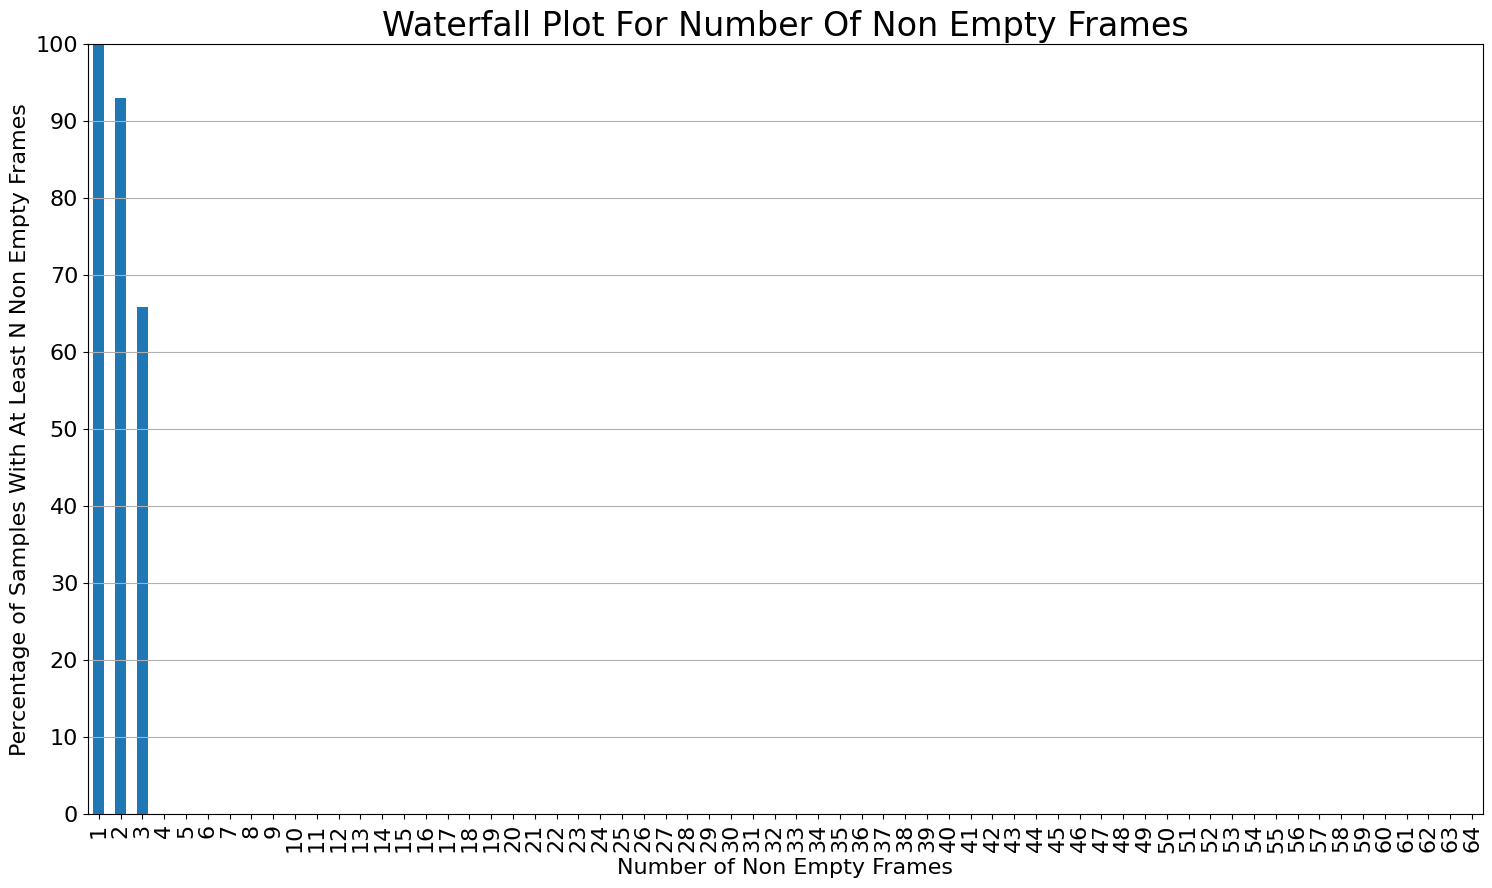

In [30]:
# Vast majority of samples fits has less than 32 non empty frames
N_EMPTY_FRAMES = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum(axis=1) 
N_EMPTY_FRAMES_WATERFALL = []
for n in tqdm(range(1,INPUT_SIZE+1)):
    N_EMPTY_FRAMES_WATERFALL.append(sum(N_EMPTY_FRAMES >= n) / len(NON_EMPTY_FRAME_IDXS_TRAIN) * 100)

plt.figure(figsize=(18,10))
plt.title('Waterfall Plot For Number Of Non Empty Frames')
pd.Series(N_EMPTY_FRAMES_WATERFALL).plot(kind='bar')
plt.grid(axis='y')
plt.xticks(np.arange(INPUT_SIZE), np.arange(1, INPUT_SIZE+1))
plt.xlabel('Number of Non Empty Frames', size=16)
plt.yticks(np.arange(0, 100+10, 10))
plt.ylim(0, 100)
plt.ylabel('Percentage of Samples With At Least N Non Empty Frames', size=16)
plt.show()

`# Percentage of Frames Filled`

In [31]:
# Percentage of frames filled, this is the maximum fill percentage of each landmark
P_DATA_FILLED = (NON_EMPTY_FRAME_IDXS_TRAIN != -1).sum() / NON_EMPTY_FRAME_IDXS_TRAIN.size * 100
print(f'P_DATA_FILLED: {P_DATA_FILLED:.2f}%')

P_DATA_FILLED: 4.04%


# Feature Statistics - Lips

In [32]:
# Percentage of Lips Measurements
P_LEFT_LIPS_MEASUREMENTS = (X_train[:,:,LIPS_IDXS] != 0).sum() / X_train[:,:,LIPS_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_LIPS_MEASUREMENTS: {P_LEFT_LIPS_MEASUREMENTS:.2f}%')

P_LEFT_LIPS_MEASUREMENTS: 65.68%


  0%|          | 0/40 [00:00<?, ?it/s]

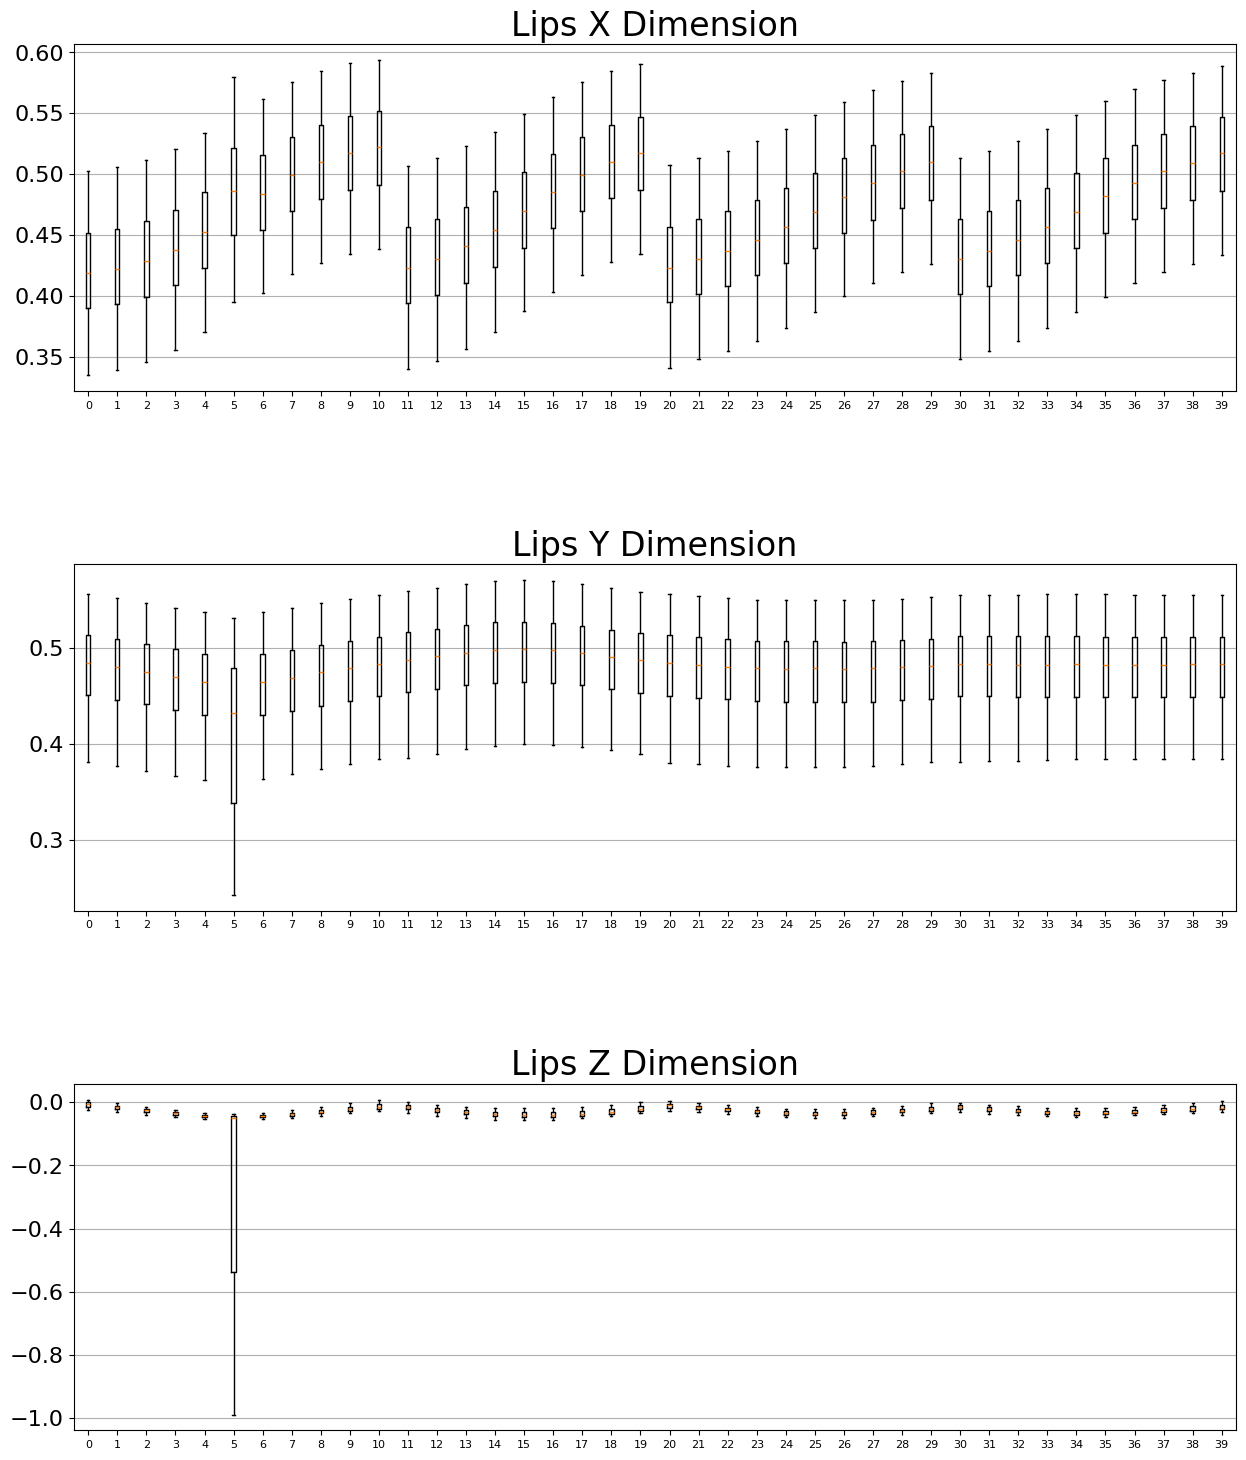

In [33]:
def get_lips_mean_std():
    # LIPS
    LIPS_MEAN_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_MEAN_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_X = np.zeros([LIPS_IDXS.size], dtype=np.float32)
    LIPS_STD_Y = np.zeros([LIPS_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LIPS_IDXS], [2,3,0,1]).reshape([LIPS_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LIPS_MEAN_X[col] = v.mean()
                LIPS_STD_X[col] = v.std()
            if dim == 1: # Y
                LIPS_MEAN_Y[col] = v.mean()
                LIPS_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Lips {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LIPS_MEAN = np.array([LIPS_MEAN_X, LIPS_MEAN_Y]).T
    LIPS_STD = np.array([LIPS_STD_X, LIPS_STD_Y]).T
    
    return LIPS_MEAN, LIPS_STD

LIPS_MEAN, LIPS_STD = get_lips_mean_std()

# Feature Statistics - Hands

In [34]:
# Verify Normalised to Left Hand Dominant
P_LEFT_HAND_MEASUREMENTS = (X_train[:,:,LEFT_HAND_IDXS] != 0).sum() / X_train[:,:,LEFT_HAND_IDXS].size / P_DATA_FILLED * 1e4
# P_RIGHT_HAND_MEASUREMENTS = (X_train[:,:,RIGHT_HAND_IDXS] != 0).sum() / X_train[:,:,RIGHT_HAND_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_LEFT_HAND_MEASUREMENTS: {P_LEFT_HAND_MEASUREMENTS:.2f}%')

P_LEFT_HAND_MEASUREMENTS: 100.00%


  0%|          | 0/21 [00:00<?, ?it/s]

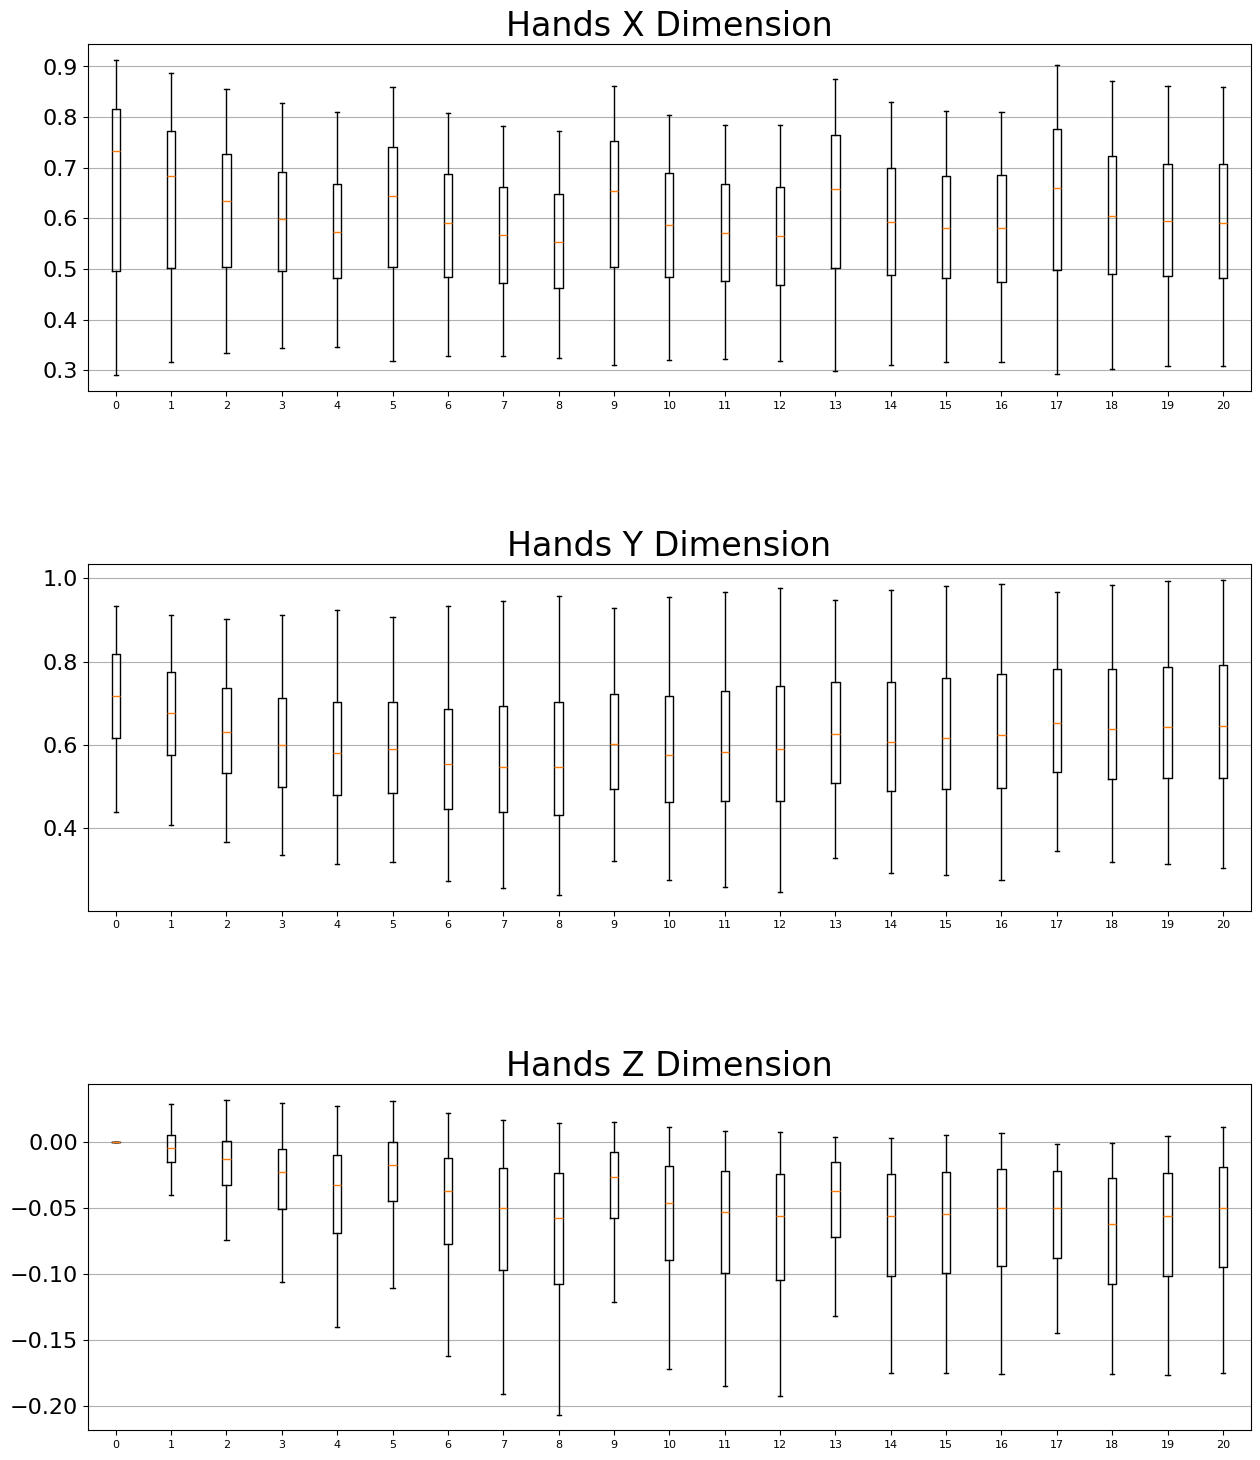

In [35]:
def get_left_right_hand_mean_std():
    # LEFT HAND
    LEFT_HANDS_MEAN_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_MEAN_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_X = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)
    LEFT_HANDS_STD_Y = np.zeros([LEFT_HAND_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,LEFT_HAND_IDXS], [2,3,0,1]).reshape([LEFT_HAND_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                LEFT_HANDS_MEAN_X[col] = v.mean()
                LEFT_HANDS_STD_X[col] = v.std()
            if dim == 1: # Y
                LEFT_HANDS_MEAN_Y[col] = v.mean()
                LEFT_HANDS_STD_Y[col] = v.std()
            # Plot
            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Hands {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
    LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T
    
    return LEFT_HANDS_MEAN, LEFT_HANDS_STD

LEFT_HANDS_MEAN, LEFT_HANDS_STD = get_left_right_hand_mean_std()

# Feature Statistics - Pose

In [36]:
# Percentage of Lips Measurements
P_POSE_MEASUREMENTS = (X_train[:,:,POSE_IDXS] != 0).sum() / X_train[:,:,POSE_IDXS].size / P_DATA_FILLED * 1e4
print(f'P_POSE_MEASUREMENTS: {P_POSE_MEASUREMENTS:.2f}%')

P_POSE_MEASUREMENTS: 100.00%


  0%|          | 0/5 [00:00<?, ?it/s]

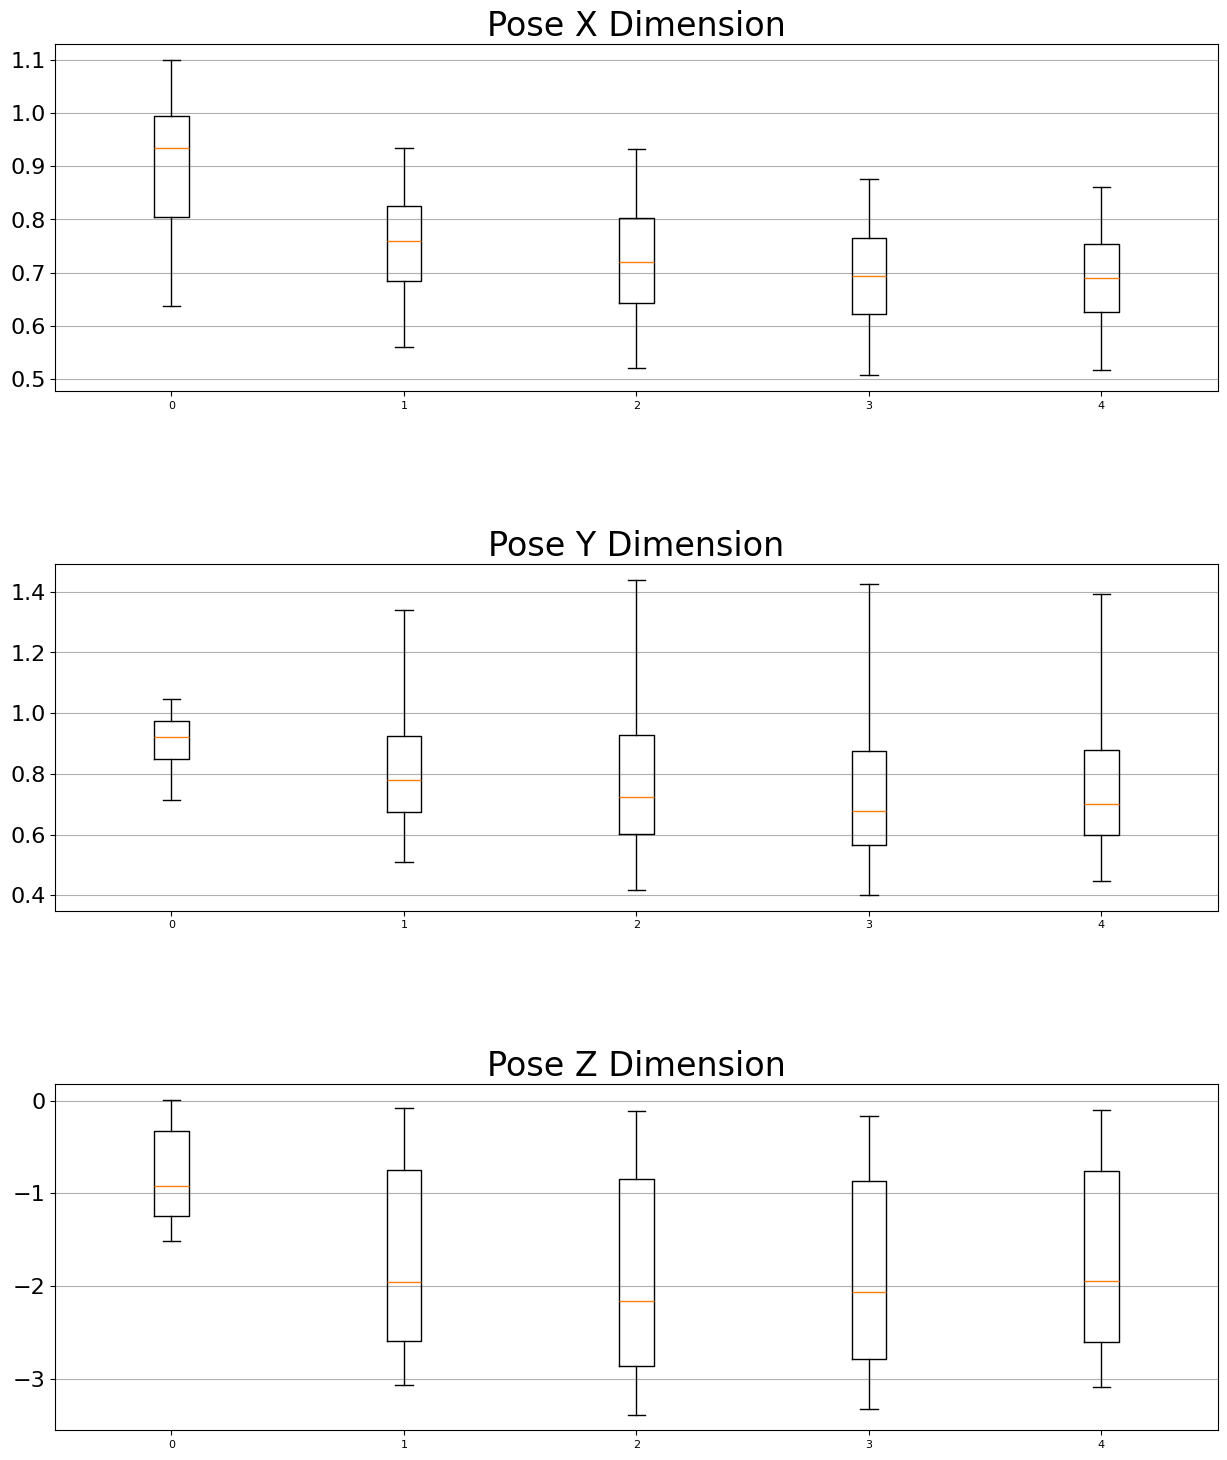

In [37]:
def get_pose_mean_std():
    # POSE
    POSE_MEAN_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_MEAN_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_X = np.zeros([POSE_IDXS.size], dtype=np.float32)
    POSE_STD_Y = np.zeros([POSE_IDXS.size], dtype=np.float32)

    fig, axes = plt.subplots(3, 1, figsize=(15, N_DIMS*6))

    for col, ll in enumerate(tqdm( np.transpose(X_train[:,:,POSE_IDXS], [2,3,0,1]).reshape([POSE_IDXS.size, N_DIMS, -1]) )):
        for dim, l in enumerate(ll):
            v = l[np.nonzero(l)]
            if dim == 0: # X
                POSE_MEAN_X[col] = v.mean()
                POSE_STD_X[col] = v.std()
            if dim == 1: # Y
                POSE_MEAN_Y[col] = v.mean()
                POSE_STD_Y[col] = v.std()

            axes[dim].boxplot(v, notch=False, showfliers=False, positions=[col], whis=[5,95])

    for ax, dim_name in zip(axes, DIM_NAMES):
        ax.set_title(f'Pose {dim_name.upper()} Dimension', size=24)
        ax.tick_params(axis='x', labelsize=8)
        ax.grid(axis='y')

    plt.subplots_adjust(hspace=0.50)
    plt.show()

    POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
    POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T
    
    return POSE_MEAN, POSE_STD

POSE_MEAN, POSE_STD = get_pose_mean_std()

# Active Learning

In [38]:
def get_active_learning_model(input_shape=(INPUT_SIZE, N_COLS, N_DIMS)):
    # Inputs
    frames = Input(shape=input_shape, dtype=tf.float32, name='frames')
    non_empty_frame_idxs = Input(shape=[INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(frames)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)

    # Output layer for uncertainty prediction - Using entropy of softmax probabilities
    logits = Dense(NUM_CLASSES, activation=None)(x)
    probabilities = tf.nn.softmax(logits)
    entropy = -tf.reduce_sum(probabilities * tf.math.log(probabilities + 1e-9), axis=1)

    # Model assembly
    model = Model(inputs=[frames, non_empty_frame_idxs], outputs=entropy)

    # Compile the model if needed (generally not necessary for prediction only in active learning)
    # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

active_learning_model = get_active_learning_model()

In [39]:
class CustomActiveLearner(ActiveLearner):
    def __init__(self, estimator, query_strategy, X_initial, y_initial, used_samples):
        super().__init__(estimator=estimator, query_strategy=query_strategy)
        self.X_training = X_initial if X_initial is not None else (np.array([]), np.array([]))
        self.y_training = y_initial if y_initial is not None else np.array([])
        self.used_samples = used_samples if used_samples is not None else np.zeros(len(X_initial[0]), dtype=bool)

    def teach(self, X, y):
        X_frames, X_idxs = X
        if X_frames.size == 0 or X_idxs.size == 0:
            print("No frames or indices to teach.")
            return

        if self.X_training[0].size == 0:
            self.X_training = (X_frames, X_idxs)
            self.y_training = y
        else:
            self.X_training = (np.vstack([self.X_training[0], X_frames]), np.vstack([self.X_training[1], X_idxs]))
            self.y_training = np.concatenate([self.y_training, y])

        self.estimator.fit(self.X_training, self.y_training)
        self.used_samples[X_idxs] = True

        print(f"Indices used this batch: {X_idxs}")
        print(f"Max index attempted to access: {np.max(X_idxs)}")

In [40]:
def initialize_active_learner(X_train_frames, X_train_idxs, y_train, initial_size=50):
    initial_indices = np.random.choice(len(X_train_frames), size=initial_size, replace=False)
    X_initial_frames = X_train_frames[initial_indices]
    X_initial_idxs = X_train_idxs[initial_indices]
    y_initial = y_train[initial_indices]
    
    if len(X_train_frames) < initial_size:
        raise ValueError(f"Not enough data points to initialize learner with {initial_size} samples.")
    learner = CustomActiveLearner(
        estimator=get_model(),  # Ensure the model is compiled inside get_model
        query_strategy=custom_query,
        X_initial=(X_initial_frames, X_initial_idxs),
        y_initial=y_initial
    )
    return learner

In [41]:
def custom_query(model, X_pool, non_empty_frame_idxs, y_pool, batch_size, decay_memory=None, n_clusters=5, max_memory=2):
    probabilities = model.predict([X_pool, non_empty_frame_idxs])
    print("Shape of probabilities:", probabilities.shape)

    if probabilities.ndim == 1:
        uncertainties = -np.abs(probabilities - 0.5)
    else:
        uncertainties = -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)

    # Determine indices with the highest uncertainties
    uncertainty_indices = np.argsort(uncertainties)[::-1]

    if probabilities.ndim > 1 and uncertainty_indices.size > 1:
        pca = PCA(n_components=min(50, probabilities.shape[1], uncertainty_indices.size))
        pca_reduced = pca.fit_transform(probabilities[uncertainty_indices])
        kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(pca_reduced)
        clusters = kmeans.labels_
        selected_indices = []
        for cluster_id in range(n_clusters):
            cluster_indices = uncertainty_indices[clusters == cluster_id]
            selected_indices.extend(cluster_indices[:min(len(cluster_indices), (batch_size // n_clusters) + 1)])
    else:
        selected_indices = uncertainty_indices[:min(len(uncertainty_indices), batch_size)]

    selected_X = X_pool[selected_indices]
    selected_non_empty_frame_idxs = non_empty_frame_idxs[selected_indices]
    selected_y = y_pool[selected_indices]

    print(f"Selected indices: {selected_indices}")
    return np.array(selected_indices), selected_X, selected_non_empty_frame_idxs, selected_y

# Batch Generator

In [42]:
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, X_selected, y_selected, selected_non_empty_frame_idxs, BATCH_SIZE=BATCH_SIZE):
    # Calculate the number of instances to take per class
    instances_per_class = max(1, BATCH_SIZE // NUM_CLASSES)
    total_active_learning_data = len(X_selected)
    
    # Initialize batch arrays
    X_batch = np.zeros([BATCH_SIZE, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.zeros(BATCH_SIZE, dtype=np.int64)
    non_empty_frame_idxs_batch = np.zeros([BATCH_SIZE, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
    
    # Include selected data from active learning in the batch
    active_learning_count = min(total_active_learning_data, BATCH_SIZE)
    X_batch[:active_learning_count] = X_selected
    y_batch[:active_learning_count] = y_selected
    non_empty_frame_idxs_batch[:active_learning_count] = selected_non_empty_frame_idxs

    # Fill the rest of the batch arrays with randomly selected data
    start_index = active_learning_count
    for i in range(NUM_CLASSES):
        if start_index >= BATCH_SIZE:
            break
        available_indices = np.setdiff1d(np.argwhere(y == i).squeeze().astype(np.int32), X_selected, assume_unique=True)
        required_instances = min(instances_per_class, len(available_indices), BATCH_SIZE - start_index)
        
        if required_instances > 0:
            selected_indices = np.random.choice(available_indices, required_instances, replace=False)
            end_index = start_index + required_instances
            X_batch[start_index:end_index] = X[selected_indices]
            y_batch[start_index:end_index] = y[selected_indices]
            non_empty_frame_idxs_batch[start_index:end_index] = NON_EMPTY_FRAME_IDXS[selected_indices]
            start_index += required_instances

    yield {'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch}, y_batch

In [43]:
def move_used_data_to_subset(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, used_samples,
                             X_train_subset, y_train_subset, NON_EMPTY_FRAME_IDXS_TRAIN_subset,
                             X_batch, y_batch, non_empty_frame_idxs_batch):
    # Determine the indices of the used samples based on used_samples
    used_indices = np.where(used_samples)[0]

    # Append the batch data to the subsets
    X_train_subset = np.concatenate([X_train_subset, X_batch], axis=0)
    y_train_subset = np.concatenate([y_train_subset, y_batch], axis=0)
    NON_EMPTY_FRAME_IDXS_TRAIN_subset = np.concatenate([NON_EMPTY_FRAME_IDXS_TRAIN_subset, non_empty_frame_idxs_batch], axis=0)

    # Explicitly delete the used data from the original datasets
    # Creating a mask that is True for all indices that are NOT used
    mask = np.ones(len(X_train), dtype=bool)
    mask[used_indices] = False

    # Apply the mask to remove the used data
    X_train = X_train[mask]
    y_train = y_train[mask]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS_TRAIN[mask]

    # Return the modified training set and updated subsets
    return X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, \
           X_train_subset, y_train_subset, NON_EMPTY_FRAME_IDXS_TRAIN_subset

# Note: Ensure all inputs are appropriately defined before using this function.


In [44]:
class CaptureAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, used_samples, check_frequency=5):
        super().__init__()
        self.used_samples = used_samples
        self.check_frequency = check_frequency
        self.reset()
        self.accuracy_history = []

    def reset(self):
        self.first_full_usage_accuracy = None
        self.first_full_usage_batch = None
        self.all_data_used = False
        self.used_samples.fill(False)  # Reset all values to False

    def on_batch_end(self, batch, logs=None):
        logs = logs or {}  # Ensure logs is a dictionary even if None is passed
        
        # Track and log accuracy at specified intervals
        accuracy = logs.get('acc')
        if accuracy is not None and (batch + 1) % self.check_frequency == 0:
            self.accuracy_history.append(accuracy)
            print(f"Accuracy at batch {batch + 1}: {accuracy:.4f}")

        # Calculate and print coverage
        if (batch + 1) % self.check_frequency == 0:
            coverage = np.mean(self.used_samples) * 100
            print(f"Coverage after batch {batch + 1}: {coverage:.2f}%")

        # Capture the accuracy when all data has been used
        if not self.all_data_used and np.all(self.used_samples):
            self.first_full_usage_accuracy = logs.get('accuracy', 0)  # Default to 0 if 'accuracy' is not in logs
            self.first_full_usage_batch = batch
            self.all_data_used = True
            print(f"Captured accuracy {self.first_full_usage_accuracy} on batch {self.first_full_usage_batch}")

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}  # Ensure logs is a dictionary even if None is passed
        if self.all_data_used:
            print(f"First complete usage of all data occurred at batch {self.first_full_usage_batch} in epoch {epoch+1} with accuracy {self.first_full_usage_accuracy}")

        accuracy = logs.get('acc')
        if accuracy is not None:
            self.accuracy_history.append(accuracy)


In [45]:
def get_training_data():
    # This function should return frames, indexes, and labels for training.
    # Depending on how your data is stored (e.g., in files, databases, etc.), this function will vary.
    # Here's a conceptual template:

    # Load or generate frames data
    frames_train_data = np.random.rand(N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS)  # Random data for example purposes
    # Load or generate index data
    idxs_train_data = np.random.rand(N_SAMPLES, INPUT_SIZE)  # Random index data for example
    # Generate labels (dummy labels here as an example)
    initial_y_train = np.random.randint(0, NUM_CLASSES, N_SAMPLES)

    return frames_train_data, idxs_train_data, initial_y_train

In [46]:
def preprocess_data(frames, idxs, input_size):
    # Ensure idxs is a numpy array, if it isn't already
    idxs = np.array(idxs)
    
    # Find the maximum indices, clipping at minimum value of 1 to avoid division by zero
    max_frame_idxs = np.max(idxs, axis=1, keepdims=True)
    max_frame_idxs = np.clip(max_frame_idxs, 1, np.inf)
    
    # Normalize indices, handle -1 values properly
    normalised_idxs = np.where(
        idxs == -1,
        input_size,
        np.floor(idxs / max_frame_idxs * input_size).astype(np.int32)
    )
    
    return frames, normalised_idxs

In [47]:
# Load training data
frames_train_data, idxs_train_data, initial_y_train = get_training_data()
frames_train_data, idxs_train_data = preprocess_data(frames_train_data, idxs_train_data, INPUT_SIZE)

# Split the data to create a pool for active learning
X_train_frames, X_pool_frames, X_train_idxs, X_pool_idxs, y_train_subset, y_pool = train_test_split(
    frames_train_data, idxs_train_data, initial_y_train, test_size=0.8, random_state=42
)

In [48]:
def update_train_subset(X_train, y_train, used_samples, model, batch_size):
    # Select indices for new data points to add to the subset
    new_indices = custom_query(model, X_train, y_train, used_samples, batch_size=batch_size)

    # Add these new indices to the X_train_subset and y_train_subset
    X_train_subset = np.concatenate([X_train_subset, X_train[new_indices]], axis=0)
    y_train_subset = np.concatenate([y_train_subset, y_train[new_indices]], axis=0)

    # Update the used_samples to reflect the newly used samples
    used_samples[new_indices] = True

    return X_train_subset, y_train_subset, used_samples

In [49]:
print("Total size of y_train after encoding:", len(y_train))
print("Size of train['sign']:", len(train['sign']))
print("Size of NON_EMPTY_FRAME_IDXS_TRAIN", len(NON_EMPTY_FRAME_IDXS_TRAIN))

Total size of y_train after encoding: 5000
Size of train['sign']: 5000
Size of NON_EMPTY_FRAME_IDXS_TRAIN 5000


In [50]:
num_classes = len(np.unique(y_train))
print("Total number of classes:", num_classes)


Total number of classes: 251


In [51]:
print("Size of X_train:", X_train.shape)
# print("Size of X_train_subset:", X_train_subset.shape)
# Assuming X_pool is equivalent to X_train based on your setup
print("Size of X_pool (X_train):", X_train.shape)
print("Size of used_samples:", used_samples.shape)

Size of X_train: (5000, 64, 66, 3)
Size of X_pool (X_train): (5000, 64, 66, 3)
Size of used_samples: (5000,)


# Model Config

In [52]:
# Epsilon value for layer normalisation
LAYER_NORM_EPS = 1e-6

# Dense layer units for landmarks
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512

# Transformer
NUM_BLOCKS = 2
MLP_RATIO = 2

# Dropout
EMBEDDING_DROPOUT = 0.00
MLP_DROPOUT_RATIO = 0.30
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu

print(f'UNITS: {UNITS}')

UNITS: 512


# Transformer

Need to implement transformer from scratch as TFLite does not support the native TF implementation of MultiHeadAttention.

In [53]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [54]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)
    
        return x

# Landmark Embedding

In [55]:
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

# Embedding

In [56]:
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)
        # Embedding layer for Landmarks
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer=INIT_GLOROT_UNIFORM),
            tf.keras.layers.Activation(GELU),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=INIT_HE_UNIFORM),
        ], name='fc')


    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Lips
        lips_embedding = self.lips_embedding(lips0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((
            lips_embedding, left_hand_embedding, pose_embedding,
        ), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

# Augmentation

In [57]:
# Not used, adds random X/y translation to input on samples level
class Augmentation(tf.keras.layers.Layer):
    def __init__(self, noise_std):
        super(Augmentation, self).__init__()
        self.noise_std = noise_std
    
    def add_noise(self, t):
        B = tf.shape(t)[0]
        return tf.where(
            t == 0.0,
            0.0,
            t + tf.random.normal([B,1,1,tf.shape(t)[3]], 0, self.noise_std),
        )
    
    def call(self, lips0, left_hand0, pose0, training=False):
        if training:
            # Lips
            lips0 = self.add_noise(lips0)
            # Left Hand
            left_hand0 = self.add_noise(left_hand0)
            # Pose
            pose0 = self.add_noise(pose0)
        
        return lips0, left_hand0, pose0

# Sparse Categorical Crossentropy With Label Smoothing

In [58]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

In [59]:
class DataCounterCallback(tf.keras.callbacks.Callback):
    def __init__(self, total_samples):
        self.total_samples = total_samples
        self.counter = np.zeros(self.total_samples, dtype=int)

    def on_batch_end(self, batch, logs=None):
        indices = self.model.current_batch_indices  # This needs to be set somewhere in your data generator
        np.add.at(self.counter, indices, 1)

    def on_train_end(self, logs=None):
        print("Data usage count:", self.counter)

# Model

In [60]:
print("Size of X_train: ", X_train.shape)
# print("Size of X_train_subset: ", X_train_subset.shape)


Size of X_train:  (5000, 64, 66, 3)


In [61]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Maskingmodel =
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )
    
    
    """
        left_hand: 468:489
        pose: 489:522
        right_hand: 522:543
    """
    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )
    
    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
        
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)
    
    # Encoder Transformer Blocks
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    
    # TopK Metrics
#     metrics = [
#         tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
#         tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
#     ]
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='acc')]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    return model

In [62]:
tf.keras.backend.clear_session()
# def build_model():
#     return get_model()
model = get_model()
# wrapped_model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=10, verbose=1)

In [63]:
# Plot model summary
model.summary(expand_nested=True)

Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               


 er)                                                                                              


 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   


 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      


 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']                


 frames (InputLayer)            [(None, 64, 66, 3)]  0           []                               


 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['tf.expand_dims[0][0]']         


 )                                                                                                


 tf.slice (TFOpLambda)          (None, 64, 66, 2)    0           ['frames[0][0]']                 


 tf.random.uniform (TFOpLambda)  (None, 64, 1)       0           ['tf.compat.v1.shape[0][0]']     


 tf.slice_1 (TFOpLambda)        (None, 64, 40, 2)    0           ['tf.slice[0][0]']               


 tf.slice_2 (TFOpLambda)        (None, 64, 21, 2)    0           ['tf.slice[0][0]']               


 tf.slice_3 (TFOpLambda)        (None, 64, 5, 2)     0           ['tf.slice[0][0]']               


 tf.math.greater (TFOpLambda)   (None, 64, 1)        0           ['tf.random.uniform[0][0]']      


 tf.math.not_equal_1 (TFOpLambd  (None, 64, 1)       0           ['tf.expand_dims[0][0]']         


 a)                                                                                               


 tf.math.subtract (TFOpLambda)  (None, 64, 40, 2)    0           ['tf.slice_1[0][0]']             


 tf.math.subtract_1 (TFOpLambda  (None, 64, 21, 2)   0           ['tf.slice_2[0][0]']             


 )                                                                                                


 tf.math.subtract_2 (TFOpLambda  (None, 64, 5, 2)    0           ['tf.slice_3[0][0]']             


 )                                                                                                


 tf.math.logical_and (TFOpLambd  (None, 64, 1)       0           ['tf.math.greater[0][0]',        


 a)                                                               'tf.math.not_equal_1[0][0]']    


 tf.math.equal_1 (TFOpLambda)   (None, 64, 40, 2)    0           ['tf.slice_1[0][0]']             


 tf.math.truediv (TFOpLambda)   (None, 64, 40, 2)    0           ['tf.math.subtract[0][0]']       


 tf.math.equal_2 (TFOpLambda)   (None, 64, 21, 2)    0           ['tf.slice_2[0][0]']             


 tf.math.truediv_1 (TFOpLambda)  (None, 64, 21, 2)   0           ['tf.math.subtract_1[0][0]']     


 tf.math.equal_3 (TFOpLambda)   (None, 64, 5, 2)     0           ['tf.slice_3[0][0]']             


 tf.math.truediv_2 (TFOpLambda)  (None, 64, 5, 2)    0           ['tf.math.subtract_2[0][0]']     


 tf.where (TFOpLambda)          (None, 64, 1)        0           ['tf.math.logical_and[0][0]']    


 tf.where_2 (TFOpLambda)        (None, 64, 40, 2)    0           ['tf.math.equal_1[0][0]',        


                                                                  'tf.math.truediv[0][0]']        


 tf.where_3 (TFOpLambda)        (None, 64, 21, 2)    0           ['tf.math.equal_2[0][0]',        


                                                                  'tf.math.truediv_1[0][0]']      


 tf.where_4 (TFOpLambda)        (None, 64, 5, 2)     0           ['tf.math.equal_3[0][0]',        


                                                                  'tf.math.truediv_2[0][0]']      


 tf.math.reduce_sum (TFOpLambda  (None, 1, 1)        0           ['tf.where[0][0]']               


 )                                                                                                


 tf.reshape (TFOpLambda)        (None, 64, 80)       0           ['tf.where_2[0][0]']             


 tf.reshape_1 (TFOpLambda)      (None, 64, 42)       0           ['tf.where_3[0][0]']             


 tf.reshape_2 (TFOpLambda)      (None, 64, 10)       0           ['tf.where_4[0][0]']             


 tf.math.equal (TFOpLambda)     (None, 1, 1)         0           ['tf.math.reduce_sum[0][0]']     


 embedding (Embedding)          (None, 64, 512)      986243      ['tf.reshape[0][0]',             


                                                                  'tf.reshape_1[0][0]',           


                                                                  'tf.reshape_2[0][0]',           


                                                                  'non_empty_frame_idxs[0][0]']   


|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|


| embedding (Embedding)        multiple             33280       []                               |


|                                                                                                |


| lips_embedding (LandmarkEmbedd  multiple          178560      []                               |


| ing)                                                                                           |


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|| lips_embedding_dense (Sequenti  (None, 64, 384)  178176     []                               ||


|| al)                                                                                          ||


|||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|||


||| lips_embedding_dense_1 (Dense)  (None, 64, 384)  30720    []                               |||


|||                                                                                            |||


||| activation_1 (Activation)  (None, 64, 384)    0           []                               |||


|||                                                                                            |||


||| lips_embedding_dense_2 (Dense)  (None, 64, 384)  147456   []                               |||


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|


| left_hand_embedding (LandmarkE  multiple          163968      []                               |


| mbedding)                                                                                      |


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|| left_hand_embedding_dense (Seq  (None, 64, 384)  163584     []                               ||


|| uential)                                                                                     ||


|||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|||


||| left_hand_embedding_dense_1 (D  (None, 64, 384)  16128    []                               |||


||| ense)                                                                                      |||


|||                                                                                            |||


||| activation_2 (Activation)  (None, 64, 384)    0           []                               |||


|||                                                                                            |||


||| left_hand_embedding_dense_2 (D  (None, 64, 384)  147456   []                               |||


||| ense)                                                                                      |||


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|


| pose_embedding (LandmarkEmbedd  multiple          151680      []                               |


| ing)                                                                                           |


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|| pose_embedding_dense (Sequenti  (None, 64, 384)  151296     []                               ||


|| al)                                                                                          ||


|||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|||


||| pose_embedding_dense_1 (Dense)  (None, 64, 384)  3840     []                               |||


|||                                                                                            |||


||| activation_3 (Activation)  (None, 64, 384)    0           []                               |||


|||                                                                                            |||


||| pose_embedding_dense_2 (Dense)  (None, 64, 384)  147456   []                               |||


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|


| fc (Sequential)              (None, 64, 512)      458752      []                               |


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|| fully_connected_1 (Dense)  (None, 64, 512)      196608      []                               ||


||                                                                                              ||


|| activation (Activation)    (None, 64, 512)      0           []                               ||


||                                                                                              ||


|| fully_connected_2 (Dense)  (None, 64, 512)      262144      []                               ||


|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|


¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯


 tf.where_1 (TFOpLambda)        (None, 64, 1)        0           ['tf.math.equal[0][0]',          


                                                                  'tf.expand_dims[0][0]',         


                                                                  'tf.where[0][0]']               


 transformer (Transformer)      (None, 64, 512)      4201472     ['embedding[0][0]',              


                                                                  'tf.where_1[0][0]']             


|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|


| multi_head_attention (MultiHea  multiple          1050624     []                               |


| dAttention)                                                                                    |


|                                                                                                |


| multi_head_attention_1 (MultiH  multiple          1050624     []                               |


| eadAttention)                                                                                  |


|                                                                                                |


| sequential (Sequential)      (None, 64, 512)      1050112     []                               |


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|| dense_25 (Dense)           (None, 64, 1024)     525312      []                               ||


||                                                                                              ||


|| dropout (Dropout)          (None, 64, 1024)     0           []                               ||


||                                                                                              ||


|| dense_26 (Dense)           (None, 64, 512)      524800      []                               ||


|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|


| sequential_1 (Sequential)    (None, 64, 512)      1050112     []                               |


||¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯||


|| dense_52 (Dense)           (None, 64, 1024)     525312      []                               ||


||                                                                                              ||


|| dropout_1 (Dropout)        (None, 64, 1024)     0           []                               ||


||                                                                                              ||


|| dense_53 (Dense)           (None, 64, 512)      524800      []                               ||


|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|


¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯


 tf.math.multiply (TFOpLambda)  (None, 64, 512)      0           ['transformer[0][0]',            


                                                                  'tf.where_1[0][0]']             


 tf.math.reduce_sum_1 (TFOpLamb  (None, 512)         0           ['tf.math.multiply[0][0]']       


 da)                                                                                              


 tf.math.reduce_sum_2 (TFOpLamb  (None, 1)           0           ['tf.where_1[0][0]']             


 da)                                                                                              


 tf.math.truediv_3 (TFOpLambda)  (None, 512)         0           ['tf.math.reduce_sum_1[0][0]',   


                                                                  'tf.math.reduce_sum_2[0][0]']   


 dropout (Dropout)              (None, 512)          0           ['tf.math.truediv_3[0][0]']      


 dense (Dense)                  (None, 250)          128250      ['dropout[0][0]']                


Total params: 5,315,965


Trainable params: 5,315,965


Non-trainable params: 0


__________________________________________________________________________________________________


In [64]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Self-Supervise Learning Model 

In [65]:
def get_ssl_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, N_COLS, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')
    
    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    
    # Random Frame Masking (For SSL training, we mask some frames and try to predict them)
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )

    x = frames
    x = tf.slice(x, [0,0,0,0], [-1,INPUT_SIZE, N_COLS, 2])
    
    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIPS_MEAN) / LIPS_STD,
        )
    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )
    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )

    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])

    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)

    # Encoder Transformer Blocks with Dropout
    x = Transformer(NUM_BLOCKS)(x, mask)
    x = tf.keras.layers.Dropout(0.3)(x)  # Dropout to reduce overfitting

    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)

    # SSL Prediction Layer with L2 Regularization
    x = tf.keras.layers.Dense(UNITS, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    outputs = tf.keras.layers.Dense(INPUT_SIZE * N_COLS * N_DIMS, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    
    # Reshape to match the input shape (optional, based on the SSL task)
    outputs = tf.keras.layers.Reshape([INPUT_SIZE, N_COLS, N_DIMS])(outputs)

    # Create Tensorflow Model
    ssl_model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Mean Squared Error Loss for SSL (as an example)
    ssl_loss = tf.keras.losses.MeanSquaredError()

    # Adam Optimizer with learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=10000,
        decay_rate=0.9
    )
    optimizer = tfa.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5, clipnorm=1.0)

    # Compile SSL model
    ssl_model.compile(loss=ssl_loss, optimizer=optimizer)

    return ssl_model

In [66]:
# Create the SSL Model
ssl_model = get_ssl_model()

In [67]:
ssl_history = ssl_model.fit(
    x={'frames': X_train_ssl, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_SSL},
    y=X_train_ssl,  # Assuming we're predicting the input as the output
    batch_size=32,  # Adjust batch size as needed
    epochs=20,  # Number of epochs for SSL pre-training
    validation_split=0.1  # Optional validation split
)

Epoch 1/20


 1/15 [=>............................] - ETA: 2:04 - loss: 0.4005

 2/15 [===>..........................] - ETA: 0s - loss: 0.3960  

 3/15 [=====>........................] - ETA: 0s - loss: 0.3898

2024-10-26 21:21:26.324592: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 4/15 [=======>......................] - ETA: 0s - loss: 0.3784

 5/15 [=========>....................] - ETA: 0s - loss: 0.3542

 6/15 [===========>..................] - ETA: 0s - loss: 0.3189

 7/15 [=============>................] - ETA: 0s - loss: 0.2907

 8/15 [===============>..............] - ETA: 0s - loss: 0.2694

 9/15 [=================>............] - ETA: 0s - loss: 0.2524

10/15 [===================>..........] - ETA: 0s - loss: 0.2382

11/15 [=====================>........] - ETA: 0s - loss: 0.2263

12/15 [=======================>......] - ETA: 0s - loss: 0.2160

13/15 [=========================>....] - ETA: 0s - loss: 0.2071

14/15 [===========================>..] - ETA: 0s - loss: 0.1991

15/15 [==============================] - 11s 169ms/step - loss: 0.1987 - val_loss: 0.0881


Epoch 2/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0870

 2/15 [===>..........................] - ETA: 0s - loss: 0.0852

 3/15 [=====>........................] - ETA: 0s - loss: 0.0834

 4/15 [=======>......................] - ETA: 0s - loss: 0.0822

 5/15 [=========>....................] - ETA: 0s - loss: 0.0806

 6/15 [===========>..................] - ETA: 0s - loss: 0.0789

 7/15 [=============>................] - ETA: 0s - loss: 0.0773

 8/15 [===============>..............] - ETA: 0s - loss: 0.0758

 9/15 [=================>............] - ETA: 0s - loss: 0.0742

10/15 [===================>..........] - ETA: 0s - loss: 0.0728

11/15 [=====================>........] - ETA: 0s - loss: 0.0714

12/15 [=======================>......] - ETA: 0s - loss: 0.0702

13/15 [=========================>....] - ETA: 0s - loss: 0.0690

14/15 [===========================>..] - ETA: 0s - loss: 0.0679

15/15 [==============================] - 1s 60ms/step - loss: 0.0678 - val_loss: 0.0503


Epoch 3/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0498

 2/15 [===>..........................] - ETA: 0s - loss: 0.0489

 3/15 [=====>........................] - ETA: 0s - loss: 0.0483

 4/15 [=======>......................] - ETA: 0s - loss: 0.0478

 5/15 [=========>....................] - ETA: 0s - loss: 0.0472

 6/15 [===========>..................] - ETA: 0s - loss: 0.0467

 7/15 [=============>................] - ETA: 0s - loss: 0.0462

 8/15 [===============>..............] - ETA: 0s - loss: 0.0458

 9/15 [=================>............] - ETA: 0s - loss: 0.0453

10/15 [===================>..........] - ETA: 0s - loss: 0.0449

11/15 [=====================>........] - ETA: 0s - loss: 0.0444

12/15 [=======================>......] - ETA: 0s - loss: 0.0440

13/15 [=========================>....] - ETA: 0s - loss: 0.0436

14/15 [===========================>..] - ETA: 0s - loss: 0.0432

15/15 [==============================] - 1s 60ms/step - loss: 0.0432 - val_loss: 0.0383


Epoch 4/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0380

 2/15 [===>..........................] - ETA: 0s - loss: 0.0381

 3/15 [=====>........................] - ETA: 0s - loss: 0.0387

 4/15 [=======>......................] - ETA: 0s - loss: 0.0392

 5/15 [=========>....................] - ETA: 0s - loss: 0.0400

 6/15 [===========>..................] - ETA: 0s - loss: 0.0407

 7/15 [=============>................] - ETA: 0s - loss: 0.0412

 8/15 [===============>..............] - ETA: 0s - loss: 0.0415

 9/15 [=================>............] - ETA: 0s - loss: 0.0417

10/15 [===================>..........] - ETA: 0s - loss: 0.0418

11/15 [=====================>........] - ETA: 0s - loss: 0.0419

12/15 [=======================>......] - ETA: 0s - loss: 0.0419

13/15 [=========================>....] - ETA: 0s - loss: 0.0419

14/15 [===========================>..] - ETA: 0s - loss: 0.0419

15/15 [==============================] - 1s 60ms/step - loss: 0.0419 - val_loss: 0.0413


Epoch 5/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0409

 2/15 [===>..........................] - ETA: 0s - loss: 0.0410

 3/15 [=====>........................] - ETA: 0s - loss: 0.0410

 4/15 [=======>......................] - ETA: 0s - loss: 0.0408

 5/15 [=========>....................] - ETA: 0s - loss: 0.0407

 6/15 [===========>..................] - ETA: 0s - loss: 0.0407

 7/15 [=============>................] - ETA: 0s - loss: 0.0407

 8/15 [===============>..............] - ETA: 0s - loss: 0.0405

 9/15 [=================>............] - ETA: 0s - loss: 0.0404

10/15 [===================>..........] - ETA: 0s - loss: 0.0402

11/15 [=====================>........] - ETA: 0s - loss: 0.0400

12/15 [=======================>......] - ETA: 0s - loss: 0.0399

13/15 [=========================>....] - ETA: 0s - loss: 0.0397

14/15 [===========================>..] - ETA: 0s - loss: 0.0396

15/15 [==============================] - 1s 60ms/step - loss: 0.0396 - val_loss: 0.0377


Epoch 6/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0366

 2/15 [===>..........................] - ETA: 0s - loss: 0.0366

 3/15 [=====>........................] - ETA: 0s - loss: 0.0365

 4/15 [=======>......................] - ETA: 0s - loss: 0.0366

 5/15 [=========>....................] - ETA: 0s - loss: 0.0364

 6/15 [===========>..................] - ETA: 0s - loss: 0.0363

 7/15 [=============>................] - ETA: 0s - loss: 0.0362

 8/15 [===============>..............] - ETA: 0s - loss: 0.0361

 9/15 [=================>............] - ETA: 0s - loss: 0.0360

10/15 [===================>..........] - ETA: 0s - loss: 0.0358

11/15 [=====================>........] - ETA: 0s - loss: 0.0357

12/15 [=======================>......] - ETA: 0s - loss: 0.0355

13/15 [=========================>....] - ETA: 0s - loss: 0.0353

14/15 [===========================>..] - ETA: 0s - loss: 0.0352

15/15 [==============================] - 1s 60ms/step - loss: 0.0352 - val_loss: 0.0340


Epoch 7/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0336

 2/15 [===>..........................] - ETA: 0s - loss: 0.0335

 3/15 [=====>........................] - ETA: 0s - loss: 0.0333

 4/15 [=======>......................] - ETA: 0s - loss: 0.0332

 5/15 [=========>....................] - ETA: 0s - loss: 0.0330

 6/15 [===========>..................] - ETA: 0s - loss: 0.0330

 7/15 [=============>................] - ETA: 0s - loss: 0.0328

 8/15 [===============>..............] - ETA: 0s - loss: 0.0327

 9/15 [=================>............] - ETA: 0s - loss: 0.0327

10/15 [===================>..........] - ETA: 0s - loss: 0.0326

11/15 [=====================>........] - ETA: 0s - loss: 0.0324

12/15 [=======================>......] - ETA: 0s - loss: 0.0323

13/15 [=========================>....] - ETA: 0s - loss: 0.0322

14/15 [===========================>..] - ETA: 0s - loss: 0.0321

15/15 [==============================] - 1s 60ms/step - loss: 0.0321 - val_loss: 0.0315


Epoch 8/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0309

 2/15 [===>..........................] - ETA: 0s - loss: 0.0309

 3/15 [=====>........................] - ETA: 0s - loss: 0.0307

 4/15 [=======>......................] - ETA: 0s - loss: 0.0306

 5/15 [=========>....................] - ETA: 0s - loss: 0.0304

 6/15 [===========>..................] - ETA: 0s - loss: 0.0304

 7/15 [=============>................] - ETA: 0s - loss: 0.0302

 8/15 [===============>..............] - ETA: 0s - loss: 0.0300

 9/15 [=================>............] - ETA: 0s - loss: 0.0298

10/15 [===================>..........] - ETA: 0s - loss: 0.0297

11/15 [=====================>........] - ETA: 0s - loss: 0.0296

12/15 [=======================>......] - ETA: 0s - loss: 0.0296

13/15 [=========================>....] - ETA: 0s - loss: 0.0296

14/15 [===========================>..] - ETA: 0s - loss: 0.0295

15/15 [==============================] - 1s 60ms/step - loss: 0.0295 - val_loss: 0.0283


Epoch 9/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0281

 2/15 [===>..........................] - ETA: 0s - loss: 0.0281

 3/15 [=====>........................] - ETA: 0s - loss: 0.0280

 4/15 [=======>......................] - ETA: 0s - loss: 0.0273

 5/15 [=========>....................] - ETA: 0s - loss: 0.0266

 6/15 [===========>..................] - ETA: 0s - loss: 0.0262

 7/15 [=============>................] - ETA: 0s - loss: 0.0259

 8/15 [===============>..............] - ETA: 0s - loss: 0.0255

 9/15 [=================>............] - ETA: 0s - loss: 0.0253

10/15 [===================>..........] - ETA: 0s - loss: 0.0250

11/15 [=====================>........] - ETA: 0s - loss: 0.0247

12/15 [=======================>......] - ETA: 0s - loss: 0.0244

13/15 [=========================>....] - ETA: 0s - loss: 0.0241

14/15 [===========================>..] - ETA: 0s - loss: 0.0239

15/15 [==============================] - 1s 60ms/step - loss: 0.0239 - val_loss: 0.0212


Epoch 10/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0213

 2/15 [===>..........................] - ETA: 0s - loss: 0.0211

 3/15 [=====>........................] - ETA: 0s - loss: 0.0209

 4/15 [=======>......................] - ETA: 0s - loss: 0.0210

 5/15 [=========>....................] - ETA: 0s - loss: 0.0208

 6/15 [===========>..................] - ETA: 0s - loss: 0.0207

 7/15 [=============>................] - ETA: 0s - loss: 0.0208

 8/15 [===============>..............] - ETA: 0s - loss: 0.0208

 9/15 [=================>............] - ETA: 0s - loss: 0.0207

10/15 [===================>..........] - ETA: 0s - loss: 0.0207

11/15 [=====================>........] - ETA: 0s - loss: 0.0207

12/15 [=======================>......] - ETA: 0s - loss: 0.0206

13/15 [=========================>....] - ETA: 0s - loss: 0.0206

14/15 [===========================>..] - ETA: 0s - loss: 0.0206

15/15 [==============================] - 1s 60ms/step - loss: 0.0206 - val_loss: 0.0208


Epoch 11/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0199

 2/15 [===>..........................] - ETA: 0s - loss: 0.0205

 3/15 [=====>........................] - ETA: 0s - loss: 0.0202

 4/15 [=======>......................] - ETA: 0s - loss: 0.0201

 5/15 [=========>....................] - ETA: 0s - loss: 0.0201

 6/15 [===========>..................] - ETA: 0s - loss: 0.0201

 7/15 [=============>................] - ETA: 0s - loss: 0.0202

 8/15 [===============>..............] - ETA: 0s - loss: 0.0202

 9/15 [=================>............] - ETA: 0s - loss: 0.0202

10/15 [===================>..........] - ETA: 0s - loss: 0.0202

11/15 [=====================>........] - ETA: 0s - loss: 0.0202

12/15 [=======================>......] - ETA: 0s - loss: 0.0201

13/15 [=========================>....] - ETA: 0s - loss: 0.0202

14/15 [===========================>..] - ETA: 0s - loss: 0.0202

15/15 [==============================] - 1s 60ms/step - loss: 0.0202 - val_loss: 0.0204


Epoch 12/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0201

 2/15 [===>..........................] - ETA: 0s - loss: 0.0201

 3/15 [=====>........................] - ETA: 0s - loss: 0.0200

 4/15 [=======>......................] - ETA: 0s - loss: 0.0199

 5/15 [=========>....................] - ETA: 0s - loss: 0.0198

 6/15 [===========>..................] - ETA: 0s - loss: 0.0198

 7/15 [=============>................] - ETA: 0s - loss: 0.0197

 8/15 [===============>..............] - ETA: 0s - loss: 0.0197

 9/15 [=================>............] - ETA: 0s - loss: 0.0197

10/15 [===================>..........] - ETA: 0s - loss: 0.0198

11/15 [=====================>........] - ETA: 0s - loss: 0.0197

12/15 [=======================>......] - ETA: 0s - loss: 0.0197

13/15 [=========================>....] - ETA: 0s - loss: 0.0197

14/15 [===========================>..] - ETA: 0s - loss: 0.0197

15/15 [==============================] - 1s 61ms/step - loss: 0.0197 - val_loss: 0.0200


Epoch 13/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0201

 2/15 [===>..........................] - ETA: 0s - loss: 0.0201

 3/15 [=====>........................] - ETA: 0s - loss: 0.0197

 4/15 [=======>......................] - ETA: 0s - loss: 0.0194

 5/15 [=========>....................] - ETA: 0s - loss: 0.0195

 6/15 [===========>..................] - ETA: 0s - loss: 0.0195

 7/15 [=============>................] - ETA: 0s - loss: 0.0195

 8/15 [===============>..............] - ETA: 0s - loss: 0.0194

 9/15 [=================>............] - ETA: 0s - loss: 0.0193

10/15 [===================>..........] - ETA: 0s - loss: 0.0192

11/15 [=====================>........] - ETA: 0s - loss: 0.0192

12/15 [=======================>......] - ETA: 0s - loss: 0.0191

13/15 [=========================>....] - ETA: 0s - loss: 0.0191

14/15 [===========================>..] - ETA: 0s - loss: 0.0191

15/15 [==============================] - 1s 60ms/step - loss: 0.0190 - val_loss: 0.0190


Epoch 14/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0187

 2/15 [===>..........................] - ETA: 0s - loss: 0.0184

 3/15 [=====>........................] - ETA: 0s - loss: 0.0184

 4/15 [=======>......................] - ETA: 0s - loss: 0.0184

 5/15 [=========>....................] - ETA: 0s - loss: 0.0185

 6/15 [===========>..................] - ETA: 0s - loss: 0.0186

 7/15 [=============>................] - ETA: 0s - loss: 0.0186

 8/15 [===============>..............] - ETA: 0s - loss: 0.0186

 9/15 [=================>............] - ETA: 0s - loss: 0.0186

10/15 [===================>..........] - ETA: 0s - loss: 0.0186

11/15 [=====================>........] - ETA: 0s - loss: 0.0185

12/15 [=======================>......] - ETA: 0s - loss: 0.0184

13/15 [=========================>....] - ETA: 0s - loss: 0.0183

14/15 [===========================>..] - ETA: 0s - loss: 0.0183

15/15 [==============================] - 1s 60ms/step - loss: 0.0183 - val_loss: 0.0185


Epoch 15/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0179

 2/15 [===>..........................] - ETA: 0s - loss: 0.0173

 3/15 [=====>........................] - ETA: 0s - loss: 0.0176

 4/15 [=======>......................] - ETA: 0s - loss: 0.0175

 5/15 [=========>....................] - ETA: 0s - loss: 0.0175

 6/15 [===========>..................] - ETA: 0s - loss: 0.0175

 7/15 [=============>................] - ETA: 0s - loss: 0.0175

 8/15 [===============>..............] - ETA: 0s - loss: 0.0174

 9/15 [=================>............] - ETA: 0s - loss: 0.0175

10/15 [===================>..........] - ETA: 0s - loss: 0.0175

11/15 [=====================>........] - ETA: 0s - loss: 0.0174

12/15 [=======================>......] - ETA: 0s - loss: 0.0175

13/15 [=========================>....] - ETA: 0s - loss: 0.0174

14/15 [===========================>..] - ETA: 0s - loss: 0.0174

15/15 [==============================] - 1s 60ms/step - loss: 0.0174 - val_loss: 0.0176


Epoch 16/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0175

 2/15 [===>..........................] - ETA: 0s - loss: 0.0172

 3/15 [=====>........................] - ETA: 0s - loss: 0.0173

 4/15 [=======>......................] - ETA: 0s - loss: 0.0171

 5/15 [=========>....................] - ETA: 0s - loss: 0.0170

 6/15 [===========>..................] - ETA: 0s - loss: 0.0170

 7/15 [=============>................] - ETA: 0s - loss: 0.0170

 8/15 [===============>..............] - ETA: 0s - loss: 0.0170

 9/15 [=================>............] - ETA: 0s - loss: 0.0170

10/15 [===================>..........] - ETA: 0s - loss: 0.0170

11/15 [=====================>........] - ETA: 0s - loss: 0.0170

12/15 [=======================>......] - ETA: 0s - loss: 0.0169

13/15 [=========================>....] - ETA: 0s - loss: 0.0170

14/15 [===========================>..] - ETA: 0s - loss: 0.0169

15/15 [==============================] - 1s 60ms/step - loss: 0.0169 - val_loss: 0.0172


Epoch 17/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0171

 2/15 [===>..........................] - ETA: 0s - loss: 0.0173

 3/15 [=====>........................] - ETA: 0s - loss: 0.0170

 4/15 [=======>......................] - ETA: 0s - loss: 0.0169

 5/15 [=========>....................] - ETA: 0s - loss: 0.0169

 6/15 [===========>..................] - ETA: 0s - loss: 0.0169

 7/15 [=============>................] - ETA: 0s - loss: 0.0168

 8/15 [===============>..............] - ETA: 0s - loss: 0.0169

 9/15 [=================>............] - ETA: 0s - loss: 0.0168

10/15 [===================>..........] - ETA: 0s - loss: 0.0167

11/15 [=====================>........] - ETA: 0s - loss: 0.0167

12/15 [=======================>......] - ETA: 0s - loss: 0.0166

13/15 [=========================>....] - ETA: 0s - loss: 0.0165

14/15 [===========================>..] - ETA: 0s - loss: 0.0165

15/15 [==============================] - 1s 60ms/step - loss: 0.0165 - val_loss: 0.0169


Epoch 18/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0168

 2/15 [===>..........................] - ETA: 0s - loss: 0.0166

 3/15 [=====>........................] - ETA: 0s - loss: 0.0164

 4/15 [=======>......................] - ETA: 0s - loss: 0.0163

 5/15 [=========>....................] - ETA: 0s - loss: 0.0163

 6/15 [===========>..................] - ETA: 0s - loss: 0.0163

 7/15 [=============>................] - ETA: 0s - loss: 0.0162

 8/15 [===============>..............] - ETA: 0s - loss: 0.0161

 9/15 [=================>............] - ETA: 0s - loss: 0.0160

10/15 [===================>..........] - ETA: 0s - loss: 0.0160

11/15 [=====================>........] - ETA: 0s - loss: 0.0160

12/15 [=======================>......] - ETA: 0s - loss: 0.0160

13/15 [=========================>....] - ETA: 0s - loss: 0.0160

14/15 [===========================>..] - ETA: 0s - loss: 0.0161

15/15 [==============================] - 1s 60ms/step - loss: 0.0161 - val_loss: 0.0163


Epoch 19/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0159

 2/15 [===>..........................] - ETA: 0s - loss: 0.0158

 3/15 [=====>........................] - ETA: 0s - loss: 0.0158

 4/15 [=======>......................] - ETA: 0s - loss: 0.0159

 5/15 [=========>....................] - ETA: 0s - loss: 0.0160

 6/15 [===========>..................] - ETA: 0s - loss: 0.0160

 7/15 [=============>................] - ETA: 0s - loss: 0.0160

 8/15 [===============>..............] - ETA: 0s - loss: 0.0161

 9/15 [=================>............] - ETA: 0s - loss: 0.0160

10/15 [===================>..........] - ETA: 0s - loss: 0.0160

11/15 [=====================>........] - ETA: 0s - loss: 0.0160

12/15 [=======================>......] - ETA: 0s - loss: 0.0160

13/15 [=========================>....] - ETA: 0s - loss: 0.0160

14/15 [===========================>..] - ETA: 0s - loss: 0.0159

15/15 [==============================] - 1s 60ms/step - loss: 0.0159 - val_loss: 0.0161


Epoch 20/20


 1/15 [=>............................] - ETA: 0s - loss: 0.0163

 2/15 [===>..........................] - ETA: 0s - loss: 0.0160

 3/15 [=====>........................] - ETA: 0s - loss: 0.0160

 4/15 [=======>......................] - ETA: 0s - loss: 0.0160

 5/15 [=========>....................] - ETA: 0s - loss: 0.0159

 6/15 [===========>..................] - ETA: 0s - loss: 0.0160

 7/15 [=============>................] - ETA: 0s - loss: 0.0159

 8/15 [===============>..............] - ETA: 0s - loss: 0.0158

 9/15 [=================>............] - ETA: 0s - loss: 0.0158

10/15 [===================>..........] - ETA: 0s - loss: 0.0157

11/15 [=====================>........] - ETA: 0s - loss: 0.0157

12/15 [=======================>......] - ETA: 0s - loss: 0.0157

13/15 [=========================>....] - ETA: 0s - loss: 0.0157

14/15 [===========================>..] - ETA: 0s - loss: 0.0157

15/15 [==============================] - 1s 60ms/step - loss: 0.0157 - val_loss: 0.0161


In [68]:
# Evaluate the SSL model on the training data (without using the labels)
ssl_train_loss = ssl_model.evaluate(
    x={'frames': X_train_ssl, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_SSL},
    y=X_train_ssl,
    batch_size=32  # Adjust batch size as needed
)

print(f"Self-Supervised Learning Model Training Loss: {ssl_train_loss}")

 1/16 [>.............................] - ETA: 0s - loss: 0.0153

 4/16 [======>.......................] - ETA: 0s - loss: 0.0160

 7/16 [============>.................] - ETA: 0s - loss: 0.0159

10/16 [=================>............] - ETA: 0s - loss: 0.0157

13/16 [=======================>......] - ETA: 0s - loss: 0.0156

16/16 [==============================] - 0s 17ms/step - loss: 0.0157


Self-Supervised Learning Model Training Loss: 0.015657249838113785


In [69]:
# Specify the save directory
save_dir = '/home/f26273/data_enalisn1/GISLR'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the entire SSL model (architecture + weights)
ssl_model_save_path = os.path.join(save_dir, 'ssl_model.h5')
ssl_model.save(ssl_model_save_path)
print(f"SSL model saved at: {ssl_model_save_path}")

SSL model saved at: /home/f26273/data_enalisn1/GISLR/ssl_model.h5


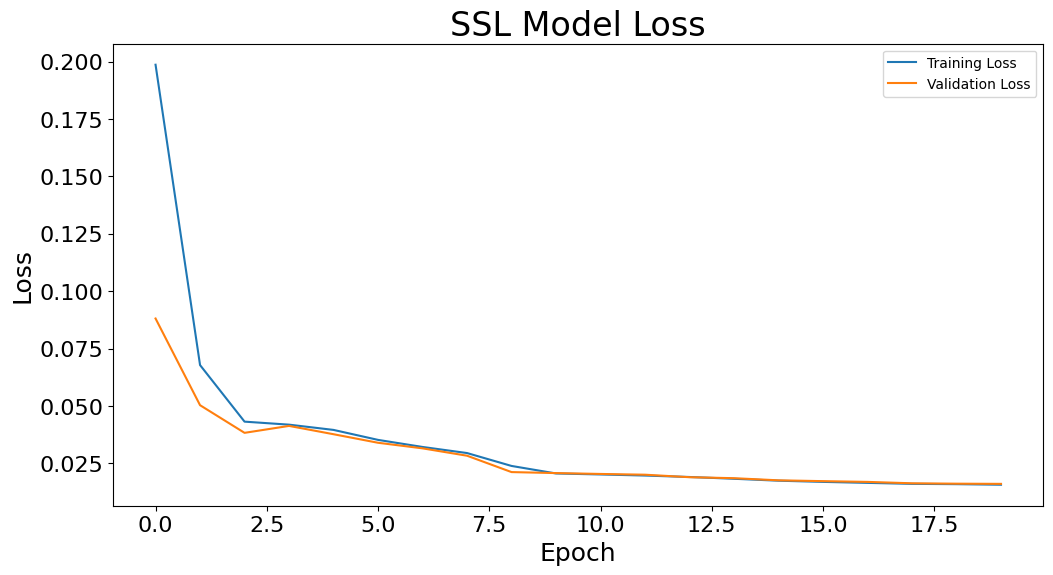

In [70]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(ssl_history.history['loss'], label='Training Loss')
if 'val_loss' in ssl_history.history:
    plt.plot(ssl_history.history['val_loss'], label='Validation Loss')
plt.title('SSL Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


In [71]:
def filter_data_with_ssl(ssl_model, X_data, NON_EMPTY_FRAME_IDXS_DATA, y_data, initial_threshold=None, top_k=None, dynamic_factor=0.1):
    """
    Filter data using SSL model by selecting samples with the lowest reconstruction error, incorporating dynamic thresholding.

    Args:
    - ssl_model: Trained SSL model.
    - X_data: Input data to be filtered (e.g., X_train).
    - NON_EMPTY_FRAME_IDXS_DATA: Corresponding non-empty frame indices for the input data.
    - y_data: Labels corresponding to the input data.
    - initial_threshold: Initial threshold for selecting samples based on reconstruction error.
    - top_k: Optional; select the top k samples with the lowest reconstruction error.
    - dynamic_factor: Factor to dynamically adjust the threshold. A smaller value results in stricter filtering.

    Returns:
    - filtered_X_data: Filtered data with low reconstruction error.
    - filtered_non_empty_frame_idxs: Corresponding non-empty frame indices for the filtered data.
    - filtered_y_data: Corresponding labels for the filtered data.
    - errors: Array of reconstruction errors for each sample.
    """

    # Get SSL model predictions (reconstruction)
    reconstructed_data = ssl_model.predict({'frames': X_data, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_DATA})
    
    # Compute reconstruction error for each sample
    errors = np.mean(np.square(X_data - reconstructed_data), axis=(1, 2, 3))

    # Dynamic Thresholding: Adjust threshold based on error distribution
    if initial_threshold is not None:
        dynamic_threshold = initial_threshold
        selected_indices = np.where(errors < dynamic_threshold)[0]
        
        # Dynamically adjust the threshold until a reasonable number of samples are selected
        while len(selected_indices) < (len(X_data) * 0.05):  # Ensure at least 5% of data is selected
            dynamic_threshold += dynamic_factor * np.std(errors)
            selected_indices = np.where(errors < dynamic_threshold)[0]
    elif top_k is not None:
        selected_indices = np.argsort(errors)[:top_k]
    else:
        raise ValueError("Either 'initial_threshold' or 'top_k' must be provided.")
    
    # Filter the data
    filtered_X_data = X_data[selected_indices]
    filtered_non_empty_frame_idxs = NON_EMPTY_FRAME_IDXS_DATA[selected_indices]
    filtered_y_data = y_data[selected_indices]
    
    return filtered_X_data, filtered_non_empty_frame_idxs, filtered_y_data, errors


In [72]:
filtered_X_data, filtered_non_empty_frame_idxs, filtered_y_data, errors = filter_data_with_ssl(
    ssl_model, X_train, NON_EMPTY_FRAME_IDXS_TRAIN, y_train, top_k=5000  # Select top 5000 samples with the lowest error
)

print(f"Filtered data size: {filtered_X_data.shape[0]}")

  1/157 [..............................] - ETA: 3:15

  5/157 [..............................] - ETA: 2s  

  9/157 [>.............................] - ETA: 2s

 13/157 [=>............................] - ETA: 2s

 17/157 [==>...........................] - ETA: 2s

 21/157 [===>..........................] - ETA: 2s

 25/157 [===>..........................] - ETA: 2s

 29/157 [====>.........................] - ETA: 2s

 33/157 [=====>........................] - ETA: 1s

 37/157 [======>.......................] - ETA: 1s

 41/157 [======>.......................] - ETA: 1s

 45/157 [=======>......................] - ETA: 1s

 49/157 [========>.....................] - ETA: 1s

 53/157 [=========>....................] - ETA: 1s

 57/157 [=========>....................] - ETA: 1s

 61/157 [==========>...................] - ETA: 1s

 65/157 [===========>..................] - ETA: 1s

 69/157 [============>.................] - ETA: 1s

 73/157 [============>.................] - ETA: 1s

 77/157 [=============>................] - ETA: 1s

 81/157 [==============>...............] - ETA: 1s

 85/157 [===============>..............] - ETA: 1s

 89/157 [================>.............] - ETA: 1s

 93/157 [================>.............] - ETA: 1s

 97/157 [=================>............] - ETA: 0s

101/157 [==================>...........] - ETA: 0s

105/157 [===================>..........] - ETA: 0s

109/157 [===================>..........] - ETA: 0s

113/157 [====================>.........] - ETA: 0s

117/157 [=====================>........] - ETA: 0s

121/157 [======================>.......] - ETA: 0s

125/157 [======================>.......] - ETA: 0s

129/157 [=======================>......] - ETA: 0s

133/157 [========================>.....] - ETA: 0s

137/157 [=========================>....] - ETA: 0s

141/157 [=========================>....] - ETA: 0s

145/157 [==========================>...] - ETA: 0s

149/157 [===========================>..] - ETA: 0s

153/157 [============================>.] - ETA: 0s

157/157 [==============================] - ETA: 0s

157/157 [==============================] - 4s 16ms/step


Filtered data size: 5000


# No NaN Predictions

In [73]:
# if not PREPROCESS_DATA and TRAIN_MODEL:
#     y_pred = model.predict_on_batch(X_batch).flatten()

#     print(f'# NaN Values In Prediction: {np.isnan(y_pred).sum()}')

# Weight Initialization

In [74]:
# if not PREPROCESS_DATA and TRAIN_MODEL:
#     plt.figure(figsize=(12,5))
#     plt.title(f'Softmax Output Initialized Model | µ={y_pred.mean():.3f}, σ={y_pred.std():.3f}', pad=25)
#     pd.Series(y_pred).plot(kind='hist', bins=128, label='Class Probability')
#     plt.xlim(0, max(y_pred) * 1.1)
#     plt.vlines([1 / NUM_CLASSES], 0, plt.ylim()[1], color='red', label=f'Random Guessing Baseline 1/NUM_CLASSES={1 / NUM_CLASSES:.3f}')
#     plt.grid()
#     plt.legend()
#     plt.show()

# Learning Rate Scheduler

In [75]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        if WARMUP_METHOD == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

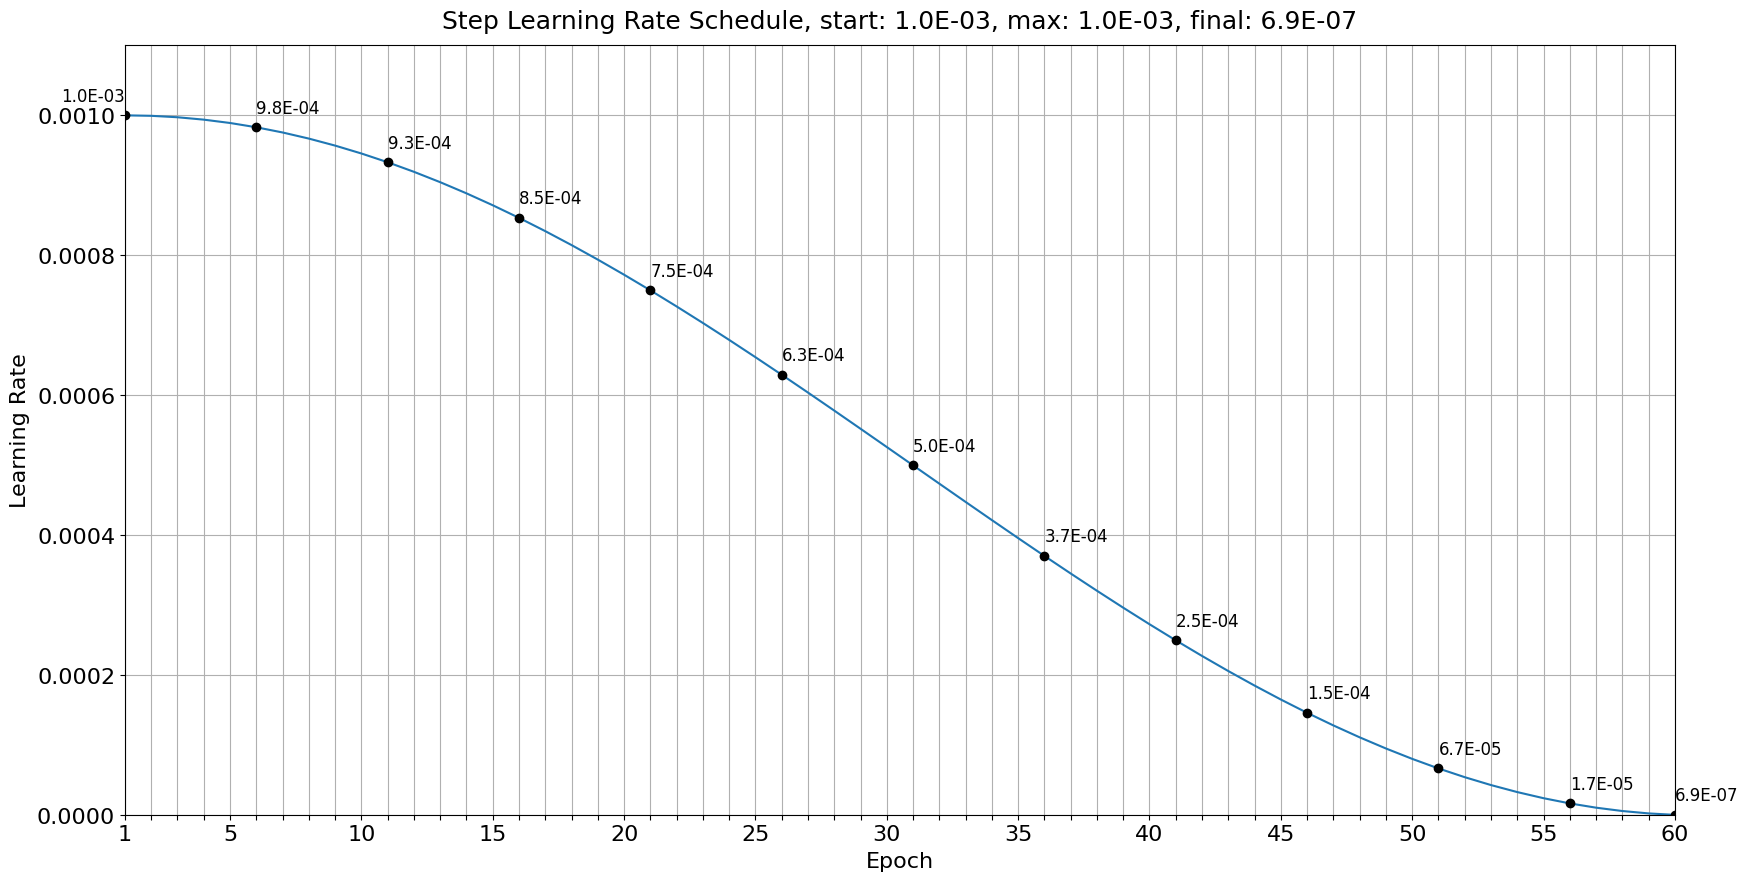

In [76]:
def plot_lr_schedule(lr_schedule, epochs):
    fig = plt.figure(figsize=(20, 10))
    plt.plot([None] + lr_schedule + [None])
    # X Labels
    x = np.arange(1, epochs + 1)
    x_axis_labels = [i if epochs <= 40 or i % 5 == 0 or i == 1 else None for i in range(1, epochs + 1)]
    plt.xlim([1, epochs])
    plt.xticks(x, x_axis_labels) # set tick step to 1 and let x axis start at 1
    
    # Increase y-limit for better readability
    plt.ylim([0, max(lr_schedule) * 1.1])
    
    # Title
    schedule_info = f'start: {lr_schedule[0]:.1E}, max: {max(lr_schedule):.1E}, final: {lr_schedule[-1]:.1E}'
    plt.title(f'Step Learning Rate Schedule, {schedule_info}', size=18, pad=12)
    
    # Plot Learning Rates
    for x, val in enumerate(lr_schedule):
        if epochs <= 40 or x % 5 == 0 or x is epochs - 1:
            if x < len(lr_schedule) - 1:
                if lr_schedule[x - 1] < val:
                    ha = 'right'
                else:
                    ha = 'left'
            elif x == 0:
                ha = 'right'
            else:
                ha = 'left'
            plt.plot(x + 1, val, 'o', color='black');
            offset_y = (max(lr_schedule) - min(lr_schedule)) * 0.02
            plt.annotate(f'{val:.1E}', xy=(x + 1, val + offset_y), size=12, ha=ha)
    
    plt.xlabel('Epoch', size=16, labelpad=5)
    plt.ylabel('Learning Rate', size=16, labelpad=5)
    plt.grid()
    plt.show()

# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]
# Plot Learning Rate Schedule
plot_lr_schedule(LR_SCHEDULE, epochs=N_EPOCHS)
# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Weight Decay Callback

In [77]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Performance Benchmark

In [78]:
%%timeit -n 100
if TRAIN_MODEL:
    # Verify model prediction is <<<100ms
    model.predict_on_batch({ 'frames': X_train[:1], 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TRAIN[:1] })
    pass

11.6 ms ± 2.21 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Training

In [79]:
if USE_VAL:
    # Verify Validation Dataset Covers All Signs
    print(f'# Unique Signs in Validation Set: {pd.Series(y_val).nunique()}')
    # Value Counts
    display(pd.Series(y_val).value_counts().to_frame('Count').iloc[[1,2,3,-3,-2,-1]])

# Evaluate Initialzied Model

In [80]:
# Sanity Check
if TRAIN_MODEL and USE_VAL:
    _ = model.evaluate(*validation_data, verbose=2)

# Train

In [81]:
class KerasClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        self.model.fit(X, y, verbose=0, batch_size=10, epochs=10)

    def predict_proba(self, X):
        return self.model.predict(X)
    
    def predict(self, X, **kwargs):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y, **kwargs):
        # Evaluates using the first element of the tuple for frames and the second for indexes
        return self.model.evaluate([X[0], X[1]], y, **kwargs)[1] 

In [82]:
class DetailedAccuracyLogger(tf.keras.callbacks.Callback):
    def __init__(self, used_samples=None, check_frequency=50):
        super().__init__()
        self.used_samples = used_samples
        self.check_frequency = check_frequency
        self.reset()
        
    def reset(self):
        self.first_full_usage_accuracy = None
        self.first_full_usage_batch = None
        self.all_data_used = False
        if self.used_samples is not None:
            self.used_samples.fill(False)  # Reset all values to False
        self.step_accuracy = []  # Reset step accuracy history
        self.coverage_history = []  # Reset coverage history

    def on_train_begin(self, logs=None):
        self.step_accuracy = []
        self.coverage_history = []

    def on_batch_end(self, batch, logs=None):
        if logs is not None:
            accuracy = logs.get('acc')
            if accuracy is not None:
                self.step_accuracy.append(accuracy)
                print(f"Batch {batch + 1} accuracy: {accuracy}")  # Debug print
                
        if self.used_samples is not None and (batch + 1) % self.check_frequency == 0:
            coverage = np.mean(self.used_samples) * 100
            self.coverage_history.append(coverage)
            print(f"Coverage after batch {batch + 1}: {coverage:.2f}%")

    def on_epoch_end(self, epoch, logs=None):
        if self.used_samples is not None:
            coverage = np.mean(self.used_samples) * 100
            self.coverage_history.append(coverage)
            print(f"Coverage at end of epoch {epoch + 1}: {coverage:.2f}%")

In [83]:
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, used_samples):
    # Check if there are enough samples to form a batch
    if len(X) < batch_size:
        raise ValueError("Not enough samples to form a batch.")

    # Select indices for the batch
    indices = np.random.choice(len(X), size=batch_size, replace=False)
    
    # Extract data for the batch
    X_batch = X[indices]
    y_batch = y[indices]
    non_empty_frame_idxs_batch = NON_EMPTY_FRAME_IDXS[indices]
    
    # Store indices in temp_storage for later removal from main set
    temp_storage.extend(indices.tolist())
    
    # Prepare the dictionary for model inputs
    batch_data = {'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch}
    
    return batch_data, y_batch


In [84]:
def update_train_AL(X_train_AL, y_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL,
                    X_train, NON_EMPTY_FRAME_IDXS_TRAIN, y_train, 
                    used_samples, model, batch_size):
    # Use custom_query to select new samples for active learning
    new_indices, selected_X, selected_non_empty_frame_idxs, selected_y = custom_query(
        model, X_train, NON_EMPTY_FRAME_IDXS_TRAIN, y_train, 
        batch_size=batch_size
    )

    # Add the selected samples to the active learning subset
    X_train_AL = np.concatenate([X_train_AL, selected_X], axis=0)
    y_train_AL = np.concatenate([y_train_AL, selected_y], axis=0)
    NON_EMPTY_FRAME_IDXS_TRAIN_AL = np.concatenate([NON_EMPTY_FRAME_IDXS_TRAIN_AL, selected_non_empty_frame_idxs], axis=0)

    # Update used_samples to reflect the newly used samples
    used_samples[new_indices] = True

    # Print outputs to monitor progress
    print("Selected indices:", new_indices)
    print("Size of X_train_AL:", X_train_AL.shape)
    print("Size of y_train_AL:", y_train_AL.shape)

    return X_train_AL, y_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL, used_samples, new_indices, selected_X, selected_y, selected_non_empty_frame_idxs


In [85]:
def distribute_batches(X_train, X_train_subset, selected_X, steps_per_epoch, batch_size):
    import numpy as np
    
    # Calculate the number of batches required for selected_X
    selected_batches = int(np.ceil(len(selected_X) / batch_size)) - 1
    
    # Calculate the remaining steps after selected_X has been processed
    remaining_steps = steps_per_epoch - selected_batches
    
    # Calculate the proportion of batches to allocate to X_train and X_train_subset
    total_data = len(X_train) + len(X_train_subset)
    X_train_batches = int(np.floor((len(X_train) / total_data) * remaining_steps))
    X_train_subset_batches = remaining_steps - X_train_batches
    
#     # Print out the batch distribution information (this can be removed if not needed)
#     print(f'Selected_X will use {selected_batches} batches.')
#     print(f'X_train will use {X_train_batches} batches out of remaining {remaining_steps} steps.')
#     print(f'X_train_subset will use {X_train_subset_batches} batches.')

    # Update X_train and X_train_subset based on selected_X
    # Assume selected_X indices are known
    indices_to_move = np.random.choice(len(X_train), size=len(selected_X), replace=False)
    X_train_subset = np.append(X_train_subset, X_train[indices_to_move])
    X_train = np.delete(X_train, indices_to_move)

    # Return the number of batches for selected_X, X_train, and X_train_subset
    return selected_batches, X_train_batches, X_train_subset_batches

In [86]:
def clear_gpu_memory():
    from numba import cuda
    device = cuda.get_current_device()
    device.reset()

In [87]:
def fill_missing_classes(selected_X, selected_y, selected_NON_EMPTY_FRAME_IDXS,
                         X_train_subset, y_train_subset, NON_EMPTY_FRAME_IDXS_TRAIN_subset, n):
    # Calculate the current distribution of classes in selected_X
    unique, counts = np.unique(selected_y, return_counts=True)
    class_distribution = dict(zip(unique, counts))

    # Ensure every class has at least 'n' samples
    for class_id in range(NUM_CLASSES):
        current_count = class_distribution.get(class_id, 0)
        needed_samples = n - current_count
        
        if needed_samples > 0:
            # Find indices of the needed class in X_train_subset
            class_indices = np.where(y_train_subset == class_id)[0]

            if len(class_indices) < needed_samples:
                print(f"Not enough samples available in subset for class {class_id}. Needed: {needed_samples}, Available: {len(class_indices)}")
                # Optionally, handle the case where not enough samples are available
                if len(class_indices) > 0:  # Only if some samples are available
                    selected_indices = np.random.choice(class_indices, needed_samples, replace=True)
                else:
                    continue  # Skip if no samples are available at all
            else:
                selected_indices = np.random.choice(class_indices, needed_samples, replace=False)

            # Append these samples to selected_X and related arrays
            selected_X = np.concatenate([selected_X, X_train_subset[selected_indices]])
            selected_y = np.concatenate([selected_y, y_train_subset[selected_indices]])
            selected_NON_EMPTY_FRAME_IDXS = np.concatenate([selected_NON_EMPTY_FRAME_IDXS, NON_EMPTY_FRAME_IDXS_TRAIN_subset[selected_indices]])

    return selected_X, selected_y, selected_NON_EMPTY_FRAME_IDXS


In [88]:
def get_train_batch_all_signs_ori(X, y, NON_EMPTY_FRAME_IDXS, used_samples, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)

    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
            
            # Update used_samples for the selected indices
            used_samples[idxs] = True
    # Prepare the dictionary for model inputs
        batch_data = {'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch}
    
        yield batch_data, y_batch


In [89]:
def settle_epoch_data(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN,
                      X_train_subset, y_train_subset, NON_EMPTY_FRAME_IDXS_TRAIN_subset,
                      temp_storage):
    # Convert to numpy arrays for advanced indexing
    indices_to_remove = np.array(temp_storage)
    
    # Add the selected data to the subsets
    X_train_subset = np.append(X_train_subset, X_train[indices_to_remove], axis=0)
    y_train_subset = np.append(y_train_subset, y_train[indices_to_remove], axis=0)
    NON_EMPTY_FRAME_IDXS_TRAIN_subset = np.append(NON_EMPTY_FRAME_IDXS_TRAIN_subset, NON_EMPTY_FRAME_IDXS_TRAIN[indices_to_remove], axis=0)

    # Remove the selected data from the main sets
    mask = np.ones(len(X_train), dtype=bool)
    mask[indices_to_remove] = False
    X_train = X_train[mask]
    y_train = y_train[mask]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS_TRAIN[mask]

    # Clear temp_storage for the next epoch
    temp_storage.clear()

    return X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, X_train_subset, y_train_subset, NON_EMPTY_FRAME_IDXS_TRAIN_subset


In [90]:
def update_used_samples_from_subset(used_samples_full, subset_indices):
    """
    Marks indices from X_train_subset as used in used_samples_full.

    Args:
    used_samples_full (np.array): The array tracking used samples in X_train.
    subset_indices (list or np.array): Indices of samples in X_train_subset that originated from X_train.
    """
    # Mark the indices as used in the used_samples_full array
    for idx in subset_indices:
        if idx < len(used_samples_full):
            used_samples_full[idx] = True
        else:
            print(f"Warning: Index {idx} is out of the bounds of the used_samples_full array.")


In [91]:
def dynamic_batch_generator(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN,
                            X_train_AL, y_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL,
                            used_samples_full, current_epoch, max_active_learning_batches=20):
    current_step = 1
    last_epoch = [-1]
    total_steps = len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N)

    while True:
        if current_epoch[0] != last_epoch[0]:
            current_step = 1
            last_epoch[0] = current_epoch[0]
            print(f"Epoch change detected. Resetting batch generator for Epoch {current_epoch[0] + 1}.")

        if current_step <= 1 and len(X_train_AL) > 0:
            data_source = X_train_AL
            labels_source = y_train_AL
            non_empty_frame_idxs_source = NON_EMPTY_FRAME_IDXS_TRAIN_AL
            source_name = 'X_train_AL'
            indices = np.arange(len(data_source))  # Use all indices since the batch size matches

            # Extract data for the batch
            X_batch = data_source[indices]
            y_batch = labels_source[indices]
            non_empty_frame_idxs_batch = non_empty_frame_idxs_source[indices]

            # Prepare the dictionary for model inputs
            batch_data = {'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch}

        else:
            # Use get_train_batch_all_signs_ori to get the batch
            batch_data, y_batch = next(get_train_batch_all_signs_ori(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN, used_samples_full))
            source_name = 'X_train'

#         print(f"Using data source: {source_name}, step: {current_step}/{total_steps}")
#         print(f"Data source size: {len(data_source)}")
#         print(f"Labels source size: {len(labels_source)}")
#         print(f"Current step: {current_step}")

        # Yield the batch
        yield batch_data, y_batch

        # Increment the step or reset based on total batches needed
        current_step += 1
        if current_step > total_steps:
            current_step = 1

In [92]:
# selected_X, selected_y, selected_NON_EMPTY_FRAME_IDXS = fill_missing_classes(
#     selected_X, selected_y, selected_non_empty_frame_idxs,
#     X_train_subset, y_train_subset, NON_EMPTY_FRAME_IDXS_TRAIN_subset, BATCH_ALL_SIGNS_N)


In [93]:
del model
# clear_gpu_memory()

if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get a fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()
    
    used_samples_ori = np.zeros(len(X_train_ori), dtype=bool)
    initial_epochs = N_EPOCHS // 2  # First half of the total epochs
    
    # Initialize variables to track final accuracy and batch count
    final_accuracy_initial = None
    steps_per_epoch = len(X_train_ori) // (NUM_CLASSES * BATCH_ALL_SIGNS_N)
    
    # Calculate total steps for the entire training process
    total_steps = N_EPOCHS * steps_per_epoch

    # Initialize LR_SCHEDULE for all steps
    LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(total_steps)]
    
    # Determine the number of steps for the initial half of the training
    initial_steps = initial_epochs * steps_per_epoch

    # Use the learning rate schedule for the initial training
    LR_SCHEDULE_INITIAL = LR_SCHEDULE[:initial_steps]  # First half of the LR schedule

    # Update the Learning Rate Callback for the initial training
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE_INITIAL[step], verbose=1)
    
    # # Use the learning rate schedule for the initial training
    # LR_SCHEDULE_INITIAL = LR_SCHEDULE[:initial_epochs]  # First half of the LR schedule

    # # Update the Learning Rate Callback for the initial training
    # lr_callback = tf.keras.callbacks.LearningRateScheduler(
    #     lambda step: LR_SCHEDULE_INITIAL[step], verbose=1
    # )
    
    history = model.fit(
        x=get_train_batch_all_signs_ori(X_train_ori, y_train_ori, NON_EMPTY_FRAME_IDXS_TRAIN_ori, used_samples_ori),
        steps_per_epoch=steps_per_epoch,
        epochs=initial_epochs,
        # Only used for validation data since training data is a generator
        batch_size=BATCH_SIZE,
        validation_data=validation_data,
        callbacks=[
            lr_callback,
            WeightDecayCallback()
        ],
        verbose=VERBOSE,
    )

    print("Finished training")
    
    # Capture and log the final accuracy of the initial training phase
    final_accuracy_initial = history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else None
    
    if final_accuracy_initial is not None:
        print(f"Final Validation Accuracy: {final_accuracy_initial:.4f}")
    else:
        print("Validation accuracy was not tracked during training.")
    
    # Log the total number of batches used during the initial phase
    print(f"Total Batches Used: {steps_per_epoch * initial_epochs}")
    
    # Specify the save directory
    save_dir = '/home/f26273/data_enalisn1/GISLR'
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Save the model weights after the initial training
    weights_save_path = os.path.join(save_dir, 'initial_trained_weights.h5')
    model.save_weights(weights_save_path)
    print(f"Model weights saved at: {weights_save_path}")


Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               


 er)                                                                                              


 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   


 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      


 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']                


 frames (InputLayer)            [(None, 64, 66, 3)]  0           []                               


 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['tf.expand_dims[0][0]']         


 )                                                                                                


 tf.slice (TFOpLambda)          (None, 64, 66, 2)    0           ['frames[0][0]']                 


 tf.random.uniform (TFOpLambda)  (None, 64, 1)       0           ['tf.compat.v1.shape[0][0]']     


 tf.slice_1 (TFOpLambda)        (None, 64, 40, 2)    0           ['tf.slice[0][0]']               


 tf.slice_2 (TFOpLambda)        (None, 64, 21, 2)    0           ['tf.slice[0][0]']               


 tf.slice_3 (TFOpLambda)        (None, 64, 5, 2)     0           ['tf.slice[0][0]']               


 tf.math.greater (TFOpLambda)   (None, 64, 1)        0           ['tf.random.uniform[0][0]']      


 tf.math.not_equal_1 (TFOpLambd  (None, 64, 1)       0           ['tf.expand_dims[0][0]']         


 a)                                                                                               


 tf.math.subtract (TFOpLambda)  (None, 64, 40, 2)    0           ['tf.slice_1[0][0]']             


 tf.math.subtract_1 (TFOpLambda  (None, 64, 21, 2)   0           ['tf.slice_2[0][0]']             


 )                                                                                                


 tf.math.subtract_2 (TFOpLambda  (None, 64, 5, 2)    0           ['tf.slice_3[0][0]']             


 )                                                                                                


 tf.math.logical_and (TFOpLambd  (None, 64, 1)       0           ['tf.math.greater[0][0]',        


 a)                                                               'tf.math.not_equal_1[0][0]']    


 tf.math.equal_1 (TFOpLambda)   (None, 64, 40, 2)    0           ['tf.slice_1[0][0]']             


 tf.math.truediv (TFOpLambda)   (None, 64, 40, 2)    0           ['tf.math.subtract[0][0]']       


 tf.math.equal_2 (TFOpLambda)   (None, 64, 21, 2)    0           ['tf.slice_2[0][0]']             


 tf.math.truediv_1 (TFOpLambda)  (None, 64, 21, 2)   0           ['tf.math.subtract_1[0][0]']     


 tf.math.equal_3 (TFOpLambda)   (None, 64, 5, 2)     0           ['tf.slice_3[0][0]']             


 tf.math.truediv_2 (TFOpLambda)  (None, 64, 5, 2)    0           ['tf.math.subtract_2[0][0]']     


 tf.where (TFOpLambda)          (None, 64, 1)        0           ['tf.math.logical_and[0][0]']    


 tf.where_2 (TFOpLambda)        (None, 64, 40, 2)    0           ['tf.math.equal_1[0][0]',        


                                                                  'tf.math.truediv[0][0]']        


 tf.where_3 (TFOpLambda)        (None, 64, 21, 2)    0           ['tf.math.equal_2[0][0]',        


                                                                  'tf.math.truediv_1[0][0]']      


 tf.where_4 (TFOpLambda)        (None, 64, 5, 2)     0           ['tf.math.equal_3[0][0]',        


                                                                  'tf.math.truediv_2[0][0]']      


 tf.math.reduce_sum (TFOpLambda  (None, 1, 1)        0           ['tf.where[0][0]']               


 )                                                                                                


 tf.reshape (TFOpLambda)        (None, 64, 80)       0           ['tf.where_2[0][0]']             


 tf.reshape_1 (TFOpLambda)      (None, 64, 42)       0           ['tf.where_3[0][0]']             


 tf.reshape_2 (TFOpLambda)      (None, 64, 10)       0           ['tf.where_4[0][0]']             


 tf.math.equal (TFOpLambda)     (None, 1, 1)         0           ['tf.math.reduce_sum[0][0]']     


 embedding (Embedding)          (None, 64, 512)      986243      ['tf.reshape[0][0]',             


                                                                  'tf.reshape_1[0][0]',           


                                                                  'tf.reshape_2[0][0]',           


                                                                  'non_empty_frame_idxs[0][0]']   


 tf.where_1 (TFOpLambda)        (None, 64, 1)        0           ['tf.math.equal[0][0]',          


                                                                  'tf.expand_dims[0][0]',         


                                                                  'tf.where[0][0]']               


 transformer (Transformer)      (None, 64, 512)      4201472     ['embedding[0][0]',              


                                                                  'tf.where_1[0][0]']             


 tf.math.multiply (TFOpLambda)  (None, 64, 512)      0           ['transformer[0][0]',            


                                                                  'tf.where_1[0][0]']             


 tf.math.reduce_sum_1 (TFOpLamb  (None, 512)         0           ['tf.math.multiply[0][0]']       


 da)                                                                                              


 tf.math.reduce_sum_2 (TFOpLamb  (None, 1)           0           ['tf.where_1[0][0]']             


 da)                                                                                              


 tf.math.truediv_3 (TFOpLambda)  (None, 512)         0           ['tf.math.reduce_sum_1[0][0]',   


                                                                  'tf.math.reduce_sum_2[0][0]']   


 dropout (Dropout)              (None, 512)          0           ['tf.math.truediv_3[0][0]']      


 dense (Dense)                  (None, 250)          128250      ['dropout[0][0]']                


Total params: 5,315,965


Trainable params: 5,315,965


Non-trainable params: 0


__________________________________________________________________________________________________



Epoch 1: LearningRateScheduler setting learning rate to 0.001.


learning rate: 1.00e-03, weight decay: 5.00e-05
Epoch 1/30


1/5 [=====>........................] - ETA: 33s - loss: 5.5487 - acc: 0.0020

2/5 [===========>..................] - ETA: 1s - loss: 5.5092 - acc: 0.0070 

3/5 [=================>............] - ETA: 0s - loss: 5.4771 - acc: 0.0090

4/5 [=======================>......] - ETA: 0s - loss: 5.4522 - acc: 0.0130

5/5 [==============================] - ETA: 0s - loss: 5.4231 - acc: 0.0174

5/5 [==============================] - 10s 410ms/step - loss: 5.4231 - acc: 0.0174 - lr: 0.0010



Epoch 2: LearningRateScheduler setting learning rate to 0.0009993147673772868.


learning rate: 9.99e-04, weight decay: 5.00e-05
Epoch 2/30


1/5 [=====>........................] - ETA: 1s - loss: 5.2879 - acc: 0.0420

2/5 [===========>..................] - ETA: 1s - loss: 5.2741 - acc: 0.0425

3/5 [=================>............] - ETA: 0s - loss: 5.2577 - acc: 0.0423

4/5 [=======================>......] - ETA: 0s - loss: 5.2373 - acc: 0.0457

5/5 [==============================] - ETA: 0s - loss: 5.2111 - acc: 0.0476

5/5 [==============================] - 2s 410ms/step - loss: 5.2111 - acc: 0.0476 - lr: 9.9931e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0009972609476841367.


learning rate: 9.97e-04, weight decay: 4.99e-05
Epoch 3/30


1/5 [=====>........................] - ETA: 1s - loss: 5.0977 - acc: 0.0690

2/5 [===========>..................] - ETA: 1s - loss: 5.0669 - acc: 0.0675

3/5 [=================>............] - ETA: 0s - loss: 5.0401 - acc: 0.0723

4/5 [=======================>......] - ETA: 0s - loss: 5.0269 - acc: 0.0750

5/5 [==============================] - ETA: 0s - loss: 5.0144 - acc: 0.0744

5/5 [==============================] - 2s 410ms/step - loss: 5.0144 - acc: 0.0744 - lr: 9.9726e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.0009938441702975688.


learning rate: 9.94e-04, weight decay: 4.97e-05
Epoch 4/30


1/5 [=====>........................] - ETA: 1s - loss: 4.8664 - acc: 0.1060

2/5 [===========>..................] - ETA: 1s - loss: 4.8901 - acc: 0.1010

3/5 [=================>............] - ETA: 0s - loss: 4.8948 - acc: 0.1023

4/5 [=======================>......] - ETA: 0s - loss: 4.8834 - acc: 0.1058

5/5 [==============================] - ETA: 0s - loss: 4.8724 - acc: 0.1058

5/5 [==============================] - 2s 410ms/step - loss: 4.8724 - acc: 0.1058 - lr: 9.9384e-04



Epoch 5: LearningRateScheduler setting learning rate to 0.0009890738003669028.


learning rate: 9.89e-04, weight decay: 4.95e-05
Epoch 5/30


1/5 [=====>........................] - ETA: 1s - loss: 4.7844 - acc: 0.1280

2/5 [===========>..................] - ETA: 1s - loss: 4.7622 - acc: 0.1320

3/5 [=================>............] - ETA: 0s - loss: 4.7548 - acc: 0.1353

4/5 [=======================>......] - ETA: 0s - loss: 4.7407 - acc: 0.1353

5/5 [==============================] - ETA: 0s - loss: 4.7334 - acc: 0.1364

5/5 [==============================] - 2s 410ms/step - loss: 4.7334 - acc: 0.1364 - lr: 9.8907e-04



Epoch 6: LearningRateScheduler setting learning rate to 0.0009829629131445341.


learning rate: 9.83e-04, weight decay: 4.91e-05
Epoch 6/30


1/5 [=====>........................] - ETA: 1s - loss: 4.6614 - acc: 0.1520

2/5 [===========>..................] - ETA: 1s - loss: 4.6434 - acc: 0.1605

3/5 [=================>............] - ETA: 0s - loss: 4.6359 - acc: 0.1590

4/5 [=======================>......] - ETA: 0s - loss: 4.6336 - acc: 0.1590

5/5 [==============================] - ETA: 0s - loss: 4.6107 - acc: 0.1658

5/5 [==============================] - 2s 410ms/step - loss: 4.6107 - acc: 0.1658 - lr: 9.8296e-04



Epoch 7: LearningRateScheduler setting learning rate to 0.0009755282581475768.


learning rate: 9.76e-04, weight decay: 4.88e-05
Epoch 7/30


1/5 [=====>........................] - ETA: 1s - loss: 4.5513 - acc: 0.2050

2/5 [===========>..................] - ETA: 1s - loss: 4.5191 - acc: 0.2050

3/5 [=================>............] - ETA: 0s - loss: 4.5113 - acc: 0.2037

4/5 [=======================>......] - ETA: 0s - loss: 4.4913 - acc: 0.2072

5/5 [==============================] - ETA: 0s - loss: 4.4832 - acc: 0.2104

5/5 [==============================] - 2s 410ms/step - loss: 4.4832 - acc: 0.2104 - lr: 9.7553e-04



Epoch 8: LearningRateScheduler setting learning rate to 0.0009667902132486009.


learning rate: 9.67e-04, weight decay: 4.83e-05
Epoch 8/30


1/5 [=====>........................] - ETA: 1s - loss: 4.3970 - acc: 0.2340

2/5 [===========>..................] - ETA: 1s - loss: 4.3958 - acc: 0.2370

3/5 [=================>............] - ETA: 0s - loss: 4.3908 - acc: 0.2393

4/5 [=======================>......] - ETA: 0s - loss: 4.3750 - acc: 0.2438

5/5 [==============================] - ETA: 0s - loss: 4.3670 - acc: 0.2450

5/5 [==============================] - 2s 410ms/step - loss: 4.3670 - acc: 0.2450 - lr: 9.6679e-04



Epoch 9: LearningRateScheduler setting learning rate to 0.0009567727288213005.


learning rate: 9.57e-04, weight decay: 4.78e-05
Epoch 9/30


1/5 [=====>........................] - ETA: 1s - loss: 4.2426 - acc: 0.2760

2/5 [===========>..................] - ETA: 1s - loss: 4.2622 - acc: 0.2635

3/5 [=================>............] - ETA: 0s - loss: 4.2441 - acc: 0.2693

4/5 [=======================>......] - ETA: 0s - loss: 4.2354 - acc: 0.2730

5/5 [==============================] - ETA: 0s - loss: 4.2263 - acc: 0.2784

5/5 [==============================] - 2s 410ms/step - loss: 4.2263 - acc: 0.2784 - lr: 9.5677e-04



Epoch 10: LearningRateScheduler setting learning rate to 0.0009455032620941839.


learning rate: 9.46e-04, weight decay: 4.73e-05
Epoch 10/30


1/5 [=====>........................] - ETA: 1s - loss: 4.1903 - acc: 0.2940

2/5 [===========>..................] - ETA: 1s - loss: 4.1262 - acc: 0.3075

3/5 [=================>............] - ETA: 0s - loss: 4.1298 - acc: 0.3077

4/5 [=======================>......] - ETA: 0s - loss: 4.1281 - acc: 0.3108

5/5 [==============================] - ETA: 0s - loss: 4.1342 - acc: 0.3082

5/5 [==============================] - 2s 410ms/step - loss: 4.1342 - acc: 0.3082 - lr: 9.4550e-04



Epoch 11: LearningRateScheduler setting learning rate to 0.0009330127018922195.


learning rate: 9.33e-04, weight decay: 4.67e-05
Epoch 11/30


1/5 [=====>........................] - ETA: 1s - loss: 4.0332 - acc: 0.3460

2/5 [===========>..................] - ETA: 1s - loss: 4.0471 - acc: 0.3380

3/5 [=================>............] - ETA: 0s - loss: 4.0349 - acc: 0.3433

4/5 [=======================>......] - ETA: 0s - loss: 4.0252 - acc: 0.3430

5/5 [==============================] - ETA: 0s - loss: 4.0100 - acc: 0.3488

5/5 [==============================] - 2s 410ms/step - loss: 4.0100 - acc: 0.3488 - lr: 9.3301e-04



Epoch 12: LearningRateScheduler setting learning rate to 0.0009193352839727121.


learning rate: 9.19e-04, weight decay: 4.60e-05
Epoch 12/30


1/5 [=====>........................] - ETA: 1s - loss: 3.9921 - acc: 0.3610

2/5 [===========>..................] - ETA: 1s - loss: 3.9645 - acc: 0.3585

3/5 [=================>............] - ETA: 0s - loss: 3.9549 - acc: 0.3730

4/5 [=======================>......] - ETA: 0s - loss: 3.9338 - acc: 0.3780

5/5 [==============================] - ETA: 0s - loss: 3.9214 - acc: 0.3858

5/5 [==============================] - 2s 410ms/step - loss: 3.9214 - acc: 0.3858 - lr: 9.1934e-04



Epoch 13: LearningRateScheduler setting learning rate to 0.0009045084971874737.


learning rate: 9.05e-04, weight decay: 4.52e-05
Epoch 13/30


1/5 [=====>........................] - ETA: 1s - loss: 3.8792 - acc: 0.3800

2/5 [===========>..................] - ETA: 1s - loss: 3.8678 - acc: 0.3945

3/5 [=================>............] - ETA: 0s - loss: 3.8377 - acc: 0.4123

4/5 [=======================>......] - ETA: 0s - loss: 3.8227 - acc: 0.4187

5/5 [==============================] - ETA: 0s - loss: 3.8086 - acc: 0.4234

5/5 [==============================] - 2s 410ms/step - loss: 3.8086 - acc: 0.4234 - lr: 9.0451e-04



Epoch 14: LearningRateScheduler setting learning rate to 0.0008885729807284854.


learning rate: 8.89e-04, weight decay: 4.44e-05
Epoch 14/30


1/5 [=====>........................] - ETA: 1s - loss: 3.7576 - acc: 0.4500

2/5 [===========>..................] - ETA: 1s - loss: 3.7645 - acc: 0.4350

3/5 [=================>............] - ETA: 0s - loss: 3.7435 - acc: 0.4423

4/5 [=======================>......] - ETA: 0s - loss: 3.7343 - acc: 0.4478

5/5 [==============================] - ETA: 0s - loss: 3.7279 - acc: 0.4518

5/5 [==============================] - 2s 411ms/step - loss: 3.7279 - acc: 0.4518 - lr: 8.8857e-04



Epoch 15: LearningRateScheduler setting learning rate to 0.0008715724127386971.


learning rate: 8.72e-04, weight decay: 4.36e-05
Epoch 15/30


1/5 [=====>........................] - ETA: 1s - loss: 3.6559 - acc: 0.4960

2/5 [===========>..................] - ETA: 1s - loss: 3.6394 - acc: 0.4990

3/5 [=================>............] - ETA: 0s - loss: 3.6380 - acc: 0.4933

4/5 [=======================>......] - ETA: 0s - loss: 3.6381 - acc: 0.4945

5/5 [==============================] - ETA: 0s - loss: 3.6134 - acc: 0.5036

5/5 [==============================] - 2s 410ms/step - loss: 3.6134 - acc: 0.5036 - lr: 8.7157e-04



Epoch 16: LearningRateScheduler setting learning rate to 0.0008535533905932737.


learning rate: 8.54e-04, weight decay: 4.27e-05
Epoch 16/30


1/5 [=====>........................] - ETA: 1s - loss: 3.5837 - acc: 0.5130

2/5 [===========>..................] - ETA: 1s - loss: 3.5599 - acc: 0.5290

3/5 [=================>............] - ETA: 0s - loss: 3.5637 - acc: 0.5230

4/5 [=======================>......] - ETA: 0s - loss: 3.5474 - acc: 0.5300

5/5 [==============================] - ETA: 0s - loss: 3.5277 - acc: 0.5332

5/5 [==============================] - 2s 411ms/step - loss: 3.5277 - acc: 0.5332 - lr: 8.5355e-04



Epoch 17: LearningRateScheduler setting learning rate to 0.0008345653031794292.


learning rate: 8.35e-04, weight decay: 4.17e-05
Epoch 17/30


1/5 [=====>........................] - ETA: 1s - loss: 3.4906 - acc: 0.5500

2/5 [===========>..................] - ETA: 1s - loss: 3.4737 - acc: 0.5465

3/5 [=================>............] - ETA: 0s - loss: 3.4809 - acc: 0.5500

4/5 [=======================>......] - ETA: 0s - loss: 3.4603 - acc: 0.5580

5/5 [==============================] - ETA: 0s - loss: 3.4517 - acc: 0.5628

5/5 [==============================] - 2s 411ms/step - loss: 3.4517 - acc: 0.5628 - lr: 8.3457e-04



Epoch 18: LearningRateScheduler setting learning rate to 0.0008146601955249188.


learning rate: 8.15e-04, weight decay: 4.07e-05
Epoch 18/30


1/5 [=====>........................] - ETA: 1s - loss: 3.3926 - acc: 0.5870

2/5 [===========>..................] - ETA: 1s - loss: 3.4074 - acc: 0.5800

3/5 [=================>............] - ETA: 0s - loss: 3.4043 - acc: 0.5800

4/5 [=======================>......] - ETA: 0s - loss: 3.3790 - acc: 0.5910

5/5 [==============================] - ETA: 0s - loss: 3.3698 - acc: 0.5948

5/5 [==============================] - 2s 410ms/step - loss: 3.3698 - acc: 0.5948 - lr: 8.1466e-04



Epoch 19: LearningRateScheduler setting learning rate to 0.0007938926261462366.


learning rate: 7.94e-04, weight decay: 3.97e-05
Epoch 19/30


1/5 [=====>........................] - ETA: 1s - loss: 3.3234 - acc: 0.6060

2/5 [===========>..................] - ETA: 1s - loss: 3.3461 - acc: 0.5980

3/5 [=================>............] - ETA: 0s - loss: 3.3200 - acc: 0.6137

4/5 [=======================>......] - ETA: 0s - loss: 3.3194 - acc: 0.6112

5/5 [==============================] - ETA: 0s - loss: 3.3153 - acc: 0.6124

5/5 [==============================] - 2s 410ms/step - loss: 3.3153 - acc: 0.6124 - lr: 7.9389e-04



Epoch 20: LearningRateScheduler setting learning rate to 0.0007723195175075137.


learning rate: 7.72e-04, weight decay: 3.86e-05
Epoch 20/30


1/5 [=====>........................] - ETA: 1s - loss: 3.2235 - acc: 0.6540

2/5 [===========>..................] - ETA: 1s - loss: 3.2341 - acc: 0.6495

3/5 [=================>............] - ETA: 0s - loss: 3.2256 - acc: 0.6507

4/5 [=======================>......] - ETA: 0s - loss: 3.2088 - acc: 0.6603

5/5 [==============================] - ETA: 0s - loss: 3.2087 - acc: 0.6576

5/5 [==============================] - 2s 410ms/step - loss: 3.2087 - acc: 0.6576 - lr: 7.7232e-04



Epoch 21: LearningRateScheduler setting learning rate to 0.00075.


learning rate: 7.50e-04, weight decay: 3.75e-05
Epoch 21/30


1/5 [=====>........................] - ETA: 1s - loss: 3.1353 - acc: 0.6750

2/5 [===========>..................] - ETA: 1s - loss: 3.1464 - acc: 0.6820

3/5 [=================>............] - ETA: 0s - loss: 3.1504 - acc: 0.6810

4/5 [=======================>......] - ETA: 0s - loss: 3.1359 - acc: 0.6875

5/5 [==============================] - ETA: 0s - loss: 3.1269 - acc: 0.6888

5/5 [==============================] - 2s 410ms/step - loss: 3.1269 - acc: 0.6888 - lr: 7.5000e-04



Epoch 22: LearningRateScheduler setting learning rate to 0.0007269952498697733.


learning rate: 7.27e-04, weight decay: 3.63e-05
Epoch 22/30


1/5 [=====>........................] - ETA: 1s - loss: 3.1489 - acc: 0.6720

2/5 [===========>..................] - ETA: 1s - loss: 3.1333 - acc: 0.6805

3/5 [=================>............] - ETA: 0s - loss: 3.1043 - acc: 0.6933

4/5 [=======================>......] - ETA: 0s - loss: 3.1017 - acc: 0.6925

5/5 [==============================] - ETA: 0s - loss: 3.0982 - acc: 0.6938

5/5 [==============================] - 2s 410ms/step - loss: 3.0982 - acc: 0.6938 - lr: 7.2700e-04



Epoch 23: LearningRateScheduler setting learning rate to 0.0007033683215379002.


learning rate: 7.03e-04, weight decay: 3.52e-05
Epoch 23/30


1/5 [=====>........................] - ETA: 1s - loss: 3.0620 - acc: 0.7130

2/5 [===========>..................] - ETA: 1s - loss: 3.0510 - acc: 0.7230

3/5 [=================>............] - ETA: 0s - loss: 3.0572 - acc: 0.7140

4/5 [=======================>......] - ETA: 0s - loss: 3.0511 - acc: 0.7170

5/5 [==============================] - ETA: 0s - loss: 3.0475 - acc: 0.7180

5/5 [==============================] - 2s 410ms/step - loss: 3.0475 - acc: 0.7180 - lr: 7.0337e-04



Epoch 24: LearningRateScheduler setting learning rate to 0.0006791839747726501.


learning rate: 6.79e-04, weight decay: 3.40e-05
Epoch 24/30


1/5 [=====>........................] - ETA: 1s - loss: 2.9853 - acc: 0.7570

2/5 [===========>..................] - ETA: 1s - loss: 2.9761 - acc: 0.7525

3/5 [=================>............] - ETA: 0s - loss: 2.9688 - acc: 0.7530

4/5 [=======================>......] - ETA: 0s - loss: 2.9683 - acc: 0.7542

5/5 [==============================] - ETA: 0s - loss: 2.9674 - acc: 0.7518

5/5 [==============================] - 2s 410ms/step - loss: 2.9674 - acc: 0.7518 - lr: 6.7918e-04



Epoch 25: LearningRateScheduler setting learning rate to 0.0006545084971874737.


learning rate: 6.55e-04, weight decay: 3.27e-05
Epoch 25/30


1/5 [=====>........................] - ETA: 1s - loss: 2.9258 - acc: 0.7560

2/5 [===========>..................] - ETA: 1s - loss: 2.9435 - acc: 0.7535

3/5 [=================>............] - ETA: 0s - loss: 2.9359 - acc: 0.7557

4/5 [=======================>......] - ETA: 0s - loss: 2.9322 - acc: 0.7573

5/5 [==============================] - ETA: 0s - loss: 2.9321 - acc: 0.7560

5/5 [==============================] - 2s 410ms/step - loss: 2.9321 - acc: 0.7560 - lr: 6.5451e-04



Epoch 26: LearningRateScheduler setting learning rate to 0.0006294095225512603.


learning rate: 6.29e-04, weight decay: 3.15e-05
Epoch 26/30


1/5 [=====>........................] - ETA: 1s - loss: 2.8934 - acc: 0.7730

2/5 [===========>..................] - ETA: 1s - loss: 2.9016 - acc: 0.7760

3/5 [=================>............] - ETA: 0s - loss: 2.8992 - acc: 0.7753

4/5 [=======================>......] - ETA: 0s - loss: 2.8935 - acc: 0.7740

5/5 [==============================] - ETA: 0s - loss: 2.8863 - acc: 0.7786

5/5 [==============================] - 2s 410ms/step - loss: 2.8863 - acc: 0.7786 - lr: 6.2941e-04



Epoch 27: LearningRateScheduler setting learning rate to 0.0006039558454088796.


learning rate: 6.04e-04, weight decay: 3.02e-05
Epoch 27/30


1/5 [=====>........................] - ETA: 1s - loss: 2.8737 - acc: 0.7860

2/5 [===========>..................] - ETA: 1s - loss: 2.8509 - acc: 0.8025

3/5 [=================>............] - ETA: 0s - loss: 2.8364 - acc: 0.8007

4/5 [=======================>......] - ETA: 0s - loss: 2.8339 - acc: 0.8043

5/5 [==============================] - ETA: 0s - loss: 2.8307 - acc: 0.8056

5/5 [==============================] - 2s 410ms/step - loss: 2.8307 - acc: 0.8056 - lr: 6.0396e-04



Epoch 28: LearningRateScheduler setting learning rate to 0.0005782172325201155.


learning rate: 5.78e-04, weight decay: 2.89e-05
Epoch 28/30


1/5 [=====>........................] - ETA: 1s - loss: 2.8180 - acc: 0.7910

2/5 [===========>..................] - ETA: 1s - loss: 2.7969 - acc: 0.8150

3/5 [=================>............] - ETA: 0s - loss: 2.7920 - acc: 0.8143

4/5 [=======================>......] - ETA: 0s - loss: 2.7922 - acc: 0.8173

5/5 [==============================] - ETA: 0s - loss: 2.7877 - acc: 0.8200

5/5 [==============================] - 2s 410ms/step - loss: 2.7877 - acc: 0.8200 - lr: 5.7822e-04



Epoch 29: LearningRateScheduler setting learning rate to 0.0005522642316338268.


learning rate: 5.52e-04, weight decay: 2.76e-05
Epoch 29/30


1/5 [=====>........................] - ETA: 1s - loss: 2.7680 - acc: 0.8330

2/5 [===========>..................] - ETA: 1s - loss: 2.7505 - acc: 0.8410

3/5 [=================>............] - ETA: 0s - loss: 2.7361 - acc: 0.8480

4/5 [=======================>......] - ETA: 0s - loss: 2.7335 - acc: 0.8495

5/5 [==============================] - ETA: 0s - loss: 2.7287 - acc: 0.8520

5/5 [==============================] - 2s 410ms/step - loss: 2.7287 - acc: 0.8520 - lr: 5.5226e-04



Epoch 30: LearningRateScheduler setting learning rate to 0.000526167978121472.


learning rate: 5.26e-04, weight decay: 2.63e-05
Epoch 30/30


1/5 [=====>........................] - ETA: 1s - loss: 2.7311 - acc: 0.8470

2/5 [===========>..................] - ETA: 1s - loss: 2.7107 - acc: 0.8480

3/5 [=================>............] - ETA: 0s - loss: 2.7166 - acc: 0.8443

4/5 [=======================>......] - ETA: 0s - loss: 2.7161 - acc: 0.8460

5/5 [==============================] - ETA: 0s - loss: 2.7105 - acc: 0.8502

5/5 [==============================] - 2s 410ms/step - loss: 2.7105 - acc: 0.8502 - lr: 5.2617e-04


Finished training
Validation accuracy was not tracked during training.
Total Batches Used: 150
Model weights saved at: /home/f26273/data_enalisn1/GISLR/initial_trained_weights.h5


In [94]:
# from tensorflow.keras import backend as K

# # clear_gpu_memory()
# if TRAIN_MODEL:
#     # Clear all models in GPU
#     tf.keras.backend.clear_session()

#     # Get a fresh model
#     model = get_model()
        
#     # Specify the directory from where to load the weights
#     load_dir = '/home/f26273/data_enalisn1/GISLR'
#     weights_save_path = os.path.join(load_dir, 'initial_trained_weights.h5')

#     # Check if the file exists
#     if not os.path.exists(weights_save_path):
#         raise FileNotFoundError(f"Model weights file not found at: {weights_save_path}")

#     # Load the saved initial weights
#     model.load_weights(weights_save_path)
#     print(f"Model weights loaded from: {weights_save_path}")
        
#     # Initialize used samples tracker
#     used_samples_full = np.zeros(len(X_train), dtype=bool)
#     save_accuracy_callback = CaptureAccuracyCallback(used_samples_full, check_frequency=50)
    
#     # Initialize the accuracy logger and callback
#     accuracy_logger = DetailedAccuracyLogger(used_samples=used_samples_full)
    
#     # Calculate steps per epoch
#     steps_per_epoch = len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N)
#     current_epoch = [0]
    
#     # Global lists to keep track of accuracy across all epochs
#     active_learning_accuracy_list = []
#     round1_accuracy_list = []
#     coverage_history_list = []

    # # Continue with the remaining schedule for subsequent models
    # LR_SCHEDULE_CONTINUED = LR_SCHEDULE[initial_epochs * steps_per_epoch:]

    # # Ensure the continued schedule is long enough
    # total_continued_steps = (N_EPOCHS - initial_epochs) * steps_per_epoch
    # if len(LR_SCHEDULE_CONTINUED) < total_continued_steps:
    #     raise ValueError("LR_SCHEDULE_CONTINUED is not long enough to cover the remaining steps.")

    # # Apply a decay of 0.9 to the learning rate at each step
    # LR_SCHEDULE_CONTINUED_DECAYED = [lr * (0.9 ** (step // steps_per_epoch)) for step, lr in enumerate(LR_SCHEDULE_CONTINUED)]

    # # Update the Learning Rate Callback for the continued models
    # lr_callback = tf.keras.callbacks.LearningRateScheduler(
    #     lambda step: LR_SCHEDULE_CONTINUED_DECAYED[step],
    #     verbose=1
    # )
    
    # LR_SCHEDULE_CONTINUED = LR_SCHEDULE[initial_epochs:]

#     # # Update the Learning Rate Callback
#     # lr_callback = tf.keras.callbacks.LearningRateScheduler(
#     #     lambda step: LR_SCHEDULE_CONTINUED[step], verbose=1
#     # )

#     # Training loop
#     for epoch in range(initial_epochs, N_EPOCHS):
#         print(f"Starting Epoch {epoch+1}/{N_EPOCHS}")
#         current_epoch[0] = epoch
        
#         # Update the learning rate and weight decay before each epoch
#         current_step = (epoch - initial_epochs) * steps_per_epoch
#         new_lr = LR_SCHEDULE_CONTINUED[current_step]
#         K.set_value(model.optimizer.learning_rate, new_lr)
#         new_weight_decay = K.get_value(model.optimizer.weight_decay) * 0.9
#         K.set_value(model.optimizer.weight_decay, new_weight_decay)
        
#         print(f"Epoch {epoch + 1}: Learning rate set to {new_lr}, Weight decay set to {new_weight_decay}")
    
        
#         # Determine if we need to run active learning
#         if epoch < initial_epochs + 0:
#             # new_indices, X_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL, y_train_AL = custom_query(
#             #     model, filtered_X_data, filtered_non_empty_frame_idxs, filtered_y_data, batch_size=BATCH_SIZE
#             # )
#             new_indices, X_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL, y_train_AL = custom_query(
#                 model, X_train, NON_EMPTY_FRAME_IDXS_TRAIN, y_train, batch_size=BATCH_SIZE
#             )
#             used_samples_full[new_indices] = True
#         else:
#             X_train_AL = np.array([]).reshape(0, X_train.shape[1])  # Empty array for active learning data
#             NON_EMPTY_FRAME_IDXS_TRAIN_AL = np.array([]).reshape(0, NON_EMPTY_FRAME_IDXS_TRAIN.shape[1])
#             y_train_AL = np.array([])

#         # Execute one epoch of training using model.fit
#         history = model.fit(
#             x=dynamic_batch_generator(
#                 X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN,
#                 X_train_AL, y_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL,
#                 used_samples_full, current_epoch
#             ),
#             steps_per_epoch=steps_per_epoch,
#             epochs=1,  # Train for one epoch at a time within the loop
#             batch_size=BATCH_SIZE,
#             validation_data=validation_data,
#             callbacks=[
#                 lr_callback,
#                 WeightDecayCallback(),
#                 accuracy_logger,
#                 save_accuracy_callback
#             ],
#             verbose=VERBOSE,
#         )

#         # Append the accuracy and coverage history
#         print(f"Epoch {epoch+1} accuracy history: {accuracy_logger.step_accuracy}")
        
#         # Append the accuracy and coverage history
#         active_learning_accuracy_list.extend(accuracy_logger.step_accuracy)
#         coverage_history_list.extend(accuracy_logger.coverage_history)

#         # If accuracy of the first complete usage of all data is captured, save it
#         if save_accuracy_callback.first_full_usage_accuracy is not None:
#             round1_accuracy_list.append(save_accuracy_callback.first_full_usage_accuracy)
        
#     print("Finished training")
    
#     # Log the captured accuracies and coverage history
#     print("Active Learning Accuracy List:", active_learning_accuracy_list)
#     print("Coverage History List:", coverage_history_list)
#     if round1_accuracy_list:
#         print("Round 1 Accuracy List:", round1_accuracy_list)
#     else:
#         print("No round 1 accuracy captured. Check if all data were used during training.")
        
#     # # Specify the save directory
#     # save_dir = '/home/f26273/data_enalisn1/GISLR'
#     # os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

#     # # Save the model weights after the initial training
#     # weights_save_path = os.path.join(save_dir, 'active_learning_trained_weights.h5')
#     # model.save_weights(weights_save_path)
#     # print(f"Model weights saved at: {weights_save_path}")


In [95]:
# # Log the captured accuracies and coverage history
# print("Active Learning Accuracy List:", active_learning_accuracy_list)
# print("Coverage History List:", coverage_history_list)
# if round1_accuracy_list:
#     print("Round 1 Accuracy List:", round1_accuracy_list)
# else:
#     print("No round 1 accuracy captured. Check if all data were used during training.")

In [96]:
# import matplotlib.pyplot as plt

# # Assuming active_learning_accuracy_list is already populated
# print("Active Learning Accuracy List:", active_learning_accuracy_list)

# # Specify the moving average window size
# window_size = 10

# # Calculate the moving average of accuracy values over the previous window_size values
# moving_average_accuracy = [
#     sum(active_learning_accuracy_list[max(0, i - window_size + 1):i + 1]) / min(i + 1, window_size)
#     for i in range(len(active_learning_accuracy_list))
# ]

# # Calculate the total number of steps
# total_steps_active_learning = len(moving_average_accuracy)
# print("Total Steps (Active Learning):", total_steps_active_learning)

# # Calculate the percentage for each step
# percentage_steps_active_learning = [(i + 1) / total_steps_active_learning * 100 for i in range(total_steps_active_learning)]

# # Find the step where 100% of the data was processed for the active learning model
# try:
#     first_full_usage_index_active_learning = next(i for i, acc in enumerate(moving_average_accuracy) if acc is not None)
# except StopIteration:
#     first_full_usage_index_active_learning = None

# print("First Full Usage Index (Active Learning):", first_full_usage_index_active_learning)

# # Plot the training accuracy for the active learning model using moving average
# plt.figure(figsize=(12, 6))
# plt.plot(percentage_steps_active_learning, moving_average_accuracy, marker='.', markersize=5, alpha=0.5, color='blue', label=f'Active Learning Model (Moving Avg, window={window_size})')

# # Plot a horizontal red line at the accuracy corresponding to the first full data usage for the active learning model
# if first_full_usage_index_active_learning is not None:
#     plt.axhline(y=moving_average_accuracy[first_full_usage_index_active_learning], color='red', linestyle='--', label=f'Accuracy at First Step: {moving_average_accuracy[first_full_usage_index_active_learning]:.4f}')

# # Add title, labels, and legend
# plt.title('Active Learning Model: Training Accuracy vs. Percentage of Steps (Moving Avg)')
# plt.xlabel('Percentage of Steps (%)')
# plt.ylabel('Accuracy (Moving Avg)')
# plt.legend(loc='lower right')

# # Print accuracy at first full data usage if available
# if first_full_usage_index_active_learning is not None:
#     print(f"Active Learning Model - Accuracy at first full data usage (step {first_full_usage_index_active_learning + 1}): {moving_average_accuracy[first_full_usage_index_active_learning]}")

# # Show the plot for the active learning model
# plt.show()


In [97]:
# # Load the model weights for evaluation
# # load_dir = '/home/f26273/data_enalisn1/GISLR'
# # weights_save_path = os.path.join(load_dir, 'active_learning_trained_weights.h5')

# # # Get a fresh model
# # model = get_model()

# # # Check if the file exists
# # if not os.path.exists(weights_save_path):
# #     raise FileNotFoundError(f"Model weights file not found at: {weights_save_path}")

# # # Load the saved weights
# # model.load_weights(weights_save_path)
# # print(f"Model weights loaded from: {weights_save_path}")

# # Evaluate the model on the test set
# test_results = model.evaluate(
#     x={'frames': X_test, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST},
#     y=y_test,
#     batch_size=BATCH_SIZE,
#     verbose=1
# )

# # Print the test results
# print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}")

In [98]:

del model
# clear_gpu_memory()
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Reinitialize the model architecture
    model = get_model()
    
    # Specify the directory from where to load the weights
    load_dir = '/home/f26273/data_enalisn1/GISLR'
    weights_save_path = os.path.join(load_dir, 'initial_trained_weights.h5')

    # Check if the file exists
    if not os.path.exists(weights_save_path):
        raise FileNotFoundError(f"Model weights file not found at: {weights_save_path}")

    # Load the saved initial weights
    model.load_weights(weights_save_path)
    print(f"Model weights loaded from: {weights_save_path}")
    
    # Sanity Check
    model.summary()
    
    used_samples_ori = np.zeros(len(X_train_ori), dtype=bool)
    save_accuracy_callback = CaptureAccuracyCallback(used_samples_ori, check_frequency=50)
    
    # Initialize the accuracy logger and callback
    accuracy_logger = DetailedAccuracyLogger(used_samples=used_samples_ori)
    
        # Continue with the remaining schedule for subsequent models
    LR_SCHEDULE_CONTINUED = LR_SCHEDULE[initial_epochs * steps_per_epoch:]

    # Ensure the continued schedule is long enough
    total_continued_steps = (N_EPOCHS - initial_epochs) * steps_per_epoch
    if len(LR_SCHEDULE_CONTINUED) < total_continued_steps:
        raise ValueError("LR_SCHEDULE_CONTINUED is not long enough to cover the remaining steps.")

    # Apply a decay of 0.9 to the learning rate at each step
    LR_SCHEDULE_CONTINUED_DECAYED = [lr * (0.9 ** (step // steps_per_epoch)) for step, lr in enumerate(LR_SCHEDULE_CONTINUED)]

    # Update the Learning Rate Callback for the continued models
    lr_callback = tf.keras.callbacks.LearningRateScheduler(
        lambda step: LR_SCHEDULE_CONTINUED_DECAYED[step],
        verbose=1
    )
    
    LR_SCHEDULE_CONTINUED = LR_SCHEDULE[initial_epochs:]
    
    
        
    LR_SCHEDULE_CONTINUED_BASELINE = [lr * (0.9 ** step) for step, lr in enumerate(LR_SCHEDULE_CONTINUED)]

    lr_callback_baseline = tf.keras.callbacks.LearningRateScheduler(
        lambda step: LR_SCHEDULE_CONTINUED_BASELINE[step],
        verbose=1
    )
        
    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs_ori(X_train_ori, y_train_ori, NON_EMPTY_FRAME_IDXS_TRAIN_ori, used_samples_ori),
            steps_per_epoch=len(X_train_ori) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs=N_EPOCHS - initial_epochs,  # Continue training from where the initial training left off
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
                accuracy_logger,
                save_accuracy_callback
            ],
            verbose=VERBOSE,
        )

    print("Finished training")
    
    # Capture and log the accuracy
    accuracy_list = accuracy_logger.step_accuracy
    if save_accuracy_callback.first_full_usage_accuracy is not None:
        round1_accuracy = save_accuracy_callback.first_full_usage_accuracy
        print(f"Accuracy captured from the first complete use of all data: {round1_accuracy}")
        print("Coverage recorded after each batch:", accuracy_logger.coverage_history)
    else:
        print("No accuracy captured. Check if all data were used during training.")

    # Reset and clean up
    save_accuracy_callback.reset()

    # Specify the save directory
    save_dir = '/home/f26273/data_enalisn1/GISLR'
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Save the model weights after the initial training
    weights_save_path = os.path.join(save_dir, 'baseline_trained_weights.h5')
    model.save_weights(weights_save_path)
    print(f"Model weights saved at: {weights_save_path}")


Model weights loaded from: /home/f26273/data_enalisn1/GISLR/initial_trained_weights.h5
Model: "model"


__________________________________________________________________________________________________


 Layer (type)                   Output Shape         Param #     Connected to                     


 non_empty_frame_idxs (InputLay  [(None, 64)]        0           []                               


 er)                                                                                              


 tf.math.not_equal (TFOpLambda)  (None, 64)          0           ['non_empty_frame_idxs[0][0]']   


 tf.cast (TFOpLambda)           (None, 64)           0           ['tf.math.not_equal[0][0]']      


 tf.expand_dims (TFOpLambda)    (None, 64, 1)        0           ['tf.cast[0][0]']                


 frames (InputLayer)            [(None, 64, 66, 3)]  0           []                               


 tf.compat.v1.shape (TFOpLambda  (3,)                0           ['tf.expand_dims[0][0]']         


 )                                                                                                


 tf.slice (TFOpLambda)          (None, 64, 66, 2)    0           ['frames[0][0]']                 


 tf.random.uniform (TFOpLambda)  (None, 64, 1)       0           ['tf.compat.v1.shape[0][0]']     


 tf.slice_1 (TFOpLambda)        (None, 64, 40, 2)    0           ['tf.slice[0][0]']               


 tf.slice_2 (TFOpLambda)        (None, 64, 21, 2)    0           ['tf.slice[0][0]']               


 tf.slice_3 (TFOpLambda)        (None, 64, 5, 2)     0           ['tf.slice[0][0]']               


 tf.math.greater (TFOpLambda)   (None, 64, 1)        0           ['tf.random.uniform[0][0]']      


 tf.math.not_equal_1 (TFOpLambd  (None, 64, 1)       0           ['tf.expand_dims[0][0]']         


 a)                                                                                               


 tf.math.subtract (TFOpLambda)  (None, 64, 40, 2)    0           ['tf.slice_1[0][0]']             


 tf.math.subtract_1 (TFOpLambda  (None, 64, 21, 2)   0           ['tf.slice_2[0][0]']             


 )                                                                                                


 tf.math.subtract_2 (TFOpLambda  (None, 64, 5, 2)    0           ['tf.slice_3[0][0]']             


 )                                                                                                


 tf.math.logical_and (TFOpLambd  (None, 64, 1)       0           ['tf.math.greater[0][0]',        


 a)                                                               'tf.math.not_equal_1[0][0]']    


 tf.math.equal_1 (TFOpLambda)   (None, 64, 40, 2)    0           ['tf.slice_1[0][0]']             


 tf.math.truediv (TFOpLambda)   (None, 64, 40, 2)    0           ['tf.math.subtract[0][0]']       


 tf.math.equal_2 (TFOpLambda)   (None, 64, 21, 2)    0           ['tf.slice_2[0][0]']             


 tf.math.truediv_1 (TFOpLambda)  (None, 64, 21, 2)   0           ['tf.math.subtract_1[0][0]']     


 tf.math.equal_3 (TFOpLambda)   (None, 64, 5, 2)     0           ['tf.slice_3[0][0]']             


 tf.math.truediv_2 (TFOpLambda)  (None, 64, 5, 2)    0           ['tf.math.subtract_2[0][0]']     


 tf.where (TFOpLambda)          (None, 64, 1)        0           ['tf.math.logical_and[0][0]']    


 tf.where_2 (TFOpLambda)        (None, 64, 40, 2)    0           ['tf.math.equal_1[0][0]',        


                                                                  'tf.math.truediv[0][0]']        


 tf.where_3 (TFOpLambda)        (None, 64, 21, 2)    0           ['tf.math.equal_2[0][0]',        


                                                                  'tf.math.truediv_1[0][0]']      


 tf.where_4 (TFOpLambda)        (None, 64, 5, 2)     0           ['tf.math.equal_3[0][0]',        


                                                                  'tf.math.truediv_2[0][0]']      


 tf.math.reduce_sum (TFOpLambda  (None, 1, 1)        0           ['tf.where[0][0]']               


 )                                                                                                


 tf.reshape (TFOpLambda)        (None, 64, 80)       0           ['tf.where_2[0][0]']             


 tf.reshape_1 (TFOpLambda)      (None, 64, 42)       0           ['tf.where_3[0][0]']             


 tf.reshape_2 (TFOpLambda)      (None, 64, 10)       0           ['tf.where_4[0][0]']             


 tf.math.equal (TFOpLambda)     (None, 1, 1)         0           ['tf.math.reduce_sum[0][0]']     


 embedding (Embedding)          (None, 64, 512)      986243      ['tf.reshape[0][0]',             


                                                                  'tf.reshape_1[0][0]',           


                                                                  'tf.reshape_2[0][0]',           


                                                                  'non_empty_frame_idxs[0][0]']   


 tf.where_1 (TFOpLambda)        (None, 64, 1)        0           ['tf.math.equal[0][0]',          


                                                                  'tf.expand_dims[0][0]',         


                                                                  'tf.where[0][0]']               


 transformer (Transformer)      (None, 64, 512)      4201472     ['embedding[0][0]',              


                                                                  'tf.where_1[0][0]']             


 tf.math.multiply (TFOpLambda)  (None, 64, 512)      0           ['transformer[0][0]',            


                                                                  'tf.where_1[0][0]']             


 tf.math.reduce_sum_1 (TFOpLamb  (None, 512)         0           ['tf.math.multiply[0][0]']       


 da)                                                                                              


 tf.math.reduce_sum_2 (TFOpLamb  (None, 1)           0           ['tf.where_1[0][0]']             


 da)                                                                                              


 tf.math.truediv_3 (TFOpLambda)  (None, 512)         0           ['tf.math.reduce_sum_1[0][0]',   


                                                                  'tf.math.reduce_sum_2[0][0]']   


 dropout (Dropout)              (None, 512)          0           ['tf.math.truediv_3[0][0]']      


 dense (Dense)                  (None, 250)          128250      ['dropout[0][0]']                


Total params: 5,315,965


Trainable params: 5,315,965


Non-trainable params: 0


__________________________________________________________________________________________________



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05
Epoch 1/30


Batch 1 accuracy: 0.8560000061988831
1/5 [=====>........................] - ETA: 32s - loss: 2.6969 - acc: 0.8560

Batch 2 accuracy: 0.8309999704360962
2/5 [===========>..................] - ETA: 1s - loss: 2.7718 - acc: 0.8310 

Batch 3 accuracy: 0.8346666693687439
3/5 [=================>............] - ETA: 0s - loss: 2.7624 - acc: 0.8347

Batch 4 accuracy: 0.8339999914169312
4/5 [=======================>......] - ETA: 0s - loss: 2.7591 - acc: 0.8340

Batch 5 accuracy: 0.8307999968528748
5/5 [==============================] - ETA: 0s - loss: 2.7649 - acc: 0.8308

Coverage at end of epoch 1: 68.24%
5/5 [==============================] - 10s 411ms/step - loss: 2.7649 - acc: 0.8308 - lr: 5.0000e-04



Epoch 2: LearningRateScheduler setting learning rate to 0.00047383202187852854.


learning rate: 4.74e-04, weight decay: 2.37e-05
Epoch 2/30


Batch 1 accuracy: 0.8420000076293945
1/5 [=====>........................] - ETA: 1s - loss: 2.7307 - acc: 0.8420

Batch 2 accuracy: 0.8454999923706055
2/5 [===========>..................] - ETA: 1s - loss: 2.7219 - acc: 0.8455

Batch 3 accuracy: 0.8473333120346069
3/5 [=================>............] - ETA: 0s - loss: 2.7151 - acc: 0.8473

Batch 4 accuracy: 0.8475000262260437
4/5 [=======================>......] - ETA: 0s - loss: 2.7141 - acc: 0.8475

Batch 5 accuracy: 0.8529999852180481
5/5 [==============================] - ETA: 0s - loss: 2.7026 - acc: 0.8530

Coverage at end of epoch 2: 87.12%
5/5 [==============================] - 2s 410ms/step - loss: 2.7026 - acc: 0.8530 - lr: 4.7383e-04



Epoch 3: LearningRateScheduler setting learning rate to 0.0004477357683661736.


learning rate: 4.48e-04, weight decay: 2.24e-05
Epoch 3/30


Batch 1 accuracy: 0.8360000252723694
1/5 [=====>........................] - ETA: 1s - loss: 2.7315 - acc: 0.8360

Batch 2 accuracy: 0.8544999957084656
2/5 [===========>..................] - ETA: 1s - loss: 2.7006 - acc: 0.8545

Batch 3 accuracy: 0.8603333234786987
3/5 [=================>............] - ETA: 0s - loss: 2.6879 - acc: 0.8603

Batch 4 accuracy: 0.8667500019073486
4/5 [=======================>......] - ETA: 0s - loss: 2.6722 - acc: 0.8668

Batch 5 accuracy: 0.8691999912261963
5/5 [==============================] - ETA: 0s - loss: 2.6647 - acc: 0.8692

Coverage at end of epoch 3: 94.42%
5/5 [==============================] - 2s 410ms/step - loss: 2.6647 - acc: 0.8692 - lr: 4.4774e-04



Epoch 4: LearningRateScheduler setting learning rate to 0.0004217827674798852.


learning rate: 4.22e-04, weight decay: 2.11e-05
Epoch 4/30


Batch 1 accuracy: 0.8820000290870667
1/5 [=====>........................] - ETA: 1s - loss: 2.6252 - acc: 0.8820

Batch 2 accuracy: 0.8765000104904175
2/5 [===========>..................] - ETA: 1s - loss: 2.6274 - acc: 0.8765

Batch 3 accuracy: 0.8790000081062317
3/5 [=================>............] - ETA: 0s - loss: 2.6203 - acc: 0.8790

Batch 4 accuracy: 0.8807500004768372
4/5 [=======================>......] - ETA: 0s - loss: 2.6183 - acc: 0.8808

Batch 5 accuracy: 0.883400022983551
5/5 [==============================] - ETA: 0s - loss: 2.6170 - acc: 0.8834

Coverage at end of epoch 4: 97.46%
5/5 [==============================] - 2s 410ms/step - loss: 2.6170 - acc: 0.8834 - lr: 4.2178e-04



Epoch 5: LearningRateScheduler setting learning rate to 0.0003960441545911199.


learning rate: 3.96e-04, weight decay: 1.98e-05
Epoch 5/30


Batch 1 accuracy: 0.8880000114440918
1/5 [=====>........................] - ETA: 1s - loss: 2.6035 - acc: 0.8880

Batch 2 accuracy: 0.890999972820282
2/5 [===========>..................] - ETA: 1s - loss: 2.6016 - acc: 0.8910

Batch 3 accuracy: 0.8943333625793457
3/5 [=================>............] - ETA: 0s - loss: 2.5950 - acc: 0.8943

Batch 4 accuracy: 0.8987500071525574
4/5 [=======================>......] - ETA: 0s - loss: 2.5924 - acc: 0.8988

Batch 5 accuracy: 0.900600016117096
5/5 [==============================] - ETA: 0s - loss: 2.5884 - acc: 0.9006

Coverage at end of epoch 5: 98.94%
5/5 [==============================] - 2s 410ms/step - loss: 2.5884 - acc: 0.9006 - lr: 3.9604e-04



Epoch 6: LearningRateScheduler setting learning rate to 0.00033353142970386594.


learning rate: 3.34e-04, weight decay: 1.67e-05
Epoch 6/30


Batch 1 accuracy: 0.9120000004768372
1/5 [=====>........................] - ETA: 1s - loss: 2.5554 - acc: 0.9120

Batch 2 accuracy: 0.906499981880188
2/5 [===========>..................] - ETA: 1s - loss: 2.5672 - acc: 0.9065

Batch 3 accuracy: 0.9076666831970215
3/5 [=================>............] - ETA: 0s - loss: 2.5650 - acc: 0.9077

Batch 4 accuracy: 0.9082499742507935
4/5 [=======================>......] - ETA: 0s - loss: 2.5632 - acc: 0.9082

Batch 5 accuracy: 0.9121999740600586
5/5 [==============================] - ETA: 0s - loss: 2.5556 - acc: 0.9122

Coverage at end of epoch 6: 99.40%
5/5 [==============================] - 2s 410ms/step - loss: 2.5556 - acc: 0.9122 - lr: 3.3353e-04



Epoch 7: LearningRateScheduler setting learning rate to 0.0003109423525312738.


learning rate: 3.11e-04, weight decay: 1.55e-05
Epoch 7/30


Batch 1 accuracy: 0.9070000052452087
1/5 [=====>........................] - ETA: 1s - loss: 2.5634 - acc: 0.9070

Batch 2 accuracy: 0.9114999771118164
2/5 [===========>..................] - ETA: 1s - loss: 2.5441 - acc: 0.9115

Batch 3 accuracy: 0.9110000133514404
3/5 [=================>............] - ETA: 0s - loss: 2.5386 - acc: 0.9110

Batch 4 accuracy: 0.9114999771118164
4/5 [=======================>......] - ETA: 0s - loss: 2.5427 - acc: 0.9115

Batch 5 accuracy: 0.9146000146865845
5/5 [==============================] - ETA: 0s - loss: 2.5368 - acc: 0.9146

Coverage at end of epoch 7: 99.56%
5/5 [==============================] - 2s 410ms/step - loss: 2.5368 - acc: 0.9146 - lr: 3.1094e-04



Epoch 8: LearningRateScheduler setting learning rate to 0.00028873442270461487.


learning rate: 2.89e-04, weight decay: 1.44e-05
Epoch 8/30


Batch 1 accuracy: 0.9210000038146973
1/5 [=====>........................] - ETA: 1s - loss: 2.5198 - acc: 0.9210

Batch 2 accuracy: 0.921999990940094
2/5 [===========>..................] - ETA: 1s - loss: 2.5215 - acc: 0.9220

Batch 3 accuracy: 0.9210000038146973
3/5 [=================>............] - ETA: 0s - loss: 2.5247 - acc: 0.9210

Batch 4 accuracy: 0.9210000038146973
4/5 [=======================>......] - ETA: 0s - loss: 2.5246 - acc: 0.9210

Batch 5 accuracy: 0.925000011920929
5/5 [==============================] - ETA: 0s - loss: 2.5165 - acc: 0.9250

Coverage at end of epoch 8: 99.72%
5/5 [==============================] - 2s 410ms/step - loss: 2.5165 - acc: 0.9250 - lr: 2.8873e-04



Epoch 9: LearningRateScheduler setting learning rate to 0.0002669685106158898.


learning rate: 2.67e-04, weight decay: 1.33e-05
Epoch 9/30


Batch 1 accuracy: 0.9430000185966492
1/5 [=====>........................] - ETA: 1s - loss: 2.4864 - acc: 0.9430

Batch 2 accuracy: 0.9315000176429749
2/5 [===========>..................] - ETA: 1s - loss: 2.5034 - acc: 0.9315

Batch 3 accuracy: 0.9313333630561829
3/5 [=================>............] - ETA: 0s - loss: 2.5111 - acc: 0.9313

Batch 4 accuracy: 0.9307500123977661
4/5 [=======================>......] - ETA: 0s - loss: 2.5029 - acc: 0.9308

Batch 5 accuracy: 0.9312000274658203
5/5 [==============================] - ETA: 0s - loss: 2.4996 - acc: 0.9312

Coverage at end of epoch 9: 99.74%
5/5 [==============================] - 2s 410ms/step - loss: 2.4996 - acc: 0.9312 - lr: 2.6697e-04



Epoch 10: LearningRateScheduler setting learning rate to 0.0002457042751172045.


learning rate: 2.46e-04, weight decay: 1.23e-05
Epoch 10/30


Batch 1 accuracy: 0.9340000152587891
1/5 [=====>........................] - ETA: 1s - loss: 2.4779 - acc: 0.9340

Batch 2 accuracy: 0.9340000152587891
2/5 [===========>..................] - ETA: 1s - loss: 2.4826 - acc: 0.9340

Batch 3 accuracy: 0.9340000152587891
3/5 [=================>............] - ETA: 0s - loss: 2.4803 - acc: 0.9340

Batch 4 accuracy: 0.9350000023841858
4/5 [=======================>......] - ETA: 0s - loss: 2.4785 - acc: 0.9350

Batch 5 accuracy: 0.9366000294685364
5/5 [==============================] - ETA: 0s - loss: 2.4743 - acc: 0.9366

Coverage at end of epoch 10: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4743 - acc: 0.9366 - lr: 2.4570e-04



Epoch 11: LearningRateScheduler setting learning rate to 0.00020250000000000031.


learning rate: 2.02e-04, weight decay: 1.01e-05
Epoch 11/30


Batch 1 accuracy: 0.9309999942779541
1/5 [=====>........................] - ETA: 1s - loss: 2.4701 - acc: 0.9310

Batch 2 accuracy: 0.9259999990463257
2/5 [===========>..................] - ETA: 1s - loss: 2.4746 - acc: 0.9260

Batch 3 accuracy: 0.9233333468437195
3/5 [=================>............] - ETA: 0s - loss: 2.4810 - acc: 0.9233

Batch 4 accuracy: 0.9269999861717224
4/5 [=======================>......] - ETA: 0s - loss: 2.4794 - acc: 0.9270

Batch 5 accuracy: 0.9297999739646912
5/5 [==============================] - ETA: 0s - loss: 2.4775 - acc: 0.9298

Coverage at end of epoch 11: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4775 - acc: 0.9298 - lr: 2.0250e-04



Epoch 12: LearningRateScheduler setting learning rate to 0.00018442119081891426.


learning rate: 1.84e-04, weight decay: 9.22e-06
Epoch 12/30


Batch 1 accuracy: 0.9319999814033508
1/5 [=====>........................] - ETA: 1s - loss: 2.4766 - acc: 0.9320

Batch 2 accuracy: 0.940500020980835
2/5 [===========>..................] - ETA: 1s - loss: 2.4693 - acc: 0.9405

Batch 3 accuracy: 0.940666675567627
3/5 [=================>............] - ETA: 0s - loss: 2.4638 - acc: 0.9407

Batch 4 accuracy: 0.9419999718666077
4/5 [=======================>......] - ETA: 0s - loss: 2.4614 - acc: 0.9420

Batch 5 accuracy: 0.9453999996185303
5/5 [==============================] - ETA: 0s - loss: 2.4604 - acc: 0.9454

Coverage at end of epoch 12: 99.80%
5/5 [==============================] - 2s 410ms/step - loss: 2.4604 - acc: 0.9454 - lr: 1.8442e-04



Epoch 13: LearningRateScheduler setting learning rate to 0.00016694697282154848.


learning rate: 1.67e-04, weight decay: 8.35e-06
Epoch 13/30


Batch 1 accuracy: 0.9330000281333923
1/5 [=====>........................] - ETA: 1s - loss: 2.4710 - acc: 0.9330

Batch 2 accuracy: 0.9440000057220459
2/5 [===========>..................] - ETA: 1s - loss: 2.4591 - acc: 0.9440

Batch 3 accuracy: 0.9430000185966492
3/5 [=================>............] - ETA: 0s - loss: 2.4581 - acc: 0.9430

Batch 4 accuracy: 0.9427499771118164
4/5 [=======================>......] - ETA: 0s - loss: 2.4540 - acc: 0.9427

Batch 5 accuracy: 0.9437999725341797
5/5 [==============================] - ETA: 0s - loss: 2.4525 - acc: 0.9438

Coverage at end of epoch 13: 99.80%
5/5 [==============================] - 2s 410ms/step - loss: 2.4525 - acc: 0.9438 - lr: 1.6695e-04



Epoch 14: LearningRateScheduler setting learning rate to 0.00015012524162481586.


learning rate: 1.50e-04, weight decay: 7.51e-06
Epoch 14/30


Batch 1 accuracy: 0.9470000267028809
1/5 [=====>........................] - ETA: 1s - loss: 2.4589 - acc: 0.9470

Batch 2 accuracy: 0.9545000195503235
2/5 [===========>..................] - ETA: 1s - loss: 2.4474 - acc: 0.9545

Batch 3 accuracy: 0.9513333439826965
3/5 [=================>............] - ETA: 0s - loss: 2.4448 - acc: 0.9513

Batch 4 accuracy: 0.9514999985694885
4/5 [=======================>......] - ETA: 0s - loss: 2.4423 - acc: 0.9515

Batch 5 accuracy: 0.9502000212669373
5/5 [==============================] - ETA: 0s - loss: 2.4441 - acc: 0.9502

Coverage at end of epoch 14: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4441 - acc: 0.9502 - lr: 1.5013e-04



Epoch 15: LearningRateScheduler setting learning rate to 0.00013400210442466234.


learning rate: 1.34e-04, weight decay: 6.70e-06
Epoch 15/30


Batch 1 accuracy: 0.9509999752044678
1/5 [=====>........................] - ETA: 1s - loss: 2.4426 - acc: 0.9510

Batch 2 accuracy: 0.953499972820282
2/5 [===========>..................] - ETA: 1s - loss: 2.4345 - acc: 0.9535

Batch 3 accuracy: 0.9483333230018616
3/5 [=================>............] - ETA: 0s - loss: 2.4397 - acc: 0.9483

Batch 4 accuracy: 0.9505000114440918
4/5 [=======================>......] - ETA: 0s - loss: 2.4353 - acc: 0.9505

Batch 5 accuracy: 0.9488000273704529
5/5 [==============================] - ETA: 0s - loss: 2.4360 - acc: 0.9488

Coverage at end of epoch 15: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.4360 - acc: 0.9488 - lr: 1.3400e-04



Epoch 16: LearningRateScheduler setting learning rate to 0.00010675957825750376.


learning rate: 1.07e-04, weight decay: 5.34e-06
Epoch 16/30


Batch 1 accuracy: 0.9480000138282776
1/5 [=====>........................] - ETA: 1s - loss: 2.4347 - acc: 0.9480

Batch 2 accuracy: 0.9470000267028809
2/5 [===========>..................] - ETA: 1s - loss: 2.4394 - acc: 0.9470

Batch 3 accuracy: 0.9433333277702332
3/5 [=================>............] - ETA: 0s - loss: 2.4443 - acc: 0.9433

Batch 4 accuracy: 0.9477499723434448
4/5 [=======================>......] - ETA: 0s - loss: 2.4371 - acc: 0.9477

Batch 5 accuracy: 0.9490000009536743
5/5 [==============================] - ETA: 0s - loss: 2.4345 - acc: 0.9490

Coverage at end of epoch 16: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.4345 - acc: 0.9490 - lr: 1.0676e-04



Epoch 17: LearningRateScheduler setting learning rate to 9.362371111349005e-05.


learning rate: 9.36e-05, weight decay: 4.68e-06
Epoch 17/30


Batch 1 accuracy: 0.9549999833106995
1/5 [=====>........................] - ETA: 1s - loss: 2.4180 - acc: 0.9550

Batch 2 accuracy: 0.9585000276565552
2/5 [===========>..................] - ETA: 1s - loss: 2.4153 - acc: 0.9585

Batch 3 accuracy: 0.9559999704360962
3/5 [=================>............] - ETA: 0s - loss: 2.4195 - acc: 0.9560

Batch 4 accuracy: 0.9547500014305115
4/5 [=======================>......] - ETA: 0s - loss: 2.4227 - acc: 0.9548

Batch 5 accuracy: 0.9538000226020813
5/5 [==============================] - ETA: 0s - loss: 2.4221 - acc: 0.9538

Coverage at end of epoch 17: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4221 - acc: 0.9538 - lr: 9.3624e-05



Epoch 18: LearningRateScheduler setting learning rate to 8.123029704893428e-05.


learning rate: 8.12e-05, weight decay: 4.06e-06
Epoch 18/30


Batch 1 accuracy: 0.9599999785423279
1/5 [=====>........................] - ETA: 1s - loss: 2.4172 - acc: 0.9600

Batch 2 accuracy: 0.9570000171661377
2/5 [===========>..................] - ETA: 1s - loss: 2.4197 - acc: 0.9570

Batch 3 accuracy: 0.9559999704360962
3/5 [=================>............] - ETA: 0s - loss: 2.4209 - acc: 0.9560

Batch 4 accuracy: 0.9555000066757202
4/5 [=======================>......] - ETA: 0s - loss: 2.4220 - acc: 0.9555

Batch 5 accuracy: 0.954800009727478
5/5 [==============================] - ETA: 0s - loss: 2.4226 - acc: 0.9548

Coverage at end of epoch 18: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.4226 - acc: 0.9548 - lr: 8.1230e-05



Epoch 19: LearningRateScheduler setting learning rate to 6.961330555033174e-05.


learning rate: 6.96e-05, weight decay: 3.48e-06
Epoch 19/30


Batch 1 accuracy: 0.9620000123977661
1/5 [=====>........................] - ETA: 1s - loss: 2.4005 - acc: 0.9620

Batch 2 accuracy: 0.9645000100135803
2/5 [===========>..................] - ETA: 1s - loss: 2.3995 - acc: 0.9645

Batch 3 accuracy: 0.9593333601951599
3/5 [=================>............] - ETA: 0s - loss: 2.4074 - acc: 0.9593

Batch 4 accuracy: 0.9585000276565552
4/5 [=======================>......] - ETA: 0s - loss: 2.4053 - acc: 0.9585

Batch 5 accuracy: 0.9556000232696533
5/5 [==============================] - ETA: 0s - loss: 2.4053 - acc: 0.9556

Coverage at end of epoch 19: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4053 - acc: 0.9556 - lr: 6.9613e-05



Epoch 20: LearningRateScheduler setting learning rate to 5.880457798389294e-05.


learning rate: 5.88e-05, weight decay: 2.94e-06
Epoch 20/30


Batch 1 accuracy: 0.9490000009536743
1/5 [=====>........................] - ETA: 1s - loss: 2.4182 - acc: 0.9490

Batch 2 accuracy: 0.9545000195503235
2/5 [===========>..................] - ETA: 1s - loss: 2.4144 - acc: 0.9545

Batch 3 accuracy: 0.9586666822433472
3/5 [=================>............] - ETA: 0s - loss: 2.4085 - acc: 0.9587

Batch 4 accuracy: 0.9592499732971191
4/5 [=======================>......] - ETA: 0s - loss: 2.4102 - acc: 0.9592

Batch 5 accuracy: 0.9581999778747559
5/5 [==============================] - ETA: 0s - loss: 2.4096 - acc: 0.9582

Coverage at end of epoch 20: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.4096 - acc: 0.9582 - lr: 5.8805e-05



Epoch 21: LearningRateScheduler setting learning rate to 4.395036628851485e-05.


learning rate: 4.40e-05, weight decay: 2.20e-06
Epoch 21/30


Batch 1 accuracy: 0.9570000171661377
1/5 [=====>........................] - ETA: 1s - loss: 2.4097 - acc: 0.9570

Batch 2 accuracy: 0.9570000171661377
2/5 [===========>..................] - ETA: 1s - loss: 2.4047 - acc: 0.9570

Batch 3 accuracy: 0.9599999785423279
3/5 [=================>............] - ETA: 0s - loss: 2.3970 - acc: 0.9600

Batch 4 accuracy: 0.9597499966621399
4/5 [=======================>......] - ETA: 0s - loss: 2.4008 - acc: 0.9597

Batch 5 accuracy: 0.9580000042915344
5/5 [==============================] - ETA: 0s - loss: 2.4062 - acc: 0.9580

Coverage at end of epoch 21: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4062 - acc: 0.9580 - lr: 4.3950e-05



Epoch 22: LearningRateScheduler setting learning rate to 3.575530974000584e-05.


learning rate: 3.58e-05, weight decay: 1.79e-06
Epoch 22/30


Batch 1 accuracy: 0.9459999799728394
1/5 [=====>........................] - ETA: 1s - loss: 2.4178 - acc: 0.9460

Batch 2 accuracy: 0.953000009059906
2/5 [===========>..................] - ETA: 1s - loss: 2.4110 - acc: 0.9530

Batch 3 accuracy: 0.9539999961853027
3/5 [=================>............] - ETA: 0s - loss: 2.4095 - acc: 0.9540

Batch 4 accuracy: 0.9549999833106995
4/5 [=======================>......] - ETA: 0s - loss: 2.4072 - acc: 0.9550

Batch 5 accuracy: 0.9571999907493591
5/5 [==============================] - ETA: 0s - loss: 2.4054 - acc: 0.9572

Coverage at end of epoch 22: 99.80%
5/5 [==============================] - 2s 407ms/step - loss: 2.4054 - acc: 0.9572 - lr: 3.5755e-05



Epoch 23: LearningRateScheduler setting learning rate to 2.8361412620344896e-05.


learning rate: 2.84e-05, weight decay: 1.42e-06
Epoch 23/30


Batch 1 accuracy: 0.9580000042915344
1/5 [=====>........................] - ETA: 1s - loss: 2.3996 - acc: 0.9580

Batch 2 accuracy: 0.9564999938011169
2/5 [===========>..................] - ETA: 1s - loss: 2.4033 - acc: 0.9565

Batch 3 accuracy: 0.9580000042915344
3/5 [=================>............] - ETA: 0s - loss: 2.4049 - acc: 0.9580

Batch 4 accuracy: 0.9589999914169312
4/5 [=======================>......] - ETA: 0s - loss: 2.4019 - acc: 0.9590

Batch 5 accuracy: 0.9595999717712402
5/5 [==============================] - ETA: 0s - loss: 2.4016 - acc: 0.9596

Coverage at end of epoch 23: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.4016 - acc: 0.9596 - lr: 2.8361e-05



Epoch 24: LearningRateScheduler setting learning rate to 2.1788941087593042e-05.


learning rate: 2.18e-05, weight decay: 1.09e-06
Epoch 24/30


Batch 1 accuracy: 0.9549999833106995
1/5 [=====>........................] - ETA: 1s - loss: 2.4027 - acc: 0.9550

Batch 2 accuracy: 0.9620000123977661
2/5 [===========>..................] - ETA: 1s - loss: 2.3949 - acc: 0.9620

Batch 3 accuracy: 0.9616666436195374
3/5 [=================>............] - ETA: 0s - loss: 2.3964 - acc: 0.9617

Batch 4 accuracy: 0.9614999890327454
4/5 [=======================>......] - ETA: 0s - loss: 2.3980 - acc: 0.9615

Batch 5 accuracy: 0.9628000259399414
5/5 [==============================] - ETA: 0s - loss: 2.3953 - acc: 0.9628

Coverage at end of epoch 24: 99.80%
5/5 [==============================] - 2s 407ms/step - loss: 2.3953 - acc: 0.9628 - lr: 2.1789e-05



Epoch 25: LearningRateScheduler setting learning rate to 1.605590982937492e-05.


learning rate: 1.61e-05, weight decay: 8.03e-07
Epoch 25/30


Batch 1 accuracy: 0.9620000123977661
1/5 [=====>........................] - ETA: 1s - loss: 2.3955 - acc: 0.9620

Batch 2 accuracy: 0.9610000252723694
2/5 [===========>..................] - ETA: 1s - loss: 2.4016 - acc: 0.9610

Batch 3 accuracy: 0.9586666822433472
3/5 [=================>............] - ETA: 0s - loss: 2.3992 - acc: 0.9587

Batch 4 accuracy: 0.9587500095367432
4/5 [=======================>......] - ETA: 0s - loss: 2.3989 - acc: 0.9588

Batch 5 accuracy: 0.9580000042915344
5/5 [==============================] - ETA: 0s - loss: 2.3999 - acc: 0.9580

Coverage at end of epoch 25: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.3999 - acc: 0.9580 - lr: 1.6056e-05



Epoch 26: LearningRateScheduler setting learning rate to 1.0060229417284027e-05.


learning rate: 1.01e-05, weight decay: 5.03e-07
Epoch 26/30


Batch 1 accuracy: 0.9700000286102295
1/5 [=====>........................] - ETA: 1s - loss: 2.3860 - acc: 0.9700

Batch 2 accuracy: 0.9639999866485596
2/5 [===========>..................] - ETA: 1s - loss: 2.3918 - acc: 0.9640

Batch 3 accuracy: 0.9583333134651184
3/5 [=================>............] - ETA: 0s - loss: 2.3997 - acc: 0.9583

Batch 4 accuracy: 0.9592499732971191
4/5 [=======================>......] - ETA: 0s - loss: 2.4016 - acc: 0.9592

Batch 5 accuracy: 0.9588000178337097
5/5 [==============================] - ETA: 0s - loss: 2.4013 - acc: 0.9588

Coverage at end of epoch 26: 99.80%
5/5 [==============================] - 2s 407ms/step - loss: 2.4013 - acc: 0.9588 - lr: 1.0060e-05



Epoch 27: LearningRateScheduler setting learning rate to 6.451811621347639e-06.


learning rate: 6.45e-06, weight decay: 3.23e-07
Epoch 27/30


Batch 1 accuracy: 0.9710000157356262
1/5 [=====>........................] - ETA: 1s - loss: 2.3782 - acc: 0.9710

Batch 2 accuracy: 0.9670000076293945
2/5 [===========>..................] - ETA: 1s - loss: 2.3826 - acc: 0.9670

Batch 3 accuracy: 0.9626666903495789
3/5 [=================>............] - ETA: 0s - loss: 2.3938 - acc: 0.9627

Batch 4 accuracy: 0.9627500176429749
4/5 [=======================>......] - ETA: 0s - loss: 2.3950 - acc: 0.9628

Batch 5 accuracy: 0.9628000259399414
5/5 [==============================] - ETA: 0s - loss: 2.3982 - acc: 0.9628

Coverage at end of epoch 27: 99.80%
5/5 [==============================] - 2s 410ms/step - loss: 2.3982 - acc: 0.9628 - lr: 6.4518e-06



Epoch 28: LearningRateScheduler setting learning rate to 3.6349558809885497e-06.


learning rate: 3.63e-06, weight decay: 1.82e-07
Epoch 28/30


Batch 1 accuracy: 0.9639999866485596
1/5 [=====>........................] - ETA: 1s - loss: 2.3922 - acc: 0.9640

Batch 2 accuracy: 0.9629999995231628
2/5 [===========>..................] - ETA: 1s - loss: 2.3973 - acc: 0.9630

Batch 3 accuracy: 0.9620000123977661
3/5 [=================>............] - ETA: 0s - loss: 2.3973 - acc: 0.9620

Batch 4 accuracy: 0.9629999995231628
4/5 [=======================>......] - ETA: 0s - loss: 2.3923 - acc: 0.9630

Batch 5 accuracy: 0.9617999792098999
5/5 [==============================] - ETA: 0s - loss: 2.3893 - acc: 0.9618

Coverage at end of epoch 28: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.3893 - acc: 0.9618 - lr: 3.6350e-06



Epoch 29: LearningRateScheduler setting learning rate to 1.6173830019941198e-06.


learning rate: 1.62e-06, weight decay: 8.09e-08
Epoch 29/30


Batch 1 accuracy: 0.9649999737739563
1/5 [=====>........................] - ETA: 1s - loss: 2.3782 - acc: 0.9650

Batch 2 accuracy: 0.9585000276565552
2/5 [===========>..................] - ETA: 1s - loss: 2.3928 - acc: 0.9585

Batch 3 accuracy: 0.9606666564941406
3/5 [=================>............] - ETA: 0s - loss: 2.3931 - acc: 0.9607

Batch 4 accuracy: 0.9612500071525574
4/5 [=======================>......] - ETA: 0s - loss: 2.3953 - acc: 0.9613

Batch 5 accuracy: 0.9606000185012817
5/5 [==============================] - ETA: 0s - loss: 2.3968 - acc: 0.9606

Coverage at end of epoch 29: 99.80%
5/5 [==============================] - 2s 407ms/step - loss: 2.3968 - acc: 0.9606 - lr: 1.6174e-06



Epoch 30: LearningRateScheduler setting learning rate to 4.0462301138584865e-07.


learning rate: 4.05e-07, weight decay: 2.02e-08
Epoch 30/30


Batch 1 accuracy: 0.9539999961853027
1/5 [=====>........................] - ETA: 1s - loss: 2.4005 - acc: 0.9540

Batch 2 accuracy: 0.9599999785423279
2/5 [===========>..................] - ETA: 1s - loss: 2.3915 - acc: 0.9600

Batch 3 accuracy: 0.9593333601951599
3/5 [=================>............] - ETA: 0s - loss: 2.3927 - acc: 0.9593

Batch 4 accuracy: 0.9620000123977661
4/5 [=======================>......] - ETA: 0s - loss: 2.3898 - acc: 0.9620

Batch 5 accuracy: 0.9603999853134155
5/5 [==============================] - ETA: 0s - loss: 2.3923 - acc: 0.9604

Coverage at end of epoch 30: 99.80%
5/5 [==============================] - 2s 407ms/step - loss: 2.3923 - acc: 0.9604 - lr: 4.0462e-07


Finished training
No accuracy captured. Check if all data were used during training.
Model weights saved at: /home/f26273/data_enalisn1/GISLR/baseline_trained_weights.h5


In [99]:
from sklearn.metrics import f1_score
# Load the model weights for evaluation
load_dir = '/home/f26273/data_enalisn1/GISLR'
weights_save_path = os.path.join(load_dir, 'baseline_trained_weights.h5')

# Get a fresh model
model = get_model()

# Check if the file exists
if not os.path.exists(weights_save_path):
    raise FileNotFoundError(f"Model weights file not found at: {weights_save_path}")

# Load the saved weights
model.load_weights(weights_save_path)
print(f"Model weights loaded from: {weights_save_path}")

# Make predictions on the test set
y_pred_probs = model.predict(
    x={'frames': X_test, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST},
    batch_size=BATCH_SIZE,
    verbose=1
)

# Convert predicted probabilities to class labels (argmax)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate F1 score using sklearn
f1 = f1_score(y_test, y_pred, average='macro')  # Macro F1 for average across classes

# Print F1 score
print(f"F1 Score (Macro): {f1:.4f}")

# Optional: You can also calculate the weighted F1 score
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Evaluate the model on the test set
test_results = model.evaluate(
    x={'frames': X_test, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST},
    y=y_test,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Print the test results
print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}")

Model weights loaded from: /home/f26273/data_enalisn1/GISLR/baseline_trained_weights.h5


 1/41 [..............................] - ETA: 47s

 5/41 [==>...........................] - ETA: 0s 

 9/41 [=====>........................] - ETA: 0s

13/41 [========>.....................] - ETA: 0s

17/41 [===========>..................] - ETA: 0s

21/41 [==============>...............] - ETA: 0s

25/41 [=================>............] - ETA: 0s

29/41 [====================>.........] - ETA: 0s

33/41 [=======================>......] - ETA: 0s

37/41 [==========================>...] - ETA: 0s

41/41 [==============================] - ETA: 0s

41/41 [==============================] - 2s 16ms/step


F1 Score (Macro): 0.9746


F1 Score (Weighted): 0.9743


 1/41 [..............................] - ETA: 51s - loss: 2.3359 - acc: 0.9688

 4/41 [=>............................] - ETA: 0s - loss: 2.2839 - acc: 0.9922 

 7/41 [====>.........................] - ETA: 0s - loss: 2.2771 - acc: 0.9955

10/41 [======>.......................] - ETA: 0s - loss: 2.2928 - acc: 0.9844

13/41 [========>.....................] - ETA: 0s - loss: 2.2830 - acc: 0.9856

16/41 [==========>...................] - ETA: 0s - loss: 2.3048 - acc: 0.9766

19/41 [============>.................] - ETA: 0s - loss: 2.3119 - acc: 0.9753

22/41 [===============>..............] - ETA: 0s - loss: 2.3065 - acc: 0.9773

25/41 [=================>............] - ETA: 0s - loss: 2.3048 - acc: 0.9787

28/41 [===================>..........] - ETA: 0s - loss: 2.3060 - acc: 0.9754

31/41 [=====================>........] - ETA: 0s - loss: 2.3029 - acc: 0.9758

34/41 [=======================>......] - ETA: 0s - loss: 2.3008 - acc: 0.9779

37/41 [==========================>...] - ETA: 0s - loss: 2.3006 - acc: 0.9772

40/41 [============================>.] - ETA: 0s - loss: 2.2979 - acc: 0.9773

41/41 [==============================] - 2s 18ms/step - loss: 2.2989 - acc: 0.9762


Test Loss: 2.2989020347595215, Test Accuracy: 0.9762269854545593


Baseline Model - Accuracy at first full data usage (step 1): 0.84693149883354


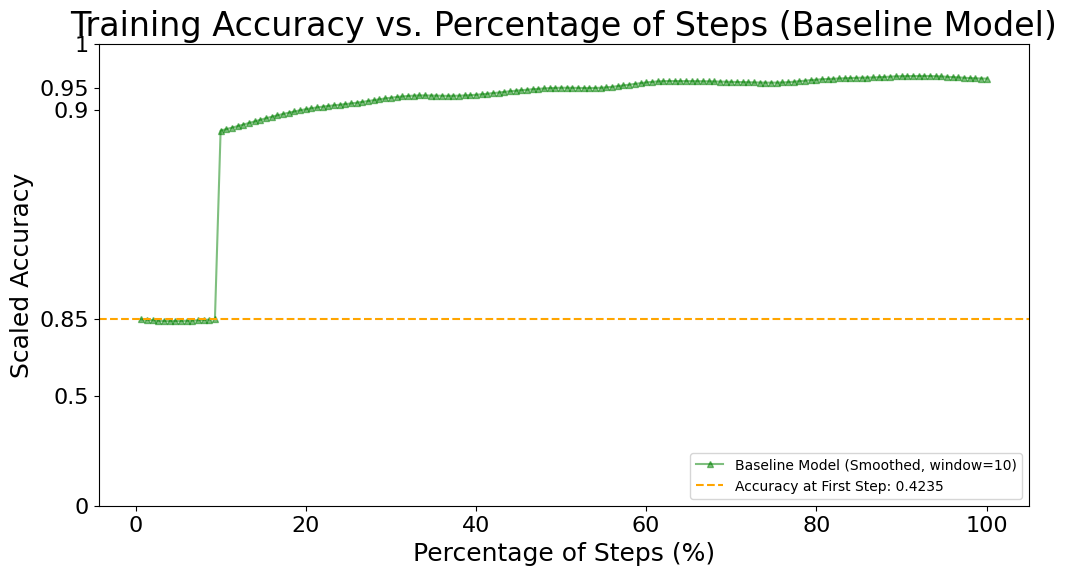

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Define the window size for the moving average (10 points)
window_size = 10

# Calculate the moving average of accuracy values over the specified window size (10 points)
moving_average_accuracy_baseline = [
    sum(accuracy_list[max(0, i - window_size + 1):i + 1]) / min(i + 1, window_size)
    for i in range(len(accuracy_list))
]

# Calculate the total number of steps for the baseline model
total_steps_baseline = len(moving_average_accuracy_baseline)

# Calculate the percentage for each step
percentage_steps_baseline = [(i + 1) / total_steps_baseline * 100 for i in range(total_steps_baseline)]

# Apply smoothing to the moving average accuracy to make the line more fluent
smoothed_accuracy_baseline = gaussian_filter1d(moving_average_accuracy_baseline, sigma=2)

# Custom y-axis scaling: compress values between 0 and 0.85, stretch above 0.95
def custom_y_scale(y):
    if y <= 0.85:
        return y * 0.5  # Compress this range
    elif y >= 0.95:
        return 0.95 + (y - 0.95) * 2  # Stretch this range above 0.95
    return y  # Leave values in between unchanged

# Apply the custom scaling to the accuracy values
scaled_accuracy_baseline = [custom_y_scale(acc) for acc in smoothed_accuracy_baseline]

# Find the step where 100% of the data was processed for the baseline model
try:
    first_full_usage_index_baseline = next(i for i, acc in enumerate(scaled_accuracy_baseline) if acc is not None)
except StopIteration:
    first_full_usage_index_baseline = None

# Plot the training accuracy for the baseline model using moving average
plt.figure(figsize=(12, 6))

# Baseline Model
plt.plot(percentage_steps_baseline, scaled_accuracy_baseline, marker='^', markersize=5, alpha=0.5, color='green', label=f'Baseline Model (Smoothed, window={window_size})')

# Plot an orange horizontal line for the accuracy at the first full data usage for the baseline model
if first_full_usage_index_baseline is not None:
    plt.axhline(y=scaled_accuracy_baseline[first_full_usage_index_baseline], color='orange', linestyle='--', label=f'Accuracy at First Step: {scaled_accuracy_baseline[first_full_usage_index_baseline]:.4f}')

# Add title, labels, and legend
plt.title('Training Accuracy vs. Percentage of Steps (Baseline Model)')
plt.xlabel('Percentage of Steps (%)')
plt.ylabel('Scaled Accuracy')

# Set custom y-axis tick labels to represent original accuracy
original_ticks = [0, 0.5, 0.85, 0.90, 0.95, 1]
custom_scaled_ticks = [custom_y_scale(tick) for tick in original_ticks]
plt.gca().set_yticks(custom_scaled_ticks)
plt.gca().set_yticklabels([str(tick) for tick in original_ticks])

plt.legend(loc='lower right')

# Print accuracy at first full data usage if available
if first_full_usage_index_baseline is not None:
    print(f"Baseline Model - Accuracy at first full data usage (step {first_full_usage_index_baseline + 1}): {smoothed_accuracy_baseline[first_full_usage_index_baseline]}")

# Show the plot
plt.show()


In [101]:
from tensorflow.keras import backend as K

# clear_gpu_memory()
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get a fresh model
    model = get_model()
        
    # Specify the directory from where to load the weights
    load_dir = '/home/f26273/data_enalisn1/GISLR'
    weights_save_path = os.path.join(load_dir, 'initial_trained_weights.h5')

    # Check if the file exists
    if not os.path.exists(weights_save_path):
        raise FileNotFoundError(f"Model weights file not found at: {weights_save_path}")

    # Load the saved initial weights
    model.load_weights(weights_save_path)
    print(f"Model weights loaded from: {weights_save_path}")
        
    # Initialize used samples tracker
    used_samples_full = np.zeros(len(X_train), dtype=bool)
    save_accuracy_callback = CaptureAccuracyCallback(used_samples_full, check_frequency=50)
    
    # Initialize the accuracy logger and callback
    accuracy_logger = DetailedAccuracyLogger(used_samples=used_samples_full)
    
    # Calculate steps per epoch
    steps_per_epoch = len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N)
    current_epoch = [0]
    
    # Global lists to keep track of accuracy across all epochs
    active_learning_accuracy_list = []
    round1_accuracy_list = []
    coverage_history_list = []

    # Continue with the remaining schedule for subsequent models
    LR_SCHEDULE_CONTINUED = LR_SCHEDULE[initial_epochs * steps_per_epoch:]

    # Ensure the continued schedule is long enough
    total_continued_steps = (N_EPOCHS - initial_epochs) * steps_per_epoch
    if len(LR_SCHEDULE_CONTINUED) < total_continued_steps:
        raise ValueError("LR_SCHEDULE_CONTINUED is not long enough to cover the remaining steps.")

    # Apply a decay of 0.9 to the learning rate at each step
    LR_SCHEDULE_CONTINUED_DECAYED = [lr * (0.9 ** (step // steps_per_epoch)) for step, lr in enumerate(LR_SCHEDULE_CONTINUED)]

    # Update the Learning Rate Callback for the continued models
    lr_callback = tf.keras.callbacks.LearningRateScheduler(
        lambda step: LR_SCHEDULE_CONTINUED_DECAYED[step],
        verbose=1
    )
    
    # LR_SCHEDULE_CONTINUED = LR_SCHEDULE[initial_epochs:]

    # # Update the Learning Rate Callback
    # lr_callback = tf.keras.callbacks.LearningRateScheduler(
    #     lambda step: LR_SCHEDULE_CONTINUED[step], verbose=1
    # )

    # Training loop
    for epoch in range(initial_epochs, N_EPOCHS):
        print(f"Starting Epoch {epoch+1}/{N_EPOCHS}")
        current_epoch[0] = epoch
        
        # Update the learning rate and weight decay before each epoch
        current_step = (epoch - initial_epochs) * steps_per_epoch
        new_lr = LR_SCHEDULE_CONTINUED[current_step]
        K.set_value(model.optimizer.learning_rate, new_lr)
        new_weight_decay = K.get_value(model.optimizer.weight_decay) * 1
        K.set_value(model.optimizer.weight_decay, new_weight_decay)
        
        print(f"Epoch {epoch + 1}: Learning rate set to {new_lr}, Weight decay set to {new_weight_decay}")
    
        
        # Determine if we need to run active learning
        if epoch < initial_epochs + 2:
            # new_indices, X_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL, y_train_AL = custom_query(
            #     model, filtered_X_data, filtered_non_empty_frame_idxs, filtered_y_data, batch_size=BATCH_SIZE
            # )
            new_indices, X_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL, y_train_AL = custom_query(
                model, X_train, NON_EMPTY_FRAME_IDXS_TRAIN, y_train, batch_size=BATCH_SIZE
            )
            used_samples_full[new_indices] = True
        else:
            X_train_AL = np.array([]).reshape(0, X_train.shape[1])  # Empty array for active learning data
            NON_EMPTY_FRAME_IDXS_TRAIN_AL = np.array([]).reshape(0, NON_EMPTY_FRAME_IDXS_TRAIN.shape[1])
            y_train_AL = np.array([])

        # Execute one epoch of training using model.fit
        history = model.fit(
            x=dynamic_batch_generator(
                X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN,
                X_train_AL, y_train_AL, NON_EMPTY_FRAME_IDXS_TRAIN_AL,
                used_samples_full, current_epoch
            ),
            steps_per_epoch=steps_per_epoch,
            epochs=1,  # Train for one epoch at a time within the loop
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
                accuracy_logger,
                save_accuracy_callback
            ],
            verbose=VERBOSE,
        )

        # Append the accuracy and coverage history
        print(f"Epoch {epoch+1} accuracy history: {accuracy_logger.step_accuracy}")
        
        # Append the accuracy and coverage history
        active_learning_accuracy_list.extend(accuracy_logger.step_accuracy)
        coverage_history_list.extend(accuracy_logger.coverage_history)

        # If accuracy of the first complete usage of all data is captured, save it
        if save_accuracy_callback.first_full_usage_accuracy is not None:
            round1_accuracy_list.append(save_accuracy_callback.first_full_usage_accuracy)
        
    print("Finished training")
    
    # Log the captured accuracies and coverage history
    print("Active Learning Accuracy List:", active_learning_accuracy_list)
    print("Coverage History List:", coverage_history_list)
    if round1_accuracy_list:
        print("Round 1 Accuracy List:", round1_accuracy_list)
    else:
        print("No round 1 accuracy captured. Check if all data were used during training.")
        
    # Specify the save directory
    save_dir = '/home/f26273/data_enalisn1/GISLR'
    os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

    # Save the model weights after the initial training
    weights_save_path = os.path.join(save_dir, 'active_learning_trained_weights.h5')
    model.save_weights(weights_save_path)
    print(f"Model weights saved at: {weights_save_path}")


Model weights loaded from: /home/f26273/data_enalisn1/GISLR/initial_trained_weights.h5
Starting Epoch 31/60
Epoch 31: Learning rate set to 0.0005000000000000001, Weight decay set to 9.999999747378752e-06


  1/157 [..............................] - ETA: 3:09

  5/157 [..............................] - ETA: 2s  

  9/157 [>.............................] - ETA: 2s

 13/157 [=>............................] - ETA: 2s

 17/157 [==>...........................] - ETA: 2s

 21/157 [===>..........................] - ETA: 2s

 25/157 [===>..........................] - ETA: 2s

 29/157 [====>.........................] - ETA: 2s

 33/157 [=====>........................] - ETA: 1s

 37/157 [======>.......................] - ETA: 1s

 41/157 [======>.......................] - ETA: 1s

 45/157 [=======>......................] - ETA: 1s

 49/157 [========>.....................] - ETA: 1s

 53/157 [=========>....................] - ETA: 1s

 57/157 [=========>....................] - ETA: 1s

 61/157 [==========>...................] - ETA: 1s

 65/157 [===========>..................] - ETA: 1s

 69/157 [============>.................] - ETA: 1s

 73/157 [============>.................] - ETA: 1s

 77/157 [=============>................] - ETA: 1s

 81/157 [==============>...............] - ETA: 1s

 85/157 [===============>..............] - ETA: 1s

 89/157 [================>.............] - ETA: 1s

 93/157 [================>.............] - ETA: 1s

 97/157 [=================>............] - ETA: 0s

101/157 [==================>...........] - ETA: 0s

105/157 [===================>..........] - ETA: 0s

109/157 [===================>..........] - ETA: 0s

113/157 [====================>.........] - ETA: 0s

117/157 [=====================>........] - ETA: 0s

121/157 [======================>.......] - ETA: 0s

125/157 [======================>.......] - ETA: 0s

129/157 [=======================>......] - ETA: 0s

133/157 [========================>.....] - ETA: 0s

137/157 [=========================>....] - ETA: 0s

141/157 [=========================>....] - ETA: 0s

145/157 [==========================>...] - ETA: 0s

149/157 [===========================>..] - ETA: 0s

153/157 [============================>.] - ETA: 0s

157/157 [==============================] - ETA: 0s

157/157 [==============================] - 4s 16ms/step


Shape of probabilities: (5000, 250)


Selected indices: [105, 3374, 4123, 3613, 1710, 4623, 4993, 3340, 4357, 3282, 1819, 3448, 1897, 246, 2171, 1256, 2670, 2283, 4147, 3280, 3424, 2215, 477, 1159, 2995, 1799, 2724, 2424, 2920, 1659, 1845, 1795, 4060, 1993, 4872]
Epoch change detected. Resetting batch generator for Epoch 31.



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.5428571701049805
1/5 [=====>........................] - ETA: 31s - loss: 3.3366 - acc: 0.5429

Batch 2 accuracy: 0.7314009666442871
2/5 [===========>..................] - ETA: 1s - loss: 2.9782 - acc: 0.7314 

Batch 3 accuracy: 0.7523341774940491
3/5 [=================>............] - ETA: 0s - loss: 2.9244 - acc: 0.7523

Batch 4 accuracy: 0.7650741338729858
4/5 [=======================>......] - ETA: 0s - loss: 2.8986 - acc: 0.7651

Batch 5 accuracy: 0.7712515592575073
5/5 [==============================] - ETA: 0s - loss: 2.8847 - acc: 0.7713

Coverage at end of epoch 1: 54.86%
5/5 [==============================] - 9s 409ms/step - loss: 2.8847 - acc: 0.7713 - lr: 5.0000e-04


Epoch 31 accuracy history: [0.5428571701049805, 0.7314009666442871, 0.7523341774940491, 0.7650741338729858, 0.7712515592575073]
Starting Epoch 32/60
Epoch 32: Learning rate set to 0.0003705904774487399, Weight decay set to 2.5000001187436283e-05


  1/157 [..............................] - ETA: 5s

  5/157 [..............................] - ETA: 2s

  9/157 [>.............................] - ETA: 2s

 13/157 [=>............................] - ETA: 2s

 17/157 [==>...........................] - ETA: 2s

 21/157 [===>..........................] - ETA: 2s

 25/157 [===>..........................] - ETA: 2s

 29/157 [====>.........................] - ETA: 2s

 33/157 [=====>........................] - ETA: 1s

 37/157 [======>.......................] - ETA: 1s

 41/157 [======>.......................] - ETA: 1s

 45/157 [=======>......................] - ETA: 1s

 49/157 [========>.....................] - ETA: 1s

 53/157 [=========>....................] - ETA: 1s

 57/157 [=========>....................] - ETA: 1s

 61/157 [==========>...................] - ETA: 1s

 65/157 [===========>..................] - ETA: 1s

 69/157 [============>.................] - ETA: 1s

 73/157 [============>.................] - ETA: 1s

 77/157 [=============>................] - ETA: 1s

 81/157 [==============>...............] - ETA: 1s

 85/157 [===============>..............] - ETA: 1s

 89/157 [================>.............] - ETA: 1s

 93/157 [================>.............] - ETA: 1s

 97/157 [=================>............] - ETA: 0s

101/157 [==================>...........] - ETA: 0s

105/157 [===================>..........] - ETA: 0s

109/157 [===================>..........] - ETA: 0s

113/157 [====================>.........] - ETA: 0s

117/157 [=====================>........] - ETA: 0s

121/157 [======================>.......] - ETA: 0s

125/157 [======================>.......] - ETA: 0s

129/157 [=======================>......] - ETA: 0s

133/157 [========================>.....] - ETA: 0s

137/157 [=========================>....] - ETA: 0s

141/157 [=========================>....] - ETA: 0s

145/157 [==========================>...] - ETA: 0s

149/157 [===========================>..] - ETA: 0s

153/157 [============================>.] - ETA: 0s

157/157 [==============================] - ETA: 0s

157/157 [==============================] - 2s 16ms/step


Shape of probabilities: (5000, 250)


Selected indices: [3997, 1447, 92, 4095, 4560, 2806, 4013, 203, 3731, 1830, 4381, 4249, 1897, 1348, 1842, 3593, 3134, 4353, 2031, 3816, 677, 531, 184, 3828, 335, 3373, 383, 2540, 864, 1204, 4114, 965, 482, 1243, 3530]
Epoch change detected. Resetting batch generator for Epoch 32.



Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.5428571701049805
1/5 [=====>........................] - ETA: 0s - loss: 3.3157 - acc: 0.5429

Batch 2 accuracy: 0.7642512321472168
2/5 [===========>..................] - ETA: 1s - loss: 2.8818 - acc: 0.7643

Batch 3 accuracy: 0.7680589556694031
3/5 [=================>............] - ETA: 0s - loss: 2.8841 - acc: 0.7681

Batch 4 accuracy: 0.7726523876190186
4/5 [=======================>......] - ETA: 0s - loss: 2.8732 - acc: 0.7727

Batch 5 accuracy: 0.7752168774604797
5/5 [==============================] - ETA: 0s - loss: 2.8654 - acc: 0.7752

Coverage at end of epoch 1: 78.54%
5/5 [==============================] - 2s 409ms/step - loss: 2.8654 - acc: 0.7752 - lr: 5.0000e-04


Epoch 32 accuracy history: [0.5428571701049805, 0.7642512321472168, 0.7680589556694031, 0.7726523876190186, 0.7752168774604797]
Starting Epoch 33/60
Epoch 33: Learning rate set to 0.0002500000000000004, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 33.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.8080000281333923
1/5 [=====>........................] - ETA: 20s - loss: 2.8190 - acc: 0.8080

Batch 2 accuracy: 0.8115000128746033
2/5 [===========>..................] - ETA: 1s - loss: 2.8078 - acc: 0.8115 

Batch 3 accuracy: 0.8173333406448364
3/5 [=================>............] - ETA: 0s - loss: 2.7946 - acc: 0.8173

Batch 4 accuracy: 0.8195000290870667
4/5 [=======================>......] - ETA: 0s - loss: 2.7851 - acc: 0.8195

Batch 5 accuracy: 0.8209999799728394
5/5 [==============================] - ETA: 0s - loss: 2.7798 - acc: 0.8210

Coverage at end of epoch 1: 92.42%
5/5 [==============================] - 7s 410ms/step - loss: 2.7798 - acc: 0.8210 - lr: 5.0000e-04


Epoch 33 accuracy history: [0.8080000281333923, 0.8115000128746033, 0.8173333406448364, 0.8195000290870667, 0.8209999799728394]
Starting Epoch 34/60
Epoch 34: Learning rate set to 0.00014644660940672666, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 34.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.8399999737739563
1/5 [=====>........................] - ETA: 1s - loss: 2.7461 - acc: 0.8400

Batch 2 accuracy: 0.8414999842643738
2/5 [===========>..................] - ETA: 1s - loss: 2.7477 - acc: 0.8415

Batch 3 accuracy: 0.8443333506584167
3/5 [=================>............] - ETA: 0s - loss: 2.7353 - acc: 0.8443

Batch 4 accuracy: 0.843999981880188
4/5 [=======================>......] - ETA: 0s - loss: 2.7260 - acc: 0.8440

Batch 5 accuracy: 0.8489999771118164
5/5 [==============================] - ETA: 0s - loss: 2.7119 - acc: 0.8490

Coverage at end of epoch 1: 97.18%
5/5 [==============================] - 2s 407ms/step - loss: 2.7119 - acc: 0.8490 - lr: 5.0000e-04


Epoch 34 accuracy history: [0.8399999737739563, 0.8414999842643738, 0.8443333506584167, 0.843999981880188, 0.8489999771118164]
Starting Epoch 35/60
Epoch 35: Learning rate set to 6.69872981077806e-05, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 35.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.8560000061988831
1/5 [=====>........................] - ETA: 1s - loss: 2.6887 - acc: 0.8560

Batch 2 accuracy: 0.8525000214576721
2/5 [===========>..................] - ETA: 1s - loss: 2.6965 - acc: 0.8525

Batch 3 accuracy: 0.8560000061988831
3/5 [=================>............] - ETA: 0s - loss: 2.6942 - acc: 0.8560

Batch 4 accuracy: 0.8569999933242798
4/5 [=======================>......] - ETA: 0s - loss: 2.6891 - acc: 0.8570

Batch 5 accuracy: 0.8610000014305115
5/5 [==============================] - ETA: 0s - loss: 2.6816 - acc: 0.8610

Coverage at end of epoch 1: 98.86%
5/5 [==============================] - 2s 408ms/step - loss: 2.6816 - acc: 0.8610 - lr: 5.0000e-04


Epoch 35 accuracy history: [0.8560000061988831, 0.8525000214576721, 0.8560000061988831, 0.8569999933242798, 0.8610000014305115]
Starting Epoch 36/60
Epoch 36: Learning rate set to 1.7037086855465843e-05, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 36.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.8550000190734863
1/5 [=====>........................] - ETA: 1s - loss: 2.6793 - acc: 0.8550

Batch 2 accuracy: 0.8709999918937683
2/5 [===========>..................] - ETA: 1s - loss: 2.6519 - acc: 0.8710

Batch 3 accuracy: 0.8723333477973938
3/5 [=================>............] - ETA: 0s - loss: 2.6515 - acc: 0.8723

Batch 4 accuracy: 0.8715000152587891
4/5 [=======================>......] - ETA: 0s - loss: 2.6487 - acc: 0.8715

Batch 5 accuracy: 0.8736000061035156
5/5 [==============================] - ETA: 0s - loss: 2.6458 - acc: 0.8736

Coverage at end of epoch 1: 99.44%
5/5 [==============================] - 2s 408ms/step - loss: 2.6458 - acc: 0.8736 - lr: 5.0000e-04


Epoch 36 accuracy history: [0.8550000190734863, 0.8709999918937683, 0.8723333477973938, 0.8715000152587891, 0.8736000061035156]
Starting Epoch 37/60
Epoch 37: Learning rate set to 0.0, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 37.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9079999923706055
1/5 [=====>........................] - ETA: 1s - loss: 2.5905 - acc: 0.9080

Batch 2 accuracy: 0.8949999809265137
2/5 [===========>..................] - ETA: 1s - loss: 2.6070 - acc: 0.8950

Batch 3 accuracy: 0.8963333368301392
3/5 [=================>............] - ETA: 0s - loss: 2.6020 - acc: 0.8963

Batch 4 accuracy: 0.8960000276565552
4/5 [=======================>......] - ETA: 0s - loss: 2.6041 - acc: 0.8960

Batch 5 accuracy: 0.8992000222206116
5/5 [==============================] - ETA: 0s - loss: 2.5982 - acc: 0.8992

Coverage at end of epoch 1: 99.64%
5/5 [==============================] - 2s 407ms/step - loss: 2.5982 - acc: 0.8992 - lr: 5.0000e-04


Epoch 37 accuracy history: [0.9079999923706055, 0.8949999809265137, 0.8963333368301392, 0.8960000276565552, 0.8992000222206116]
Starting Epoch 38/60
Epoch 38: Learning rate set to 1.703708685546579e-05, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 38.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9100000262260437
1/5 [=====>........................] - ETA: 1s - loss: 2.5690 - acc: 0.9100

Batch 2 accuracy: 0.906499981880188
2/5 [===========>..................] - ETA: 1s - loss: 2.5710 - acc: 0.9065

Batch 3 accuracy: 0.9073333144187927
3/5 [=================>............] - ETA: 0s - loss: 2.5737 - acc: 0.9073

Batch 4 accuracy: 0.9075000286102295
4/5 [=======================>......] - ETA: 0s - loss: 2.5687 - acc: 0.9075

Batch 5 accuracy: 0.9089999794960022
5/5 [==============================] - ETA: 0s - loss: 2.5654 - acc: 0.9090

Coverage at end of epoch 1: 99.72%
5/5 [==============================] - 2s 408ms/step - loss: 2.5654 - acc: 0.9090 - lr: 5.0000e-04


Epoch 38 accuracy history: [0.9100000262260437, 0.906499981880188, 0.9073333144187927, 0.9075000286102295, 0.9089999794960022]
Starting Epoch 39/60
Epoch 39: Learning rate set to 6.698729810778043e-05, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 39.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.925000011920929
1/5 [=====>........................] - ETA: 1s - loss: 2.5425 - acc: 0.9250

Batch 2 accuracy: 0.9160000085830688
2/5 [===========>..................] - ETA: 1s - loss: 2.5485 - acc: 0.9160

Batch 3 accuracy: 0.9129999876022339
3/5 [=================>............] - ETA: 0s - loss: 2.5472 - acc: 0.9130

Batch 4 accuracy: 0.9167500138282776
4/5 [=======================>......] - ETA: 0s - loss: 2.5430 - acc: 0.9168

Batch 5 accuracy: 0.9187999963760376
5/5 [==============================] - ETA: 0s - loss: 2.5354 - acc: 0.9188

Coverage at end of epoch 1: 99.78%
5/5 [==============================] - 2s 407ms/step - loss: 2.5354 - acc: 0.9188 - lr: 5.0000e-04


Epoch 39 accuracy history: [0.925000011920929, 0.9160000085830688, 0.9129999876022339, 0.9167500138282776, 0.9187999963760376]
Starting Epoch 40/60
Epoch 40: Learning rate set to 0.00014644660940672644, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 40.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.8939999938011169
1/5 [=====>........................] - ETA: 1s - loss: 2.5514 - acc: 0.8940

Batch 2 accuracy: 0.9070000052452087
2/5 [===========>..................] - ETA: 1s - loss: 2.5395 - acc: 0.9070

Batch 3 accuracy: 0.9079999923706055
3/5 [=================>............] - ETA: 0s - loss: 2.5341 - acc: 0.9080

Batch 4 accuracy: 0.9129999876022339
4/5 [=======================>......] - ETA: 0s - loss: 2.5310 - acc: 0.9130

Batch 5 accuracy: 0.9120000004768372
5/5 [==============================] - ETA: 0s - loss: 2.5296 - acc: 0.9120

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.5296 - acc: 0.9120 - lr: 5.0000e-04


Epoch 40 accuracy history: [0.8939999938011169, 0.9070000052452087, 0.9079999923706055, 0.9129999876022339, 0.9120000004768372]
Starting Epoch 41/60
Epoch 41: Learning rate set to 0.0002500000000000001, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 41.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.921999990940094
1/5 [=====>........................] - ETA: 1s - loss: 2.5089 - acc: 0.9220

Batch 2 accuracy: 0.9259999990463257
2/5 [===========>..................] - ETA: 1s - loss: 2.5089 - acc: 0.9260

Batch 3 accuracy: 0.9233333468437195
3/5 [=================>............] - ETA: 0s - loss: 2.5098 - acc: 0.9233

Batch 4 accuracy: 0.9254999756813049
4/5 [=======================>......] - ETA: 0s - loss: 2.5055 - acc: 0.9255

Batch 5 accuracy: 0.926800012588501
5/5 [==============================] - ETA: 0s - loss: 2.5029 - acc: 0.9268

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.5029 - acc: 0.9268 - lr: 5.0000e-04


Epoch 41 accuracy history: [0.921999990940094, 0.9259999990463257, 0.9233333468437195, 0.9254999756813049, 0.926800012588501]
Starting Epoch 42/60
Epoch 42: Learning rate set to 0.0003705904774487395, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 42.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9259999990463257
1/5 [=====>........................] - ETA: 1s - loss: 2.5035 - acc: 0.9260

Batch 2 accuracy: 0.9265000224113464
2/5 [===========>..................] - ETA: 1s - loss: 2.5058 - acc: 0.9265

Batch 3 accuracy: 0.9283333420753479
3/5 [=================>............] - ETA: 0s - loss: 2.4954 - acc: 0.9283

Batch 4 accuracy: 0.9334999918937683
4/5 [=======================>......] - ETA: 0s - loss: 2.4888 - acc: 0.9335

Batch 5 accuracy: 0.932200014591217
5/5 [==============================] - ETA: 0s - loss: 2.4880 - acc: 0.9322

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 407ms/step - loss: 2.4880 - acc: 0.9322 - lr: 5.0000e-04


Epoch 42 accuracy history: [0.9259999990463257, 0.9265000224113464, 0.9283333420753479, 0.9334999918937683, 0.932200014591217]
Starting Epoch 43/60
Epoch 43: Learning rate set to 0.0004999999999999998, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 43.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9409999847412109
1/5 [=====>........................] - ETA: 1s - loss: 2.4695 - acc: 0.9410

Batch 2 accuracy: 0.9375
2/5 [===========>..................] - ETA: 1s - loss: 2.4673 - acc: 0.9375

Batch 3 accuracy: 0.9336666464805603
3/5 [=================>............] - ETA: 0s - loss: 2.4746 - acc: 0.9337

Batch 4 accuracy: 0.9319999814033508
4/5 [=======================>......] - ETA: 0s - loss: 2.4786 - acc: 0.9320

Batch 5 accuracy: 0.9366000294685364
5/5 [==============================] - ETA: 0s - loss: 2.4728 - acc: 0.9366

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 410ms/step - loss: 2.4728 - acc: 0.9366 - lr: 5.0000e-04


Epoch 43 accuracy history: [0.9409999847412109, 0.9375, 0.9336666464805603, 0.9319999814033508, 0.9366000294685364]
Starting Epoch 44/60
Epoch 44: Learning rate set to 0.00062940952255126, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 44.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9340000152587891
1/5 [=====>........................] - ETA: 1s - loss: 2.4810 - acc: 0.9340

Batch 2 accuracy: 0.9359999895095825
2/5 [===========>..................] - ETA: 1s - loss: 2.4742 - acc: 0.9360

Batch 3 accuracy: 0.9383333325386047
3/5 [=================>............] - ETA: 0s - loss: 2.4699 - acc: 0.9383

Batch 4 accuracy: 0.9367499947547913
4/5 [=======================>......] - ETA: 0s - loss: 2.4648 - acc: 0.9367

Batch 5 accuracy: 0.9376000165939331
5/5 [==============================] - ETA: 0s - loss: 2.4613 - acc: 0.9376

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 407ms/step - loss: 2.4613 - acc: 0.9376 - lr: 5.0000e-04


Epoch 44 accuracy history: [0.9340000152587891, 0.9359999895095825, 0.9383333325386047, 0.9367499947547913, 0.9376000165939331]
Starting Epoch 45/60
Epoch 45: Learning rate set to 0.0007499999999999996, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 45.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9380000233650208
1/5 [=====>........................] - ETA: 1s - loss: 2.4484 - acc: 0.9380

Batch 2 accuracy: 0.9380000233650208
2/5 [===========>..................] - ETA: 1s - loss: 2.4587 - acc: 0.9380

Batch 3 accuracy: 0.9440000057220459
3/5 [=================>............] - ETA: 0s - loss: 2.4481 - acc: 0.9440

Batch 4 accuracy: 0.9455000162124634
4/5 [=======================>......] - ETA: 0s - loss: 2.4450 - acc: 0.9455

Batch 5 accuracy: 0.9440000057220459
5/5 [==============================] - ETA: 0s - loss: 2.4457 - acc: 0.9440

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4457 - acc: 0.9440 - lr: 5.0000e-04


Epoch 45 accuracy history: [0.9380000233650208, 0.9380000233650208, 0.9440000057220459, 0.9455000162124634, 0.9440000057220459]
Starting Epoch 46/60
Epoch 46: Learning rate set to 0.0008535533905932733, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 46.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9430000185966492
1/5 [=====>........................] - ETA: 1s - loss: 2.4453 - acc: 0.9430

Batch 2 accuracy: 0.9434999823570251
2/5 [===========>..................] - ETA: 1s - loss: 2.4425 - acc: 0.9435

Batch 3 accuracy: 0.9453333616256714
3/5 [=================>............] - ETA: 0s - loss: 2.4441 - acc: 0.9453

Batch 4 accuracy: 0.9472500085830688
4/5 [=======================>......] - ETA: 0s - loss: 2.4390 - acc: 0.9473

Batch 5 accuracy: 0.9473999738693237
5/5 [==============================] - ETA: 0s - loss: 2.4377 - acc: 0.9474

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4377 - acc: 0.9474 - lr: 5.0000e-04


Epoch 46 accuracy history: [0.9430000185966492, 0.9434999823570251, 0.9453333616256714, 0.9472500085830688, 0.9473999738693237]
Starting Epoch 47/60
Epoch 47: Learning rate set to 0.0009330127018922195, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 47.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9660000205039978
1/5 [=====>........................] - ETA: 1s - loss: 2.3971 - acc: 0.9660

Batch 2 accuracy: 0.9564999938011169
2/5 [===========>..................] - ETA: 1s - loss: 2.4161 - acc: 0.9565

Batch 3 accuracy: 0.9553333520889282
3/5 [=================>............] - ETA: 0s - loss: 2.4187 - acc: 0.9553

Batch 4 accuracy: 0.9564999938011169
4/5 [=======================>......] - ETA: 0s - loss: 2.4154 - acc: 0.9565

Batch 5 accuracy: 0.9567999839782715
5/5 [==============================] - ETA: 0s - loss: 2.4148 - acc: 0.9568

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4148 - acc: 0.9568 - lr: 5.0000e-04


Epoch 47 accuracy history: [0.9660000205039978, 0.9564999938011169, 0.9553333520889282, 0.9564999938011169, 0.9567999839782715]
Starting Epoch 48/60
Epoch 48: Learning rate set to 0.0009829629131445341, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 48.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9490000009536743
1/5 [=====>........................] - ETA: 1s - loss: 2.4208 - acc: 0.9490

Batch 2 accuracy: 0.9549999833106995
2/5 [===========>..................] - ETA: 1s - loss: 2.4091 - acc: 0.9550

Batch 3 accuracy: 0.9536666870117188
3/5 [=================>............] - ETA: 0s - loss: 2.4110 - acc: 0.9537

Batch 4 accuracy: 0.953000009059906
4/5 [=======================>......] - ETA: 0s - loss: 2.4130 - acc: 0.9530

Batch 5 accuracy: 0.954200029373169
5/5 [==============================] - ETA: 0s - loss: 2.4094 - acc: 0.9542

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 407ms/step - loss: 2.4094 - acc: 0.9542 - lr: 5.0000e-04


Epoch 48 accuracy history: [0.9490000009536743, 0.9549999833106995, 0.9536666870117188, 0.953000009059906, 0.954200029373169]
Starting Epoch 49/60
Epoch 49: Learning rate set to 0.001, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 49.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.953000009059906
1/5 [=====>........................] - ETA: 1s - loss: 2.4136 - acc: 0.9530

Batch 2 accuracy: 0.9564999938011169
2/5 [===========>..................] - ETA: 1s - loss: 2.4113 - acc: 0.9565

Batch 3 accuracy: 0.9556666612625122
3/5 [=================>............] - ETA: 0s - loss: 2.4090 - acc: 0.9557

Batch 4 accuracy: 0.956250011920929
4/5 [=======================>......] - ETA: 0s - loss: 2.4046 - acc: 0.9563

Batch 5 accuracy: 0.9557999968528748
5/5 [==============================] - ETA: 0s - loss: 2.4046 - acc: 0.9558

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.4046 - acc: 0.9558 - lr: 5.0000e-04


Epoch 49 accuracy history: [0.953000009059906, 0.9564999938011169, 0.9556666612625122, 0.956250011920929, 0.9557999968528748]
Starting Epoch 50/60
Epoch 50: Learning rate set to 0.0009829629131445344, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 50.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9710000157356262
1/5 [=====>........................] - ETA: 1s - loss: 2.3812 - acc: 0.9710

Batch 2 accuracy: 0.9704999923706055
2/5 [===========>..................] - ETA: 1s - loss: 2.3825 - acc: 0.9705

Batch 3 accuracy: 0.9649999737739563
3/5 [=================>............] - ETA: 0s - loss: 2.3892 - acc: 0.9650

Batch 4 accuracy: 0.9629999995231628
4/5 [=======================>......] - ETA: 0s - loss: 2.3913 - acc: 0.9630

Batch 5 accuracy: 0.9625999927520752
5/5 [==============================] - ETA: 0s - loss: 2.3906 - acc: 0.9626

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.3906 - acc: 0.9626 - lr: 5.0000e-04


Epoch 50 accuracy history: [0.9710000157356262, 0.9704999923706055, 0.9649999737739563, 0.9629999995231628, 0.9625999927520752]
Starting Epoch 51/60
Epoch 51: Learning rate set to 0.0009330127018922192, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 51.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9670000076293945
1/5 [=====>........................] - ETA: 1s - loss: 2.3747 - acc: 0.9670

Batch 2 accuracy: 0.9639999866485596
2/5 [===========>..................] - ETA: 1s - loss: 2.3723 - acc: 0.9640

Batch 3 accuracy: 0.9620000123977661
3/5 [=================>............] - ETA: 0s - loss: 2.3769 - acc: 0.9620

Batch 4 accuracy: 0.9629999995231628
4/5 [=======================>......] - ETA: 0s - loss: 2.3752 - acc: 0.9630

Batch 5 accuracy: 0.9617999792098999
5/5 [==============================] - ETA: 0s - loss: 2.3790 - acc: 0.9618

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.3790 - acc: 0.9618 - lr: 5.0000e-04


Epoch 51 accuracy history: [0.9670000076293945, 0.9639999866485596, 0.9620000123977661, 0.9629999995231628, 0.9617999792098999]
Starting Epoch 52/60
Epoch 52: Learning rate set to 0.0008535533905932736, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 52.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9620000123977661
1/5 [=====>........................] - ETA: 1s - loss: 2.3646 - acc: 0.9620

Batch 2 accuracy: 0.9629999995231628
2/5 [===========>..................] - ETA: 1s - loss: 2.3730 - acc: 0.9630

Batch 3 accuracy: 0.9633333086967468
3/5 [=================>............] - ETA: 0s - loss: 2.3763 - acc: 0.9633

Batch 4 accuracy: 0.9620000123977661
4/5 [=======================>......] - ETA: 0s - loss: 2.3774 - acc: 0.9620

Batch 5 accuracy: 0.9624000191688538
5/5 [==============================] - ETA: 0s - loss: 2.3773 - acc: 0.9624

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.3773 - acc: 0.9624 - lr: 5.0000e-04


Epoch 52 accuracy history: [0.9620000123977661, 0.9629999995231628, 0.9633333086967468, 0.9620000123977661, 0.9624000191688538]
Starting Epoch 53/60
Epoch 53: Learning rate set to 0.0007500000000000007, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 53.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.953000009059906
1/5 [=====>........................] - ETA: 1s - loss: 2.3855 - acc: 0.9530

Batch 2 accuracy: 0.9570000171661377
2/5 [===========>..................] - ETA: 1s - loss: 2.3813 - acc: 0.9570

Batch 3 accuracy: 0.9613333344459534
3/5 [=================>............] - ETA: 0s - loss: 2.3742 - acc: 0.9613

Batch 4 accuracy: 0.9595000147819519
4/5 [=======================>......] - ETA: 0s - loss: 2.3737 - acc: 0.9595

Batch 5 accuracy: 0.9584000110626221
5/5 [==============================] - ETA: 0s - loss: 2.3730 - acc: 0.9584

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.3730 - acc: 0.9584 - lr: 5.0000e-04


Epoch 53 accuracy history: [0.953000009059906, 0.9570000171661377, 0.9613333344459534, 0.9595000147819519, 0.9584000110626221]
Starting Epoch 54/60
Epoch 54: Learning rate set to 0.0006294095225512604, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 54.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9700000286102295
1/5 [=====>........................] - ETA: 1s - loss: 2.3423 - acc: 0.9700

Batch 2 accuracy: 0.9679999947547913
2/5 [===========>..................] - ETA: 1s - loss: 2.3526 - acc: 0.9680

Batch 3 accuracy: 0.9679999947547913
3/5 [=================>............] - ETA: 0s - loss: 2.3570 - acc: 0.9680

Batch 4 accuracy: 0.965499997138977
4/5 [=======================>......] - ETA: 0s - loss: 2.3612 - acc: 0.9655

Batch 5 accuracy: 0.967199981212616
5/5 [==============================] - ETA: 0s - loss: 2.3580 - acc: 0.9672

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.3580 - acc: 0.9672 - lr: 5.0000e-04


Epoch 54 accuracy history: [0.9700000286102295, 0.9679999947547913, 0.9679999947547913, 0.965499997138977, 0.967199981212616]
Starting Epoch 55/60
Epoch 55: Learning rate set to 0.0005000000000000002, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 55.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9700000286102295
1/5 [=====>........................] - ETA: 1s - loss: 2.3473 - acc: 0.9700

Batch 2 accuracy: 0.9674999713897705
2/5 [===========>..................] - ETA: 1s - loss: 2.3577 - acc: 0.9675

Batch 3 accuracy: 0.9649999737739563
3/5 [=================>............] - ETA: 0s - loss: 2.3567 - acc: 0.9650

Batch 4 accuracy: 0.965499997138977
4/5 [=======================>......] - ETA: 0s - loss: 2.3547 - acc: 0.9655

Batch 5 accuracy: 0.9679999947547913
5/5 [==============================] - ETA: 0s - loss: 2.3514 - acc: 0.9680

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 408ms/step - loss: 2.3514 - acc: 0.9680 - lr: 5.0000e-04


Epoch 55 accuracy history: [0.9700000286102295, 0.9674999713897705, 0.9649999737739563, 0.965499997138977, 0.9679999947547913]
Starting Epoch 56/60
Epoch 56: Learning rate set to 0.00037059047744874006, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 56.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9819999933242798
1/5 [=====>........................] - ETA: 1s - loss: 2.3280 - acc: 0.9820

Batch 2 accuracy: 0.9769999980926514
2/5 [===========>..................] - ETA: 1s - loss: 2.3354 - acc: 0.9770

Batch 3 accuracy: 0.9773333072662354
3/5 [=================>............] - ETA: 0s - loss: 2.3327 - acc: 0.9773

Batch 4 accuracy: 0.9767500162124634
4/5 [=======================>......] - ETA: 0s - loss: 2.3312 - acc: 0.9768

Batch 5 accuracy: 0.975600004196167
5/5 [==============================] - ETA: 0s - loss: 2.3314 - acc: 0.9756

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 410ms/step - loss: 2.3314 - acc: 0.9756 - lr: 5.0000e-04


Epoch 56 accuracy history: [0.9819999933242798, 0.9769999980926514, 0.9773333072662354, 0.9767500162124634, 0.975600004196167]
Starting Epoch 57/60
Epoch 57: Learning rate set to 0.00024999999999999973, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 57.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9750000238418579
1/5 [=====>........................] - ETA: 1s - loss: 2.3390 - acc: 0.9750

Batch 2 accuracy: 0.9750000238418579
2/5 [===========>..................] - ETA: 1s - loss: 2.3355 - acc: 0.9750

Batch 3 accuracy: 0.9743333458900452
3/5 [=================>............] - ETA: 0s - loss: 2.3366 - acc: 0.9743

Batch 4 accuracy: 0.9739999771118164
4/5 [=======================>......] - ETA: 0s - loss: 2.3335 - acc: 0.9740

Batch 5 accuracy: 0.9742000102996826
5/5 [==============================] - ETA: 0s - loss: 2.3334 - acc: 0.9742

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 410ms/step - loss: 2.3334 - acc: 0.9742 - lr: 5.0000e-04


Epoch 57 accuracy history: [0.9750000238418579, 0.9750000238418579, 0.9743333458900452, 0.9739999771118164, 0.9742000102996826]
Starting Epoch 58/60
Epoch 58: Learning rate set to 0.00014644660940672677, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 58.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9710000157356262
1/5 [=====>........................] - ETA: 1s - loss: 2.3237 - acc: 0.9710

Batch 2 accuracy: 0.9729999899864197
2/5 [===========>..................] - ETA: 1s - loss: 2.3242 - acc: 0.9730

Batch 3 accuracy: 0.9753333330154419
3/5 [=================>............] - ETA: 0s - loss: 2.3235 - acc: 0.9753

Batch 4 accuracy: 0.9775000214576721
4/5 [=======================>......] - ETA: 0s - loss: 2.3240 - acc: 0.9775

Batch 5 accuracy: 0.9761999845504761
5/5 [==============================] - ETA: 0s - loss: 2.3224 - acc: 0.9762

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.3224 - acc: 0.9762 - lr: 5.0000e-04


Epoch 58 accuracy history: [0.9710000157356262, 0.9729999899864197, 0.9753333330154419, 0.9775000214576721, 0.9761999845504761]
Starting Epoch 59/60
Epoch 59: Learning rate set to 6.698729810778115e-05, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 59.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9739999771118164
1/5 [=====>........................] - ETA: 1s - loss: 2.3068 - acc: 0.9740

Batch 2 accuracy: 0.9775000214576721
2/5 [===========>..................] - ETA: 1s - loss: 2.3070 - acc: 0.9775

Batch 3 accuracy: 0.9773333072662354
3/5 [=================>............] - ETA: 0s - loss: 2.3082 - acc: 0.9773

Batch 4 accuracy: 0.9779999852180481
4/5 [=======================>......] - ETA: 0s - loss: 2.3072 - acc: 0.9780

Batch 5 accuracy: 0.974399983882904
5/5 [==============================] - ETA: 0s - loss: 2.3118 - acc: 0.9744

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 410ms/step - loss: 2.3118 - acc: 0.9744 - lr: 5.0000e-04


Epoch 59 accuracy history: [0.9739999771118164, 0.9775000214576721, 0.9773333072662354, 0.9779999852180481, 0.974399983882904]
Starting Epoch 60/60
Epoch 60: Learning rate set to 1.70370868554659e-05, Weight decay set to 2.5000001187436283e-05
Epoch change detected. Resetting batch generator for Epoch 60.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000000000001.


learning rate: 5.00e-04, weight decay: 2.50e-05


Batch 1 accuracy: 0.9779999852180481
1/5 [=====>........................] - ETA: 1s - loss: 2.3163 - acc: 0.9780

Batch 2 accuracy: 0.9779999852180481
2/5 [===========>..................] - ETA: 1s - loss: 2.3092 - acc: 0.9780

Batch 3 accuracy: 0.9776666760444641
3/5 [=================>............] - ETA: 0s - loss: 2.3098 - acc: 0.9777

Batch 4 accuracy: 0.9764999747276306
4/5 [=======================>......] - ETA: 0s - loss: 2.3108 - acc: 0.9765

Batch 5 accuracy: 0.9761999845504761
5/5 [==============================] - ETA: 0s - loss: 2.3120 - acc: 0.9762

Coverage at end of epoch 1: 99.80%
5/5 [==============================] - 2s 409ms/step - loss: 2.3120 - acc: 0.9762 - lr: 5.0000e-04


Epoch 60 accuracy history: [0.9779999852180481, 0.9779999852180481, 0.9776666760444641, 0.9764999747276306, 0.9761999845504761]
Finished training
Active Learning Accuracy List: [0.5428571701049805, 0.7314009666442871, 0.7523341774940491, 0.7650741338729858, 0.7712515592575073, 0.5428571701049805, 0.7642512321472168, 0.7680589556694031, 0.7726523876190186, 0.7752168774604797, 0.8080000281333923, 0.8115000128746033, 0.8173333406448364, 0.8195000290870667, 0.8209999799728394, 0.8399999737739563, 0.8414999842643738, 0.8443333506584167, 0.843999981880188, 0.8489999771118164, 0.8560000061988831, 0.8525000214576721, 0.8560000061988831, 0.8569999933242798, 0.8610000014305115, 0.8550000190734863, 0.8709999918937683, 0.8723333477973938, 0.8715000152587891, 0.8736000061035156, 0.9079999923706055, 0.8949999809265137, 0.8963333368301392, 0.8960000276565552, 0.8992000222206116, 0.9100000262260437, 0.906499981880188, 0.9073333144187927, 0.9075000286102295, 0.9089999794960022, 0.925000011920929, 0.916

In [102]:
# Log the captured accuracies and coverage history
print("Active Learning Accuracy List:", active_learning_accuracy_list)
print("Coverage History List:", coverage_history_list)
if round1_accuracy_list:
    print("Round 1 Accuracy List:", round1_accuracy_list)
else:
    print("No round 1 accuracy captured. Check if all data were used during training.")

Active Learning Accuracy List: [0.5428571701049805, 0.7314009666442871, 0.7523341774940491, 0.7650741338729858, 0.7712515592575073, 0.5428571701049805, 0.7642512321472168, 0.7680589556694031, 0.7726523876190186, 0.7752168774604797, 0.8080000281333923, 0.8115000128746033, 0.8173333406448364, 0.8195000290870667, 0.8209999799728394, 0.8399999737739563, 0.8414999842643738, 0.8443333506584167, 0.843999981880188, 0.8489999771118164, 0.8560000061988831, 0.8525000214576721, 0.8560000061988831, 0.8569999933242798, 0.8610000014305115, 0.8550000190734863, 0.8709999918937683, 0.8723333477973938, 0.8715000152587891, 0.8736000061035156, 0.9079999923706055, 0.8949999809265137, 0.8963333368301392, 0.8960000276565552, 0.8992000222206116, 0.9100000262260437, 0.906499981880188, 0.9073333144187927, 0.9075000286102295, 0.9089999794960022, 0.925000011920929, 0.9160000085830688, 0.9129999876022339, 0.9167500138282776, 0.9187999963760376, 0.8939999938011169, 0.9070000052452087, 0.9079999923706055, 0.912999987

In [103]:
from sklearn.metrics import f1_score

# Load the model weights for evaluation
load_dir = '/home/f26273/data_enalisn1/GISLR'
weights_save_path = os.path.join(load_dir, 'active_learning_trained_weights.h5')

# Get a fresh model
model = get_model()

# Check if the file exists
if not os.path.exists(weights_save_path):
    raise FileNotFoundError(f"Model weights file not found at: {weights_save_path}")

# Load the saved weights
model.load_weights(weights_save_path)
print(f"Model weights loaded from: {weights_save_path}")

# Make predictions on the test set
y_pred_probs = model.predict(
    x={'frames': X_test, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST},
    batch_size=BATCH_SIZE,
    verbose=1
)

# Convert predicted probabilities to class labels (argmax)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate F1 score using sklearn
f1 = f1_score(y_test, y_pred, average='macro')  # Macro F1 for average across classes

# Print F1 score
print(f"F1 Score (Macro): {f1:.4f}")

# Optional: You can also calculate the weighted F1 score
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (Weighted): {f1_weighted:.4f}")

# Evaluate the model on the test set
test_results = model.evaluate(
    x={'frames': X_test, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_TEST},
    y=y_test,
    batch_size=BATCH_SIZE,
    verbose=1
)

# Print the test results
print(f"Test Loss: {test_results[0]}, Test Accuracy: {test_results[1]}")

Model weights loaded from: /home/f26273/data_enalisn1/GISLR/active_learning_trained_weights.h5


 1/41 [..............................] - ETA: 48s

 5/41 [==>...........................] - ETA: 0s 

 9/41 [=====>........................] - ETA: 0s

13/41 [========>.....................] - ETA: 0s

17/41 [===========>..................] - ETA: 0s

21/41 [==============>...............] - ETA: 0s

25/41 [=================>............] - ETA: 0s

29/41 [====================>.........] - ETA: 0s

33/41 [=======================>......] - ETA: 0s

37/41 [==========================>...] - ETA: 0s

41/41 [==============================] - ETA: 0s

41/41 [==============================] - 2s 16ms/step


F1 Score (Macro): 0.9848


F1 Score (Weighted): 0.9860


 1/41 [..............................] - ETA: 50s - loss: 2.1911 - acc: 1.0000

 4/41 [=>............................] - ETA: 0s - loss: 2.2022 - acc: 0.9922 

 7/41 [====>.........................] - ETA: 0s - loss: 2.2043 - acc: 0.9955

10/41 [======>.......................] - ETA: 0s - loss: 2.2063 - acc: 0.9937

13/41 [========>.....................] - ETA: 0s - loss: 2.2105 - acc: 0.9880

16/41 [==========>...................] - ETA: 0s - loss: 2.2238 - acc: 0.9883

19/41 [============>.................] - ETA: 0s - loss: 2.2228 - acc: 0.9885

22/41 [===============>..............] - ETA: 0s - loss: 2.2196 - acc: 0.9886

25/41 [=================>............] - ETA: 0s - loss: 2.2180 - acc: 0.9900

28/41 [===================>..........] - ETA: 0s - loss: 2.2167 - acc: 0.9888

31/41 [=====================>........] - ETA: 0s - loss: 2.2150 - acc: 0.9889

34/41 [=======================>......] - ETA: 0s - loss: 2.2149 - acc: 0.9881

37/41 [==========================>...] - ETA: 0s - loss: 2.2131 - acc: 0.9865

40/41 [============================>.] - ETA: 0s - loss: 2.2121 - acc: 0.9859

41/41 [==============================] - 2s 18ms/step - loss: 2.2133 - acc: 0.9854


Test Loss: 2.213303327560425, Test Accuracy: 0.9854294657707214


Active Learning Accuracy List: [0.5428571701049805, 0.7314009666442871, 0.7523341774940491, 0.7650741338729858, 0.7712515592575073, 0.5428571701049805, 0.7642512321472168, 0.7680589556694031, 0.7726523876190186, 0.7752168774604797, 0.8080000281333923, 0.8115000128746033, 0.8173333406448364, 0.8195000290870667, 0.8209999799728394, 0.8399999737739563, 0.8414999842643738, 0.8443333506584167, 0.843999981880188, 0.8489999771118164, 0.8560000061988831, 0.8525000214576721, 0.8560000061988831, 0.8569999933242798, 0.8610000014305115, 0.8550000190734863, 0.8709999918937683, 0.8723333477973938, 0.8715000152587891, 0.8736000061035156, 0.9079999923706055, 0.8949999809265137, 0.8963333368301392, 0.8960000276565552, 0.8992000222206116, 0.9100000262260437, 0.906499981880188, 0.9073333144187927, 0.9075000286102295, 0.9089999794960022, 0.925000011920929, 0.9160000085830688, 0.9129999876022339, 0.9167500138282776, 0.9187999963760376, 0.8939999938011169, 0.9070000052452087, 0.9079999923706055, 0.912999987

Active Learning Model - Accuracy at first full data usage (step 1): 0.6178502637583019


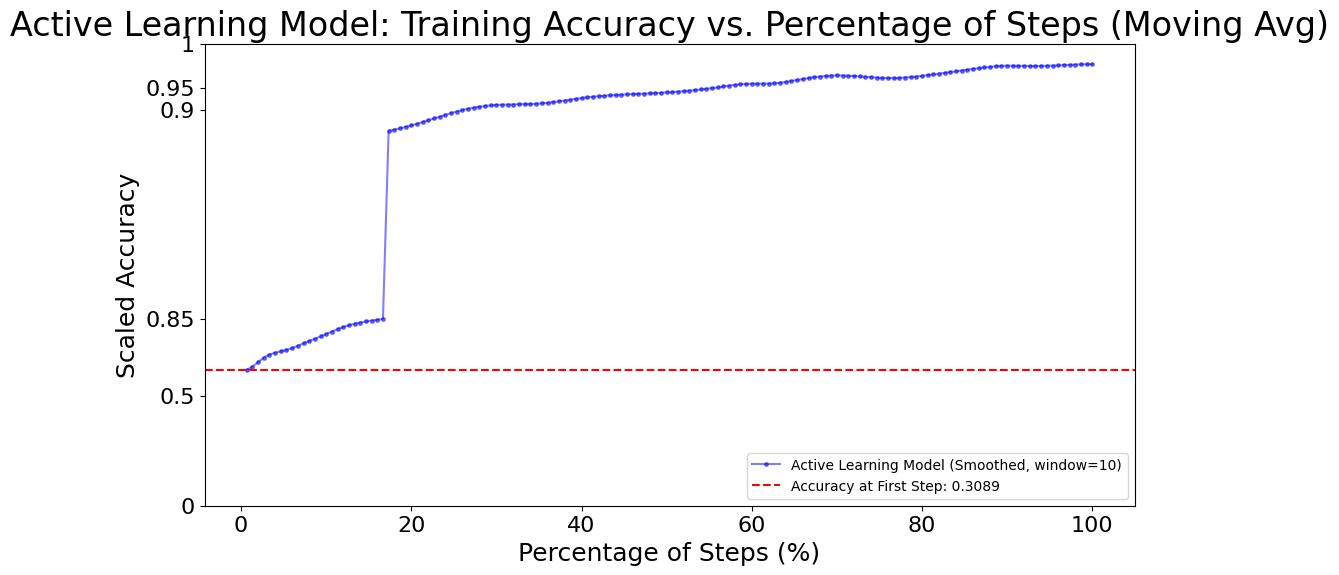

In [104]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

# Assuming active_learning_accuracy_list is already populated
print("Active Learning Accuracy List:", active_learning_accuracy_list)

# Specify the moving average window size
window_size = 10

# Calculate the moving average of accuracy values over the previous window_size values
moving_average_accuracy = [
    sum(active_learning_accuracy_list[max(0, i - window_size + 1):i + 1]) / min(i + 1, window_size)
    for i in range(len(active_learning_accuracy_list))
]

# Apply smoothing to make the line more fluent
smoothed_accuracy_active_learning = gaussian_filter1d(moving_average_accuracy, sigma=2)

# Custom y-axis scaling: compress values between 0 and 0.85, stretch above 0.95
def custom_y_scale(y):
    if y <= 0.85:
        return y * 0.5  # Compress this range
    elif y >= 0.95:
        return 0.95 + (y - 0.95) * 2  # Stretch this range above 0.95
    return y  # Leave values in between unchanged

# Apply the custom scaling to the accuracy values
scaled_accuracy_active_learning = [custom_y_scale(acc) for acc in smoothed_accuracy_active_learning]

# Calculate the total number of steps
total_steps_active_learning = len(scaled_accuracy_active_learning)
print("Total Steps (Active Learning):", total_steps_active_learning)

# Calculate the percentage for each step
percentage_steps_active_learning = [(i + 1) / total_steps_active_learning * 100 for i in range(total_steps_active_learning)]

# Find the step where 100% of the data was processed for the active learning model
try:
    first_full_usage_index_active_learning = next(i for i, acc in enumerate(scaled_accuracy_active_learning) if acc is not None)
except StopIteration:
    first_full_usage_index_active_learning = None

print("First Full Usage Index (Active Learning):", first_full_usage_index_active_learning)

# Plot the training accuracy for the active learning model using the smoothed and scaled accuracy
plt.figure(figsize=(12, 6))

# Active Learning Model
plt.plot(percentage_steps_active_learning, scaled_accuracy_active_learning, marker='.', markersize=5, alpha=0.5, color='blue', label=f'Active Learning Model (Smoothed, window={window_size})')

# Plot a horizontal red line at the accuracy corresponding to the first full data usage for the active learning model
if first_full_usage_index_active_learning is not None:
    plt.axhline(y=scaled_accuracy_active_learning[first_full_usage_index_active_learning], color='red', linestyle='--', label=f'Accuracy at First Step: {scaled_accuracy_active_learning[first_full_usage_index_active_learning]:.4f}')

# Add title, labels, and legend
plt.title('Active Learning Model: Training Accuracy vs. Percentage of Steps (Moving Avg)')
plt.xlabel('Percentage of Steps (%)')
plt.ylabel('Scaled Accuracy')

# Set custom y-axis tick labels to represent original accuracy
original_ticks = [0, 0.5, 0.85, 0.90, 0.95, 1]
custom_scaled_ticks = [custom_y_scale(tick) for tick in original_ticks]
plt.gca().set_yticks(custom_scaled_ticks)
plt.gca().set_yticklabels([str(tick) for tick in original_ticks])

plt.legend(loc='lower right')

# Print accuracy at first full data usage if available
if first_full_usage_index_active_learning is not None:
    print(f"Active Learning Model - Accuracy at first full data usage (step {first_full_usage_index_active_learning + 1}): {smoothed_accuracy_active_learning[first_full_usage_index_active_learning]}")

# Show the plot for the active learning model
plt.show()


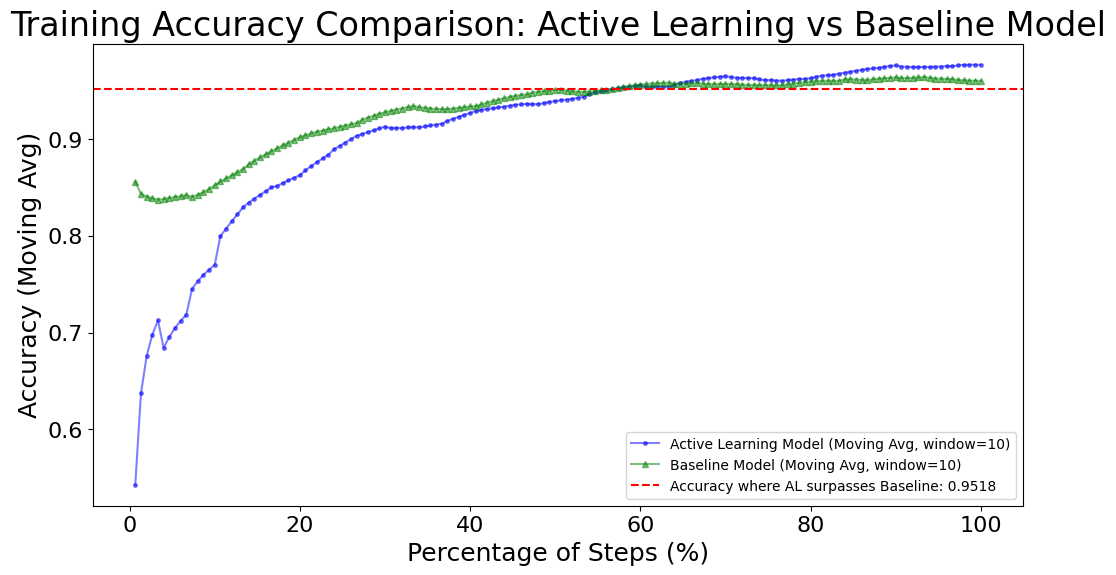

In [105]:
import matplotlib.pyplot as plt

# Define the window size for the moving average (10 points)
window_size = 10

# Calculate the moving average of accuracy values for active learning and baseline models
moving_average_accuracy_active_learning = [
    sum(active_learning_accuracy_list[max(0, i - window_size + 1):i + 1]) / min(i + 1, window_size)
    for i in range(len(active_learning_accuracy_list))
]

moving_average_accuracy_baseline = [
    sum(accuracy_list[max(0, i - window_size + 1):i + 1]) / min(i + 1, window_size)
    for i in range(len(accuracy_list))
]

# Calculate the total number of steps for both models
total_steps_active_learning = len(moving_average_accuracy_active_learning)
total_steps_baseline = len(moving_average_accuracy_baseline)

# Calculate the percentage for each step
percentage_steps_active_learning = [(i + 1) / total_steps_active_learning * 100 for i in range(total_steps_active_learning)]
percentage_steps_baseline = [(i + 1) / total_steps_baseline * 100 for i in range(total_steps_baseline)]

# Find the step where the active learning model first surpasses the baseline model in accuracy
try:
    surpass_index = next(i for i in range(len(moving_average_accuracy_active_learning)) if moving_average_accuracy_active_learning[i] > moving_average_accuracy_baseline[i])
except StopIteration:
    surpass_index = None

# Assuming `final_accuracy` holds the final accuracy of the baseline model
final_accuracy = moving_average_accuracy_baseline[-1]

# Plot the training accuracy for both models
plt.figure(figsize=(12, 6))

# Active Learning Model
plt.plot(percentage_steps_active_learning, moving_average_accuracy_active_learning, marker='.', markersize=5, alpha=0.5, color='blue', label=f'Active Learning Model (Moving Avg, window={window_size})')

# Baseline Model
plt.plot(percentage_steps_baseline, moving_average_accuracy_baseline, marker='^', markersize=5, alpha=0.5, color='green', label=f'Baseline Model (Moving Avg, window={window_size})')

# Plot a red horizontal line where the active learning model first surpasses the baseline model in accuracy
if surpass_index is not None:
    plt.axhline(y=moving_average_accuracy_active_learning[surpass_index], color='red', linestyle='--', label=f'Accuracy where AL surpasses Baseline: {moving_average_accuracy_active_learning[surpass_index]:.4f}')


# Add title, labels, and legend
plt.title('Training Accuracy Comparison: Active Learning vs Baseline Model')
plt.xlabel('Percentage of Steps (%)')
plt.ylabel('Accuracy (Moving Avg)')
plt.legend(loc='lower right')

# Show the plot
plt.show()


In [106]:
# # Save Model Weights
# model.save_weights('model.h5')

In [107]:
# if USE_VAL:
#     # Validation Predictions
#     y_val_pred = model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
#     # Label
#     labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

# Landmark Attention Weights

In [108]:
# # Landmark Weights
# for w in model.get_layer('embedding').weights:
#     if 'landmark_weights' in w.name:
#         weights = scipy.special.softmax(w)

# landmarks = ['lips_embedding', 'left_hand_embedding', 'pose_embedding']

# for w, lm in zip(weights, landmarks):
#     print(f'{lm} weight: {(w*100):.1f}%')

# Classification Report

In [109]:
# def print_classification_report():
#     # Classification report for all signs
#     classification_report = sklearn.metrics.classification_report(
#             y_val,
#             y_val_pred,
#             target_names=labels,
#             output_dict=True,
#         )
#     # Round Data for better readability
#     classification_report = pd.DataFrame(classification_report).T
#     classification_report = classification_report.round(2)
#     classification_report = classification_report.astype({
#             'support': np.uint16,
#         })
#     # Add signs
#     classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
#     classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
#     # Sort on F1-score
#     classification_report = pd.concat((
#         classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
#         classification_report.tail(3),
#     ))

#     pd.options.display.max_rows = 999
#     display(classification_report)

In [110]:
# if USE_VAL:
#     print_classification_report()

# Training History

In [111]:
# def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
#     plt.figure(figsize=(20, 10))
    
#     values = history.history[metric]
#     N_EPOCHS = len(values)
#     val = 'val' in ''.join(history.history.keys())
#     # Epoch Ticks
#     if N_EPOCHS <= 20:
#         x = np.arange(1, N_EPOCHS + 1)
#     else:
#         x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

#     x_ticks = np.arange(1, N_EPOCHS+1)

#     # Validation
#     if val:
#         val_values = history.history[f'val_{metric}']
#         val_argmin = f_best(val_values)
#         plt.plot(x_ticks, val_values, label=f'val')

#     # summarize history for accuracy
#     plt.plot(x_ticks, values, label=f'train')
#     argmin = f_best(values)
#     plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
#     if val:
#         plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

#     plt.title(f'Model {metric}', fontsize=24, pad=10)
#     plt.ylabel(metric, fontsize=20, labelpad=10)

#     if ylim:
#         plt.ylim(ylim)

#     if yscale is not None:
#         plt.yscale(yscale)
        
#     if yticks is not None:
#         plt.yticks(yticks, fontsize=16)

#     plt.xlabel('epoch', fontsize=20, labelpad=10)        
#     plt.tick_params(axis='x', labelsize=8)
#     plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
#     plt.yticks(fontsize=16)
    
#     plt.legend(prop={'size': 10})
#     plt.grid()
#     plt.show()

In [112]:
# if TRAIN_MODEL:
#     plot_history_metric('loss', f_best=np.argmin)

In [113]:
# if TRAIN_MODEL:
#     plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [114]:
# if TRAIN_MODEL:
#     plot_history_metric('top_5_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

In [115]:
# if TRAIN_MODEL:
#     plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

In [116]:
# # TFLite model for submission
# class TFLiteModel(tf.Module):
#     def __init__(self, model):
#         super(TFLiteModel, self).__init__()

#         # Load the feature generation and main models
#         self.preprocess_layer = preprocess_layer
#         self.model = model
    
#     @tf.function(input_signature=[tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32, name='inputs')])
#     def __call__(self, inputs):
#         # Preprocess Data
#         x, non_empty_frame_idxs = self.preprocess_layer(inputs)
#         # Add Batch Dimension
#         x = tf.expand_dims(x, axis=0)
#         non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
#         # Make Prediction
#         outputs = self.model({ 'frames': x, 'non_empty_frame_idxs': non_empty_frame_idxs })
#         # Squeeze Output 1x250 -> 250
#         outputs = tf.squeeze(outputs, axis=0)

#         # Return a dictionary with the output tensor
#         return {'outputs': outputs}

# # Define TF Lite Model
# tflite_keras_model = TFLiteModel(model)

# # Sanity Check
# demo_raw_data = load_relevant_data_subset(train['file_path'].values[5])
# print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
# demo_output = tflite_keras_model(demo_raw_data)["outputs"]
# print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
# demo_prediction = demo_output.numpy().argmax()
# print(f'demo_prediction: {demo_prediction}, correct: {train.iloc[0]["sign_ord"]}')

In [117]:
# # Create Model Converter
# keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
# # Convert Model
# tflite_model = keras_model_converter.convert()
# # Write Model
# with open('/kaggle/working/model.tflite', 'wb') as f:
#     f.write(tflite_model)
    
# # Zip Model
# !zip submission.zip /kaggle/working/model.tflite

In [118]:
# # Verify TFLite model can be loaded and used for prediction
# !pip install tflite-runtime
# import tflite_runtime.interpreter as tflite

# interpreter = tflite.Interpreter("/kaggle/working/model.tflite")
# found_signatures = list(interpreter.get_signature_list().keys())
# prediction_fn = interpreter.get_signature_runner("serving_default")

# output = prediction_fn(inputs=demo_raw_data)
# sign = output['outputs'].argmax()

# print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
# print("TRUE : ", train.sign.values[0], f'[{train.sign_ord.values[0]}]')